In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, SpectralNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.constraints import Constraint
import pickle

In [ ]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [ ]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [ ]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [ ]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if (i+1) % 5 == 0:
            C_A_list.append(C_A - C_As)  # in deviation form
            T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [ ]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [ ]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [ ]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
# RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, -T_input, -CA_input, -Q_input, -CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [ ]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [ ]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [ ]:
# checking output
print(RNN_output[0, :5])

[[-75.72458929   1.4325163 ]
 [-76.84802004   1.4248451 ]
 [-77.97016868   1.41722366]
 [-79.09094468   1.40964998]
 [-80.21026299   1.40212216]]


In [ ]:
def check_non_negative_weights_ignore_bias(model):
    all_non_negative = True
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # tf the layer has weights
            # check only the weight matrices (ignoring biases if present)
            weight_only = weights[0]  # assume weights are the first element, bias (if any) is second
            if not np.all(weight_only >= 0):
                print(f"Non-negative check failed in layer: {layer.name}")
                all_non_negative = False
    if all_non_negative:
        print("All weights are non-negative (ignoring biases).")
    else:
        print("Some weights are negative (ignoring biases).")

In [ ]:
# this method will provide an overestimate of the Lipschitz constant
def evaluate_lip_const(model: Model, x, eps, seed=None):
    """
    Evaluate the Lipschitz constant of a model, with the naive method.
    Please note that the estimation of the lipschitz constant is done locally around
    input sample. This may not correctly estimate the behaviour in the whole domain.

    Args:
        model: built keras model used to make predictions
        x: inputs used to compute the lipschitz constant
        eps (float): magnitude of noise to add to input in order to compute the constant
        seed (int): seed used when generating the noise ( can be set to None )

    Returns:
        float: the empirically evaluated lipschitz constant. The computation might also
            be inaccurate in high dimensional space.

    """
    y_pred = model.predict(x)
    x_var = x + K.random_uniform(
        shape=x.shape, minval=eps * 0.25, maxval=eps, seed=seed
    )
#     x_var = x + K.random_normal(
#         shape=x.shape, mean=0, stddev=eps, seed=seed
#     )
    y_pred_var = model.predict(x_var)
    dx = x - x_var
    dfx = y_pred - y_pred_var
    ndx = K.sqrt(K.sum(K.square(dx), axis=range(1, len(x.shape))))
    ndfx = K.sqrt(K.sum(K.square(dfx), axis=range(1, len(y_pred.shape))))
    lip_cst = K.max(ndfx / ndx)
    print(f"lip cst: {lip_cst:.3f}")
    return lip_cst

In [ ]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*19
test_loss = [0]*19
lip = [0]*19
noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for i in range(19):
    num_dims = 4

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

    # define scalers for both X and y base on training data only
    scaler_X = preprocessing.MinMaxScaler().fit(X_train.reshape(-1, num_dims))
    scaler_y = preprocessing.MinMaxScaler().fit(y_train.reshape(-1, 2))

    X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
    y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

    # X is just the initial condition, so we introduce noise to the output trajectory y
    y_train = y_train + np.random.normal(0, noise[-1], y_train.shape)

    # RNN
    nh = 64
    input = Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = SimpleRNN(nh,
          return_sequences=True,
          )(input)
    x = SimpleRNN(nh,
          return_sequences=True,
          )(x)
    x = Dense(2,
            activation='linear',
            )(x)
    model = Model(input, x)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

    training_loss[i] = history.history['val_loss'][-1]
    print(noise)
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)

    # check convexity by checking the weights
    check_non_negative_weights_ignore_bias(model)

    # compute the Lipschitz constant for the 2-layer RNN
    lipschitz_constant = evaluate_lip_const(model, X_train, 1e-04, 42)
    print(f"Estimated Lipschitz constant of the 2-layer RNN: {lipschitz_constant}")

    lip[i] = lipschitz_constant

model.summary()

Epoch 1/1000
26/26 - 2s - loss: 0.1562 - mean_squared_error: 0.1562 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - 2s/epoch - 58ms/step
Epoch 2/1000
26/26 - 0s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - 273ms/epoch - 11ms/step
Epoch 3/1000
26/26 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - 270ms/epoch - 10ms/step
Epoch 4/1000
26/26 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 390ms/epoch - 15ms/step
Epoch 5/1000
26/26 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - 287ms/epoch - 11ms/step
Epoch 6/1000
26/26 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - 329ms/epoch - 13ms/step
Epoch 7/1000
26/26 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - 332ms

26/26 - 0s - loss: 6.5512e-05 - mean_squared_error: 6.5512e-05 - val_loss: 6.6175e-05 - val_mean_squared_error: 6.6175e-05 - 289ms/epoch - 11ms/step
Epoch 53/1000
26/26 - 0s - loss: 6.3642e-05 - mean_squared_error: 6.3642e-05 - val_loss: 6.3288e-05 - val_mean_squared_error: 6.3288e-05 - 331ms/epoch - 13ms/step
Epoch 54/1000
26/26 - 0s - loss: 6.1628e-05 - mean_squared_error: 6.1628e-05 - val_loss: 6.1744e-05 - val_mean_squared_error: 6.1744e-05 - 282ms/epoch - 11ms/step
Epoch 55/1000
26/26 - 0s - loss: 6.0104e-05 - mean_squared_error: 6.0104e-05 - val_loss: 5.9115e-05 - val_mean_squared_error: 5.9115e-05 - 276ms/epoch - 11ms/step
Epoch 56/1000
26/26 - 0s - loss: 5.8344e-05 - mean_squared_error: 5.8344e-05 - val_loss: 5.9047e-05 - val_mean_squared_error: 5.9047e-05 - 375ms/epoch - 14ms/step
Epoch 57/1000
26/26 - 0s - loss: 5.9637e-05 - mean_squared_error: 5.9637e-05 - val_loss: 5.9589e-05 - val_mean_squared_error: 5.9589e-05 - 206ms/epoch - 8ms/step
Epoch 58/1000
26/26 - 0s - loss: 5.66

Epoch 103/1000
26/26 - 0s - loss: 2.9287e-05 - mean_squared_error: 2.9287e-05 - val_loss: 3.8020e-05 - val_mean_squared_error: 3.8020e-05 - 385ms/epoch - 15ms/step
Epoch 104/1000
26/26 - 0s - loss: 4.7736e-05 - mean_squared_error: 4.7736e-05 - val_loss: 9.4588e-05 - val_mean_squared_error: 9.4588e-05 - 252ms/epoch - 10ms/step
Epoch 105/1000
26/26 - 0s - loss: 4.5824e-05 - mean_squared_error: 4.5824e-05 - val_loss: 2.2875e-05 - val_mean_squared_error: 2.2875e-05 - 280ms/epoch - 11ms/step
Epoch 106/1000
26/26 - 0s - loss: 5.1035e-05 - mean_squared_error: 5.1035e-05 - val_loss: 2.7418e-05 - val_mean_squared_error: 2.7418e-05 - 340ms/epoch - 13ms/step
Epoch 107/1000
26/26 - 0s - loss: 4.1001e-05 - mean_squared_error: 4.1001e-05 - val_loss: 3.8981e-05 - val_mean_squared_error: 3.8981e-05 - 263ms/epoch - 10ms/step
Epoch 108/1000
26/26 - 0s - loss: 8.1721e-05 - mean_squared_error: 8.1721e-05 - val_loss: 3.3143e-05 - val_mean_squared_error: 3.3143e-05 - 302ms/epoch - 12ms/step
Epoch 109/1000
2

Epoch 153/1000
26/26 - 0s - loss: 6.6597e-05 - mean_squared_error: 6.6597e-05 - val_loss: 1.5554e-05 - val_mean_squared_error: 1.5554e-05 - 231ms/epoch - 9ms/step
Epoch 154/1000
26/26 - 0s - loss: 5.4045e-05 - mean_squared_error: 5.4045e-05 - val_loss: 2.4328e-05 - val_mean_squared_error: 2.4328e-05 - 224ms/epoch - 9ms/step
Epoch 155/1000
26/26 - 0s - loss: 1.7796e-05 - mean_squared_error: 1.7796e-05 - val_loss: 3.1419e-05 - val_mean_squared_error: 3.1419e-05 - 213ms/epoch - 8ms/step
Epoch 156/1000
26/26 - 0s - loss: 3.3980e-05 - mean_squared_error: 3.3980e-05 - val_loss: 1.9393e-05 - val_mean_squared_error: 1.9393e-05 - 227ms/epoch - 9ms/step
Epoch 157/1000
26/26 - 0s - loss: 4.4358e-05 - mean_squared_error: 4.4358e-05 - val_loss: 3.7708e-05 - val_mean_squared_error: 3.7708e-05 - 234ms/epoch - 9ms/step
Epoch 158/1000
26/26 - 0s - loss: 4.1729e-05 - mean_squared_error: 4.1729e-05 - val_loss: 1.0703e-04 - val_mean_squared_error: 1.0703e-04 - 226ms/epoch - 9ms/step
Epoch 159/1000
26/26 -

Epoch 204/1000
26/26 - 0s - loss: 2.9032e-05 - mean_squared_error: 2.9032e-05 - val_loss: 1.1802e-05 - val_mean_squared_error: 1.1802e-05 - 208ms/epoch - 8ms/step
Epoch 205/1000
26/26 - 0s - loss: 2.2146e-05 - mean_squared_error: 2.2146e-05 - val_loss: 1.5063e-04 - val_mean_squared_error: 1.5063e-04 - 229ms/epoch - 9ms/step
Epoch 206/1000
26/26 - 0s - loss: 1.5555e-04 - mean_squared_error: 1.5555e-04 - val_loss: 4.9988e-05 - val_mean_squared_error: 4.9988e-05 - 228ms/epoch - 9ms/step
Epoch 207/1000
26/26 - 0s - loss: 2.3521e-05 - mean_squared_error: 2.3521e-05 - val_loss: 2.8327e-05 - val_mean_squared_error: 2.8327e-05 - 212ms/epoch - 8ms/step
Epoch 208/1000
26/26 - 0s - loss: 4.0852e-05 - mean_squared_error: 4.0852e-05 - val_loss: 8.4393e-05 - val_mean_squared_error: 8.4393e-05 - 212ms/epoch - 8ms/step
Epoch 209/1000
26/26 - 0s - loss: 3.6837e-05 - mean_squared_error: 3.6837e-05 - val_loss: 1.4435e-05 - val_mean_squared_error: 1.4435e-05 - 218ms/epoch - 8ms/step
Epoch 210/1000
26/26 -

Epoch 255/1000
26/26 - 0s - loss: 1.4167e-05 - mean_squared_error: 1.4167e-05 - val_loss: 1.5406e-05 - val_mean_squared_error: 1.5406e-05 - 187ms/epoch - 7ms/step
Epoch 256/1000
26/26 - 0s - loss: 6.0214e-05 - mean_squared_error: 6.0214e-05 - val_loss: 3.2775e-05 - val_mean_squared_error: 3.2775e-05 - 214ms/epoch - 8ms/step
Epoch 257/1000
26/26 - 0s - loss: 1.6533e-05 - mean_squared_error: 1.6533e-05 - val_loss: 1.2038e-05 - val_mean_squared_error: 1.2038e-05 - 215ms/epoch - 8ms/step
Epoch 258/1000
26/26 - 0s - loss: 2.1968e-05 - mean_squared_error: 2.1968e-05 - val_loss: 6.4418e-06 - val_mean_squared_error: 6.4418e-06 - 202ms/epoch - 8ms/step
Epoch 259/1000
26/26 - 0s - loss: 2.6525e-05 - mean_squared_error: 2.6525e-05 - val_loss: 3.4392e-05 - val_mean_squared_error: 3.4392e-05 - 217ms/epoch - 8ms/step
Epoch 260/1000
26/26 - 0s - loss: 1.8983e-05 - mean_squared_error: 1.8983e-05 - val_loss: 7.3892e-06 - val_mean_squared_error: 7.3892e-06 - 200ms/epoch - 8ms/step
Epoch 261/1000
26/26 -

Epoch 306/1000
26/26 - 0s - loss: 1.7033e-05 - mean_squared_error: 1.7033e-05 - val_loss: 6.5620e-06 - val_mean_squared_error: 6.5620e-06 - 210ms/epoch - 8ms/step
Epoch 307/1000
26/26 - 0s - loss: 2.8334e-05 - mean_squared_error: 2.8334e-05 - val_loss: 1.6037e-05 - val_mean_squared_error: 1.6037e-05 - 191ms/epoch - 7ms/step
Epoch 308/1000
26/26 - 0s - loss: 2.1700e-05 - mean_squared_error: 2.1700e-05 - val_loss: 1.5128e-05 - val_mean_squared_error: 1.5128e-05 - 206ms/epoch - 8ms/step
Epoch 309/1000
26/26 - 0s - loss: 1.6978e-05 - mean_squared_error: 1.6978e-05 - val_loss: 1.4169e-05 - val_mean_squared_error: 1.4169e-05 - 213ms/epoch - 8ms/step
Epoch 310/1000
26/26 - 0s - loss: 2.3322e-05 - mean_squared_error: 2.3322e-05 - val_loss: 8.9647e-05 - val_mean_squared_error: 8.9647e-05 - 212ms/epoch - 8ms/step
Epoch 311/1000
26/26 - 0s - loss: 3.1452e-05 - mean_squared_error: 3.1452e-05 - val_loss: 2.0714e-05 - val_mean_squared_error: 2.0714e-05 - 210ms/epoch - 8ms/step
Epoch 312/1000
26/26 -

Epoch 357/1000
26/26 - 0s - loss: 1.9692e-05 - mean_squared_error: 1.9692e-05 - val_loss: 2.3247e-05 - val_mean_squared_error: 2.3247e-05 - 235ms/epoch - 9ms/step
Epoch 358/1000
26/26 - 0s - loss: 1.1266e-05 - mean_squared_error: 1.1266e-05 - val_loss: 1.1099e-05 - val_mean_squared_error: 1.1099e-05 - 197ms/epoch - 8ms/step
Epoch 359/1000
26/26 - 0s - loss: 3.3974e-05 - mean_squared_error: 3.3974e-05 - val_loss: 2.7024e-05 - val_mean_squared_error: 2.7024e-05 - 217ms/epoch - 8ms/step
Epoch 360/1000
26/26 - 0s - loss: 1.2681e-05 - mean_squared_error: 1.2681e-05 - val_loss: 6.0117e-06 - val_mean_squared_error: 6.0117e-06 - 205ms/epoch - 8ms/step
Epoch 361/1000
26/26 - 0s - loss: 9.5587e-06 - mean_squared_error: 9.5587e-06 - val_loss: 4.5483e-06 - val_mean_squared_error: 4.5483e-06 - 212ms/epoch - 8ms/step
Epoch 362/1000
26/26 - 0s - loss: 1.2836e-05 - mean_squared_error: 1.2836e-05 - val_loss: 8.7896e-06 - val_mean_squared_error: 8.7896e-06 - 202ms/epoch - 8ms/step
Epoch 363/1000
26/26 -

Epoch 408/1000
26/26 - 0s - loss: 3.7503e-05 - mean_squared_error: 3.7503e-05 - val_loss: 3.8632e-05 - val_mean_squared_error: 3.8632e-05 - 200ms/epoch - 8ms/step
Epoch 409/1000
26/26 - 0s - loss: 2.7971e-05 - mean_squared_error: 2.7971e-05 - val_loss: 9.3772e-06 - val_mean_squared_error: 9.3772e-06 - 188ms/epoch - 7ms/step
Epoch 410/1000
26/26 - 0s - loss: 1.2365e-05 - mean_squared_error: 1.2365e-05 - val_loss: 2.0188e-05 - val_mean_squared_error: 2.0188e-05 - 211ms/epoch - 8ms/step
Epoch 411/1000
26/26 - 0s - loss: 1.0420e-05 - mean_squared_error: 1.0420e-05 - val_loss: 1.1087e-05 - val_mean_squared_error: 1.1087e-05 - 185ms/epoch - 7ms/step
Epoch 412/1000
26/26 - 0s - loss: 8.6560e-06 - mean_squared_error: 8.6560e-06 - val_loss: 2.2246e-05 - val_mean_squared_error: 2.2246e-05 - 215ms/epoch - 8ms/step
Epoch 413/1000
26/26 - 0s - loss: 1.3324e-05 - mean_squared_error: 1.3324e-05 - val_loss: 4.0449e-05 - val_mean_squared_error: 4.0449e-05 - 202ms/epoch - 8ms/step
Epoch 414/1000
26/26 -

Epoch 459/1000
26/26 - 0s - loss: 7.9644e-06 - mean_squared_error: 7.9644e-06 - val_loss: 4.6021e-06 - val_mean_squared_error: 4.6021e-06 - 185ms/epoch - 7ms/step
Epoch 460/1000
26/26 - 0s - loss: 6.3629e-06 - mean_squared_error: 6.3629e-06 - val_loss: 5.8324e-06 - val_mean_squared_error: 5.8324e-06 - 203ms/epoch - 8ms/step
Epoch 461/1000
26/26 - 0s - loss: 2.3637e-05 - mean_squared_error: 2.3637e-05 - val_loss: 1.4814e-05 - val_mean_squared_error: 1.4814e-05 - 212ms/epoch - 8ms/step
Epoch 462/1000
26/26 - 0s - loss: 1.4711e-05 - mean_squared_error: 1.4711e-05 - val_loss: 2.7767e-05 - val_mean_squared_error: 2.7767e-05 - 201ms/epoch - 8ms/step
Epoch 463/1000
26/26 - 0s - loss: 1.1669e-05 - mean_squared_error: 1.1669e-05 - val_loss: 6.6592e-06 - val_mean_squared_error: 6.6592e-06 - 201ms/epoch - 8ms/step
Epoch 464/1000
26/26 - 0s - loss: 9.6580e-06 - mean_squared_error: 9.6580e-06 - val_loss: 2.3646e-05 - val_mean_squared_error: 2.3646e-05 - 199ms/epoch - 8ms/step
Epoch 465/1000
26/26 -

Epoch 510/1000
26/26 - 0s - loss: 4.8123e-06 - mean_squared_error: 4.8123e-06 - val_loss: 1.0602e-05 - val_mean_squared_error: 1.0602e-05 - 210ms/epoch - 8ms/step
Epoch 511/1000
26/26 - 0s - loss: 6.1866e-06 - mean_squared_error: 6.1866e-06 - val_loss: 7.8240e-06 - val_mean_squared_error: 7.8240e-06 - 217ms/epoch - 8ms/step
Epoch 512/1000
26/26 - 0s - loss: 4.4304e-06 - mean_squared_error: 4.4304e-06 - val_loss: 3.1230e-06 - val_mean_squared_error: 3.1230e-06 - 200ms/epoch - 8ms/step
Epoch 513/1000
26/26 - 0s - loss: 1.8290e-05 - mean_squared_error: 1.8290e-05 - val_loss: 7.5742e-06 - val_mean_squared_error: 7.5742e-06 - 201ms/epoch - 8ms/step
Epoch 514/1000
26/26 - 0s - loss: 7.8832e-06 - mean_squared_error: 7.8832e-06 - val_loss: 4.5096e-06 - val_mean_squared_error: 4.5096e-06 - 207ms/epoch - 8ms/step
Epoch 515/1000
26/26 - 0s - loss: 5.9201e-06 - mean_squared_error: 5.9201e-06 - val_loss: 1.5619e-05 - val_mean_squared_error: 1.5619e-05 - 225ms/epoch - 9ms/step
Epoch 516/1000
26/26 -

Epoch 561/1000
26/26 - 0s - loss: 1.2805e-05 - mean_squared_error: 1.2805e-05 - val_loss: 1.2736e-05 - val_mean_squared_error: 1.2736e-05 - 196ms/epoch - 8ms/step
Epoch 562/1000
26/26 - 0s - loss: 9.7317e-06 - mean_squared_error: 9.7317e-06 - val_loss: 1.3956e-05 - val_mean_squared_error: 1.3956e-05 - 200ms/epoch - 8ms/step
Epoch 563/1000
26/26 - 0s - loss: 1.8738e-05 - mean_squared_error: 1.8738e-05 - val_loss: 8.3736e-06 - val_mean_squared_error: 8.3736e-06 - 217ms/epoch - 8ms/step
Epoch 564/1000
26/26 - 0s - loss: 1.1588e-05 - mean_squared_error: 1.1588e-05 - val_loss: 5.3376e-06 - val_mean_squared_error: 5.3376e-06 - 200ms/epoch - 8ms/step
Epoch 565/1000
26/26 - 0s - loss: 4.6720e-06 - mean_squared_error: 4.6720e-06 - val_loss: 4.4457e-06 - val_mean_squared_error: 4.4457e-06 - 207ms/epoch - 8ms/step
Epoch 566/1000
26/26 - 0s - loss: 4.6673e-06 - mean_squared_error: 4.6673e-06 - val_loss: 1.1036e-05 - val_mean_squared_error: 1.1036e-05 - 210ms/epoch - 8ms/step
Epoch 567/1000
26/26 -

Epoch 612/1000
26/26 - 0s - loss: 8.5580e-06 - mean_squared_error: 8.5580e-06 - val_loss: 7.9205e-06 - val_mean_squared_error: 7.9205e-06 - 199ms/epoch - 8ms/step
Epoch 613/1000
26/26 - 0s - loss: 8.7391e-06 - mean_squared_error: 8.7391e-06 - val_loss: 4.9558e-06 - val_mean_squared_error: 4.9558e-06 - 200ms/epoch - 8ms/step
Epoch 614/1000
26/26 - 0s - loss: 5.2993e-06 - mean_squared_error: 5.2993e-06 - val_loss: 4.5943e-06 - val_mean_squared_error: 4.5943e-06 - 195ms/epoch - 7ms/step
Epoch 615/1000
26/26 - 0s - loss: 4.0938e-06 - mean_squared_error: 4.0938e-06 - val_loss: 7.7121e-06 - val_mean_squared_error: 7.7121e-06 - 200ms/epoch - 8ms/step
Epoch 616/1000
26/26 - 0s - loss: 1.0819e-05 - mean_squared_error: 1.0819e-05 - val_loss: 6.9803e-06 - val_mean_squared_error: 6.9803e-06 - 188ms/epoch - 7ms/step
Epoch 617/1000
26/26 - 0s - loss: 6.7511e-06 - mean_squared_error: 6.7511e-06 - val_loss: 1.2044e-05 - val_mean_squared_error: 1.2044e-05 - 212ms/epoch - 8ms/step
Epoch 618/1000
26/26 -

Epoch 663/1000
26/26 - 0s - loss: 4.7195e-06 - mean_squared_error: 4.7195e-06 - val_loss: 1.8430e-06 - val_mean_squared_error: 1.8430e-06 - 260ms/epoch - 10ms/step
Epoch 664/1000
26/26 - 0s - loss: 6.7973e-06 - mean_squared_error: 6.7973e-06 - val_loss: 7.6395e-06 - val_mean_squared_error: 7.6395e-06 - 245ms/epoch - 9ms/step
Epoch 665/1000
26/26 - 0s - loss: 4.6506e-06 - mean_squared_error: 4.6506e-06 - val_loss: 6.4394e-06 - val_mean_squared_error: 6.4393e-06 - 250ms/epoch - 10ms/step
Epoch 666/1000
26/26 - 0s - loss: 5.6671e-06 - mean_squared_error: 5.6671e-06 - val_loss: 9.2077e-06 - val_mean_squared_error: 9.2077e-06 - 236ms/epoch - 9ms/step
Epoch 667/1000
26/26 - 0s - loss: 1.0573e-05 - mean_squared_error: 1.0573e-05 - val_loss: 7.6457e-06 - val_mean_squared_error: 7.6457e-06 - 233ms/epoch - 9ms/step
Epoch 668/1000
26/26 - 0s - loss: 5.2289e-06 - mean_squared_error: 5.2289e-06 - val_loss: 7.9806e-06 - val_mean_squared_error: 7.9806e-06 - 236ms/epoch - 9ms/step
Epoch 669/1000
26/26

Epoch 714/1000
26/26 - 0s - loss: 4.8173e-06 - mean_squared_error: 4.8173e-06 - val_loss: 9.3044e-06 - val_mean_squared_error: 9.3044e-06 - 265ms/epoch - 10ms/step
Epoch 715/1000
26/26 - 0s - loss: 1.0242e-05 - mean_squared_error: 1.0242e-05 - val_loss: 8.1702e-06 - val_mean_squared_error: 8.1702e-06 - 249ms/epoch - 10ms/step
Epoch 716/1000
26/26 - 0s - loss: 4.4972e-06 - mean_squared_error: 4.4972e-06 - val_loss: 2.6034e-06 - val_mean_squared_error: 2.6034e-06 - 256ms/epoch - 10ms/step
Epoch 717/1000
26/26 - 0s - loss: 2.3196e-06 - mean_squared_error: 2.3196e-06 - val_loss: 1.7320e-06 - val_mean_squared_error: 1.7320e-06 - 232ms/epoch - 9ms/step
Epoch 718/1000
26/26 - 0s - loss: 5.3410e-06 - mean_squared_error: 5.3410e-06 - val_loss: 8.9889e-06 - val_mean_squared_error: 8.9889e-06 - 265ms/epoch - 10ms/step
Epoch 719/1000
26/26 - 0s - loss: 3.1170e-06 - mean_squared_error: 3.1170e-06 - val_loss: 2.3678e-06 - val_mean_squared_error: 2.3678e-06 - 246ms/epoch - 9ms/step
Epoch 720/1000
26/

26/26 - 0s - loss: 4.2812e-06 - mean_squared_error: 4.2812e-06 - val_loss: 2.0415e-06 - val_mean_squared_error: 2.0415e-06 - 235ms/epoch - 9ms/step
Epoch 765/1000
26/26 - 0s - loss: 6.5934e-06 - mean_squared_error: 6.5934e-06 - val_loss: 6.8813e-06 - val_mean_squared_error: 6.8813e-06 - 267ms/epoch - 10ms/step
Epoch 766/1000
26/26 - 0s - loss: 5.2865e-06 - mean_squared_error: 5.2865e-06 - val_loss: 3.8356e-06 - val_mean_squared_error: 3.8356e-06 - 271ms/epoch - 10ms/step
Epoch 767/1000
26/26 - 0s - loss: 7.1611e-06 - mean_squared_error: 7.1611e-06 - val_loss: 2.3482e-05 - val_mean_squared_error: 2.3482e-05 - 255ms/epoch - 10ms/step
Epoch 768/1000
26/26 - 0s - loss: 6.5858e-06 - mean_squared_error: 6.5858e-06 - val_loss: 4.8391e-06 - val_mean_squared_error: 4.8391e-06 - 264ms/epoch - 10ms/step
Epoch 769/1000
26/26 - 0s - loss: 3.7565e-06 - mean_squared_error: 3.7565e-06 - val_loss: 4.0974e-06 - val_mean_squared_error: 4.0974e-06 - 282ms/epoch - 11ms/step
Epoch 770/1000
26/26 - 0s - loss

Epoch 815/1000
26/26 - 0s - loss: 1.7097e-06 - mean_squared_error: 1.7097e-06 - val_loss: 1.9499e-06 - val_mean_squared_error: 1.9499e-06 - 256ms/epoch - 10ms/step
Epoch 816/1000
26/26 - 0s - loss: 2.2173e-06 - mean_squared_error: 2.2173e-06 - val_loss: 2.8056e-06 - val_mean_squared_error: 2.8056e-06 - 262ms/epoch - 10ms/step
Epoch 817/1000
26/26 - 0s - loss: 1.2374e-05 - mean_squared_error: 1.2374e-05 - val_loss: 1.3132e-05 - val_mean_squared_error: 1.3132e-05 - 245ms/epoch - 9ms/step
Epoch 818/1000
26/26 - 0s - loss: 6.0865e-06 - mean_squared_error: 6.0865e-06 - val_loss: 2.7150e-06 - val_mean_squared_error: 2.7150e-06 - 294ms/epoch - 11ms/step
Epoch 819/1000
26/26 - 0s - loss: 3.8893e-06 - mean_squared_error: 3.8893e-06 - val_loss: 4.7332e-06 - val_mean_squared_error: 4.7332e-06 - 270ms/epoch - 10ms/step
Epoch 820/1000
26/26 - 0s - loss: 4.3395e-06 - mean_squared_error: 4.3395e-06 - val_loss: 1.6755e-06 - val_mean_squared_error: 1.6755e-06 - 259ms/epoch - 10ms/step
Epoch 821/1000
26

26/26 - 0s - loss: 8.5290e-06 - mean_squared_error: 8.5290e-06 - val_loss: 1.5036e-05 - val_mean_squared_error: 1.5036e-05 - 250ms/epoch - 10ms/step
Epoch 866/1000
26/26 - 0s - loss: 6.2530e-06 - mean_squared_error: 6.2530e-06 - val_loss: 5.3733e-06 - val_mean_squared_error: 5.3733e-06 - 250ms/epoch - 10ms/step
Epoch 867/1000
26/26 - 0s - loss: 2.5047e-06 - mean_squared_error: 2.5047e-06 - val_loss: 1.4379e-06 - val_mean_squared_error: 1.4379e-06 - 234ms/epoch - 9ms/step
Epoch 868/1000
26/26 - 0s - loss: 1.9814e-06 - mean_squared_error: 1.9814e-06 - val_loss: 2.1139e-06 - val_mean_squared_error: 2.1139e-06 - 250ms/epoch - 10ms/step
Epoch 869/1000
26/26 - 0s - loss: 5.2895e-06 - mean_squared_error: 5.2895e-06 - val_loss: 1.0513e-05 - val_mean_squared_error: 1.0513e-05 - 235ms/epoch - 9ms/step
Epoch 870/1000
26/26 - 0s - loss: 5.4784e-06 - mean_squared_error: 5.4784e-06 - val_loss: 6.9039e-06 - val_mean_squared_error: 6.9039e-06 - 248ms/epoch - 10ms/step
Epoch 871/1000
26/26 - 0s - loss:

Epoch 916/1000
26/26 - 0s - loss: 5.2319e-06 - mean_squared_error: 5.2319e-06 - val_loss: 3.1782e-05 - val_mean_squared_error: 3.1782e-05 - 234ms/epoch - 9ms/step
Epoch 917/1000
26/26 - 0s - loss: 1.7048e-05 - mean_squared_error: 1.7048e-05 - val_loss: 2.1488e-05 - val_mean_squared_error: 2.1488e-05 - 234ms/epoch - 9ms/step
Epoch 918/1000
26/26 - 0s - loss: 1.7555e-05 - mean_squared_error: 1.7555e-05 - val_loss: 1.3892e-05 - val_mean_squared_error: 1.3892e-05 - 249ms/epoch - 10ms/step
Epoch 919/1000
26/26 - 0s - loss: 1.1817e-05 - mean_squared_error: 1.1817e-05 - val_loss: 6.1734e-06 - val_mean_squared_error: 6.1734e-06 - 234ms/epoch - 9ms/step
Epoch 920/1000
26/26 - 0s - loss: 3.9485e-06 - mean_squared_error: 3.9485e-06 - val_loss: 6.4472e-06 - val_mean_squared_error: 6.4472e-06 - 249ms/epoch - 10ms/step
Epoch 921/1000
26/26 - 0s - loss: 2.6406e-06 - mean_squared_error: 2.6406e-06 - val_loss: 2.1903e-06 - val_mean_squared_error: 2.1903e-06 - 234ms/epoch - 9ms/step
Epoch 922/1000
26/26

Epoch 967/1000
26/26 - 0s - loss: 2.8772e-06 - mean_squared_error: 2.8772e-06 - val_loss: 1.5002e-06 - val_mean_squared_error: 1.5002e-06 - 233ms/epoch - 9ms/step
Epoch 968/1000
26/26 - 0s - loss: 3.0149e-06 - mean_squared_error: 3.0149e-06 - val_loss: 2.6591e-06 - val_mean_squared_error: 2.6591e-06 - 233ms/epoch - 9ms/step
Epoch 969/1000
26/26 - 0s - loss: 4.5288e-06 - mean_squared_error: 4.5288e-06 - val_loss: 2.8206e-06 - val_mean_squared_error: 2.8206e-06 - 234ms/epoch - 9ms/step
Epoch 970/1000
26/26 - 0s - loss: 4.4988e-06 - mean_squared_error: 4.4988e-06 - val_loss: 7.4801e-06 - val_mean_squared_error: 7.4801e-06 - 234ms/epoch - 9ms/step
Epoch 971/1000
26/26 - 0s - loss: 1.3590e-05 - mean_squared_error: 1.3590e-05 - val_loss: 1.4176e-05 - val_mean_squared_error: 1.4176e-05 - 217ms/epoch - 8ms/step
Epoch 972/1000
26/26 - 0s - loss: 4.3247e-06 - mean_squared_error: 4.3247e-06 - val_loss: 2.0908e-06 - val_mean_squared_error: 2.0908e-06 - 248ms/epoch - 10ms/step
Epoch 973/1000
26/26 

Epoch 14/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 234ms/epoch - 9ms/step
Epoch 15/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 233ms/epoch - 9ms/step
Epoch 16/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 248ms/epoch - 10ms/step
Epoch 17/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 235ms/epoch - 9ms/step
Epoch 18/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 218ms/epoch - 8ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 234ms/epoch - 9ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 

26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 71/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 72/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 73/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 74/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 250ms/epoch - 

Epoch 126/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 235ms/epoch - 9ms/step
Epoch 127/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 235ms/epoch - 9ms/step
Epoch 128/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 248ms/epoch - 10ms/step
Epoch 129/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 130/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0

Epoch 182/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 252ms/epoch - 10ms/step
Epoch 183/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 184/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 185/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 233ms/epoch - 9ms/step
Epoch 186/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 235ms/epoch - 9ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 233ms/epoch - 9ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0

Epoch 238/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 235ms/epoch - 9ms/step
Epoch 239/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 240/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 217ms/epoch - 8ms/step
Epoch 241/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 218ms/epoch - 8ms/step
Epoch 242/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 232ms/epoch - 9ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 232ms/epoch - 9ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.

Epoch 294/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 223ms/epoch - 9ms/step
Epoch 295/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 250ms/epoch - 10ms/step
Epoch 296/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 232ms/epoch - 9ms/step
Epoch 297/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 250ms/epoch - 10ms/step
Epoch 298/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 251ms/epoch - 10ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 

Epoch 350/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 351/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 234ms/epoch - 9ms/step
Epoch 352/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 353/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 232ms/epoch - 9ms/step
Epoch 354/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.

Epoch 406/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 407/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 408/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 227ms/epoch - 9ms/step
Epoch 409/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 410/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 246ms/epoch - 9ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 250ms/epoch - 10ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.

Epoch 462/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 463/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 234ms/epoch - 9ms/step
Epoch 464/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 250ms/epoch - 10ms/step
Epoch 465/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 234ms/epoch - 9ms/step
Epoch 466/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0

Epoch 518/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 240ms/epoch - 9ms/step
Epoch 519/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 270ms/epoch - 10ms/step
Epoch 520/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 244ms/epoch - 9ms/step
Epoch 521/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 254ms/epoch - 10ms/step
Epoch 522/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 240ms/epoch - 9ms/step
Epoch 523/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 253ms/epoch - 10ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 

Epoch 574/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 575/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 250ms/epoch - 10ms/step
Epoch 576/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 234ms/epoch - 9ms/step
Epoch 577/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 235ms/epoch - 9ms/step
Epoch 578/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 233ms/epoch - 9ms/step
Epoch 579/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.

Epoch 630/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 241ms/epoch - 9ms/step
Epoch 631/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 229ms/epoch - 9ms/step
Epoch 632/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 244ms/epoch - 9ms/step
Epoch 633/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 237ms/epoch - 9ms/step
Epoch 634/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 231ms/epoch - 9ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0

Epoch 686/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 216ms/epoch - 8ms/step
Epoch 687/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 217ms/epoch - 8ms/step
Epoch 688/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 689/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 690/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 226ms/epoch - 9ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0

Epoch 742/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 743/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 744/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 249ms/epoch - 10ms/step
Epoch 745/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 250ms/epoch - 10ms/step
Epoch 746/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 233ms/epoch - 9ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 235ms/epoch - 9ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 

Epoch 798/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 250ms/epoch - 10ms/step
Epoch 799/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 250ms/epoch - 10ms/step
Epoch 800/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 233ms/epoch - 9ms/step
Epoch 801/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 235ms/epoch - 9ms/step
Epoch 802/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 233ms/epoch - 9ms/step
Epoch 803/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 248ms/epoch - 10ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 

Epoch 854/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 218ms/epoch - 8ms/step
Epoch 855/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 237ms/epoch - 9ms/step
Epoch 856/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 229ms/epoch - 9ms/step
Epoch 857/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 201ms/epoch - 8ms/step
Epoch 858/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 228ms/epoch - 9ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 237ms/epoch - 9ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0

Epoch 910/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 249ms/epoch - 10ms/step
Epoch 911/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 912/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 249ms/epoch - 10ms/step
Epoch 913/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 249ms/epoch - 10ms/step
Epoch 914/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 233ms/epoch - 9ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 

Epoch 966/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 228ms/epoch - 9ms/step
Epoch 967/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 236ms/epoch - 9ms/step
Epoch 968/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 221ms/epoch - 8ms/step
Epoch 969/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 225ms/epoch - 9ms/step
Epoch 970/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 227ms/epoch - 9ms/step
Epoch 971/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 234ms/epoch - 9ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0

26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 249ms/epoch - 10ms/step
Epoch 17/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 250ms/epoch - 10ms/step
Epoch 18/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 249ms/epoch - 10ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 249ms/epoch - 10ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 246ms/epoch - 9ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 265ms/epoch - 10ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 248ms/epoc

Epoch 72/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 277ms/epoch - 11ms/step
Epoch 73/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 266ms/epoch - 10ms/step
Epoch 74/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 266ms/epoch - 10ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 254ms/epoch - 10ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 260ms/epoch - 10ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 249ms/epoch - 10ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.01

Epoch 128/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 255ms/epoch - 10ms/step
Epoch 129/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 249ms/epoch - 10ms/step
Epoch 130/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 250ms/epoch - 10ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 265ms/epoch - 10ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 263ms/epoch - 10ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 266ms/epoch - 10ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_erro

Epoch 184/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 251ms/epoch - 10ms/step
Epoch 185/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 258ms/epoch - 10ms/step
Epoch 186/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 252ms/epoch - 10ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 265ms/epoch - 10ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 249ms/epoch - 10ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 240/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 232ms/epoch - 9ms/step
Epoch 241/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 214ms/epoch - 8ms/step
Epoch 242/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 216ms/epoch - 8ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 248ms/epoch - 10ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 246ms/epoch - 9ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 255ms/epoch - 10ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0

Epoch 296/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 297/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 264ms/epoch - 10ms/step
Epoch 298/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 265ms/epoch - 10ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 250ms/epoch - 10ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 264ms/epoch - 10ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 352/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 249ms/epoch - 10ms/step
Epoch 353/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 249ms/epoch - 10ms/step
Epoch 354/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 254ms/epoch - 10ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 257ms/epoch - 10ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 254ms/epoch - 10ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_erro

Epoch 408/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 250ms/epoch - 10ms/step
Epoch 409/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 410/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 266ms/epoch - 10ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 265ms/epoch - 10ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 234ms/epoch - 9ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 234ms/epoch - 9ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error:

Epoch 464/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 281ms/epoch - 11ms/step
Epoch 465/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 466/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 233ms/epoch - 9ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 281ms/epoch - 11ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error

Epoch 520/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 282ms/epoch - 11ms/step
Epoch 521/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 293ms/epoch - 11ms/step
Epoch 522/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 283ms/epoch - 11ms/step
Epoch 523/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 273ms/epoch - 10ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 291ms/epoch - 11ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 269ms/epoch - 10ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 576/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 577/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 578/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 579/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_erro

Epoch 632/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 633/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 634/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 688/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 265ms/epoch - 10ms/step
Epoch 689/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 690/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 265ms/epoch - 10ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 249ms/epoch - 10ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 744/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 253ms/epoch - 10ms/step
Epoch 745/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 255ms/epoch - 10ms/step
Epoch 746/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 269ms/epoch - 10ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 264ms/epoch - 10ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 800/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 801/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 802/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 803/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 251ms/epoch - 10ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 856/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 264ms/epoch - 10ms/step
Epoch 857/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 244ms/epoch - 9ms/step
Epoch 858/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 265ms/epoch - 10ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 246ms/epoch - 9ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error:

Epoch 912/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 265ms/epoch - 10ms/step
Epoch 913/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 914/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 266ms/epoch - 10ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 251ms/epoch - 10ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 968/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 249ms/epoch - 10ms/step
Epoch 969/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 266ms/epoch - 10ms/step
Epoch 970/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 267ms/epoch - 10ms/step
Epoch 971/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 265ms/epoch - 10ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 250ms/epoch - 10ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 252ms/epoch - 10ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 18/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 227ms/epoch - 9ms/step
Epoch 19/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 20/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 214ms/epoch - 8ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 237ms/epoch - 9ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 239ms/epoch - 9ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 241ms/epoch - 9ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 2

26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 251ms/epoch - 10ms/step
Epoch 75/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 234ms/epoch - 9ms/step
Epoch 76/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 233ms/epoch - 9ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 250ms/epoch - 10ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 239ms/epoch - 9ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 259ms/epoch -

Epoch 130/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 235ms/epoch - 9ms/step
Epoch 131/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 249ms/epoch - 10ms/step
Epoch 132/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 234ms/epoch - 9ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 235ms/epoch - 9ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0226 - val_mean_squared_error: 0.

Epoch 186/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 187/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 235ms/epoch - 9ms/step
Epoch 188/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 203ms/epoch - 8ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 219ms/epoch - 8ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 219ms/epoch - 8ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - 207ms/epoch - 8ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0227 - val_mean_squared_error: 0.0

Epoch 242/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 249ms/epoch - 10ms/step
Epoch 243/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 218ms/epoch - 8ms/step
Epoch 244/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 218ms/epoch - 8ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 233ms/epoch - 9ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 250ms/epoch - 10ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0

Epoch 298/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 237ms/epoch - 9ms/step
Epoch 299/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 300/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 235ms/epoch - 9ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 245ms/epoch - 9ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 238ms/epoch - 9ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0

Epoch 354/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 250ms/epoch - 10ms/step
Epoch 355/1000
26/26 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 267ms/epoch - 10ms/step
Epoch 356/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0

Epoch 410/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 246ms/epoch - 9ms/step
Epoch 411/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 231ms/epoch - 9ms/step
Epoch 412/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 241ms/epoch - 9ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 241ms/epoch - 9ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - 245ms/epoch - 9ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0224 - val_mean_squared_error: 0.0

Epoch 466/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 226ms/epoch - 9ms/step
Epoch 467/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 224ms/epoch - 9ms/step
Epoch 468/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - 226ms/epoch - 9ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 220ms/epoch - 8ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 231ms/epoch - 9ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0

Epoch 522/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 523/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - 234ms/epoch - 9ms/step
Epoch 524/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 249ms/epoch - 10ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 250ms/epoch - 10ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 249ms/epoch - 10ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 

Epoch 578/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 248ms/epoch - 10ms/step
Epoch 579/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - 233ms/epoch - 9ms/step
Epoch 580/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 250ms/epoch - 10ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 250ms/epoch - 10ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 

Epoch 634/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 232ms/epoch - 9ms/step
Epoch 635/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 235ms/epoch - 9ms/step
Epoch 636/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 233ms/epoch - 9ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 235ms/epoch - 9ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 247ms/epoch - 9ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 250ms/epoch - 10ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.

Epoch 690/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 220ms/epoch - 8ms/step
Epoch 691/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 232ms/epoch - 9ms/step
Epoch 692/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 237ms/epoch - 9ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 248ms/epoch - 10ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 227ms/epoch - 9ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 262ms/epoch - 10ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0

Epoch 746/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 249ms/epoch - 10ms/step
Epoch 747/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 233ms/epoch - 9ms/step
Epoch 748/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 234ms/epoch - 9ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 233ms/epoch - 9ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.

Epoch 802/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 241ms/epoch - 9ms/step
Epoch 803/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 804/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 243ms/epoch - 9ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 237ms/epoch - 9ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 240ms/epoch - 9ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 242ms/epoch - 9ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0

Epoch 858/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 249ms/epoch - 10ms/step
Epoch 859/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 233ms/epoch - 9ms/step
Epoch 860/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 234ms/epoch - 9ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 231ms/epoch - 9ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 232ms/epoch - 9ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 235ms/epoch - 9ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0226 - val_mean_squared_error: 0.

Epoch 914/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 233ms/epoch - 9ms/step
Epoch 915/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 250ms/epoch - 10ms/step
Epoch 916/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 241ms/epoch - 9ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 249ms/epoch - 10ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 233ms/epoch - 9ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 250ms/epoch - 10ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 

Epoch 970/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - 249ms/epoch - 10ms/step
Epoch 971/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 235ms/epoch - 9ms/step
Epoch 972/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 232ms/epoch - 9ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 249ms/epoch - 10ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 233ms/epoch - 9ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 250ms/epoch - 10ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0226 - val_mean_squared_error: 

Epoch 20/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 234ms/epoch - 9ms/step
Epoch 21/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 233ms/epoch - 9ms/step
Epoch 22/1000
26/26 - 0s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 233ms/epoch - 9ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 234ms/epoch - 9ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 250ms/epoch - 10ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 249ms/epoch - 10ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 -

26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 250ms/epoch - 10ms/step
Epoch 77/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 245ms/epoch - 9ms/step
Epoch 78/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 234ms/epoch - 9ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 218ms/epoch - 8ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 234ms/epoch - 9ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 243ms/epoch - 9ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 221ms/epoch - 

Epoch 132/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 249ms/epoch - 10ms/step
Epoch 133/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 250ms/epoch - 10ms/step
Epoch 134/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 235ms/epoch - 9ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0

Epoch 188/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 203ms/epoch - 8ms/step
Epoch 189/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 240ms/epoch - 9ms/step
Epoch 190/1000
26/26 - 0s - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 203ms/epoch - 8ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 192ms/epoch - 7ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 184ms/epoch - 7ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 200ms/epoch - 8ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0

Epoch 244/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 215ms/epoch - 8ms/step
Epoch 245/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 221ms/epoch - 9ms/step
Epoch 246/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 232ms/epoch - 9ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 221ms/epoch - 9ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 236ms/epoch - 9ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 215ms/epoch - 8ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0

Epoch 300/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 234ms/epoch - 9ms/step
Epoch 301/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 233ms/epoch - 9ms/step
Epoch 302/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 233ms/epoch - 9ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 235ms/epoch - 9ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 233ms/epoch - 9ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 218ms/epoch - 8ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0

Epoch 356/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 357/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 232ms/epoch - 9ms/step
Epoch 358/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 250ms/epoch - 10ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 233ms/epoch - 9ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.

Epoch 412/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 413/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 232ms/epoch - 9ms/step
Epoch 414/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 236ms/epoch - 9ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 224ms/epoch - 9ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 222ms/epoch - 9ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0

Epoch 468/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 249ms/epoch - 10ms/step
Epoch 469/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 233ms/epoch - 9ms/step
Epoch 470/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 249ms/epoch - 10ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 234ms/epoch - 9ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 266ms/epoch - 10ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 

Epoch 524/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 525/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 526/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 234ms/epoch - 9ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 235ms/epoch - 9ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0

Epoch 580/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 216ms/epoch - 8ms/step
Epoch 581/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 229ms/epoch - 9ms/step
Epoch 582/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 238ms/epoch - 9ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 245ms/epoch - 9ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 231ms/epoch - 9ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 221ms/epoch - 8ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0

Epoch 636/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 234ms/epoch - 9ms/step
Epoch 637/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 235ms/epoch - 9ms/step
Epoch 638/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0

Epoch 692/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 250ms/epoch - 10ms/step
Epoch 693/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 694/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 249ms/epoch - 10ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 235ms/epoch - 9ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 232ms/epoch - 9ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0

Epoch 748/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 749/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 750/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 233ms/epoch - 9ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0402 - val_mean_squared_error: 0.0

Epoch 804/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 233ms/epoch - 9ms/step
Epoch 805/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 234ms/epoch - 9ms/step
Epoch 806/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 218ms/epoch - 8ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 234ms/epoch - 9ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 249ms/epoch - 10ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 233ms/epoch - 9ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.

Epoch 860/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 251ms/epoch - 10ms/step
Epoch 861/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 245ms/epoch - 9ms/step
Epoch 862/1000
26/26 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 220ms/epoch - 8ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 233ms/epoch - 9ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 240ms/epoch - 9ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 242ms/epoch - 9ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0401 - val_mean_squared_error: 0.

Epoch 916/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 233ms/epoch - 9ms/step
Epoch 917/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 234ms/epoch - 9ms/step
Epoch 918/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 234ms/epoch - 9ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 233ms/epoch - 9ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 218ms/epoch - 8ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 233ms/epoch - 9ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0403 - val_mean_squared_error: 0.0

Epoch 972/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 246ms/epoch - 9ms/step
Epoch 973/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 218ms/epoch - 8ms/step
Epoch 974/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 235ms/epoch - 9ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 225ms/epoch - 9ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - 220ms/epoch - 8ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - 212ms/epoch - 8ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0403 - val_mean_squared_error: 0.0

Epoch 22/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 234ms/epoch - 9ms/step
Epoch 23/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 234ms/epoch - 9ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 234ms/epoch - 9ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 233ms/epoch - 9ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 234ms/epoch - 9ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 235ms/epoch - 9ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 2

26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 233ms/epoch - 9ms/step
Epoch 79/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 218ms/epoch - 8ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 248ms/epoch - 10ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 234ms/epoch - 9ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 218ms/epoch - 8ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 218ms/epoch - 8ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 232ms/epoch - 

Epoch 134/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 249ms/epoch - 10ms/step
Epoch 135/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 235ms/epoch - 9ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 250ms/epoch - 10ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 251ms/epoch - 10ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 217ms/epoch - 8ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 233ms/epoch - 9ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0632 - val_mean_squared_error: 

Epoch 190/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 215ms/epoch - 8ms/step
Epoch 191/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 226ms/epoch - 9ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 215ms/epoch - 8ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 235ms/epoch - 9ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 235ms/epoch - 9ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 234ms/epoch - 9ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0634 - val_mean_squared_error: 0.0

Epoch 246/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 211ms/epoch - 8ms/step
Epoch 247/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 226ms/epoch - 9ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 239ms/epoch - 9ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 232ms/epoch - 9ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 229ms/epoch - 9ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 234ms/epoch - 9ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0633 - val_mean_squared_error: 0.0

Epoch 302/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 226ms/epoch - 9ms/step
Epoch 303/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 232ms/epoch - 9ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 213ms/epoch - 8ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 240ms/epoch - 9ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 219ms/epoch - 8ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 228ms/epoch - 9ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0634 - val_mean_squared_error: 0.0

Epoch 358/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 242ms/epoch - 9ms/step
Epoch 359/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 229ms/epoch - 9ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 231ms/epoch - 9ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 226ms/epoch - 9ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 219ms/epoch - 8ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 237ms/epoch - 9ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0634 - val_mean_squared_error: 0.0

Epoch 414/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 243ms/epoch - 9ms/step
Epoch 415/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 227ms/epoch - 9ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 234ms/epoch - 9ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 235ms/epoch - 9ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 227ms/epoch - 9ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 225ms/epoch - 9ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0633 - val_mean_squared_error: 0.0

Epoch 470/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 227ms/epoch - 9ms/step
Epoch 471/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 219ms/epoch - 8ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 226ms/epoch - 9ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 242ms/epoch - 9ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 235ms/epoch - 9ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 226ms/epoch - 9ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0632 - val_mean_squared_error: 0.0

Epoch 526/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 227ms/epoch - 9ms/step
Epoch 527/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 235ms/epoch - 9ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 225ms/epoch - 9ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 227ms/epoch - 9ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 222ms/epoch - 9ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 226ms/epoch - 9ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0635 - val_mean_squared_error: 0.0

Epoch 582/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 237ms/epoch - 9ms/step
Epoch 583/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 223ms/epoch - 9ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 243ms/epoch - 9ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 235ms/epoch - 9ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 237ms/epoch - 9ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 238ms/epoch - 9ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0634 - val_mean_squared_error: 0.0

Epoch 638/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 235ms/epoch - 9ms/step
Epoch 639/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 258ms/epoch - 10ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 241ms/epoch - 9ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 224ms/epoch - 9ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 220ms/epoch - 8ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 219ms/epoch - 8ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0633 - val_mean_squared_error: 0.

Epoch 694/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 213ms/epoch - 8ms/step
Epoch 695/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 227ms/epoch - 9ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 219ms/epoch - 8ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 227ms/epoch - 9ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 251ms/epoch - 10ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 224ms/epoch - 9ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0634 - val_mean_squared_error: 0.

Epoch 750/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 216ms/epoch - 8ms/step
Epoch 751/1000
26/26 - 0s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 226ms/epoch - 9ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 219ms/epoch - 8ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 227ms/epoch - 9ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 241ms/epoch - 9ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 234ms/epoch - 9ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0636 - val_mean_squared_error: 0.0

Epoch 806/1000
26/26 - 0s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 233ms/epoch - 9ms/step
Epoch 807/1000
26/26 - 0s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 225ms/epoch - 9ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 238ms/epoch - 9ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 237ms/epoch - 9ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 226ms/epoch - 9ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 234ms/epoch - 9ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0639 - val_mean_squared_error: 0.0

Epoch 862/1000
26/26 - 0s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 237ms/epoch - 9ms/step
Epoch 863/1000
26/26 - 0s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 215ms/epoch - 8ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 241ms/epoch - 9ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 237ms/epoch - 9ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 225ms/epoch - 9ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 237ms/epoch - 9ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0641 - val_mean_squared_error: 0.0

Epoch 918/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - 234ms/epoch - 9ms/step
Epoch 919/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 226ms/epoch - 9ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - 227ms/epoch - 9ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 234ms/epoch - 9ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - 231ms/epoch - 9ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - 232ms/epoch - 9ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.0619 - mean_squared_error: 0.0619 - val_loss: 0.0642 - val_mean_squared_error: 0.0

Epoch 974/1000
26/26 - 0s - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 234ms/epoch - 9ms/step
Epoch 975/1000
26/26 - 0s - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - 227ms/epoch - 9ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 244ms/epoch - 9ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0646 - val_mean_squared_error: 0.0646 - 220ms/epoch - 8ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - 234ms/epoch - 9ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0646 - val_mean_squared_error: 0.0646 - 219ms/epoch - 8ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0646 - val_mean_squared_error: 0.0

Epoch 24/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 253ms/epoch - 10ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 205ms/epoch - 8ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 228ms/epoch - 9ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 217ms/epoch - 8ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 225ms/epoch - 9ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 228ms/epoch - 9ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 

26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 229ms/epoch - 9ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 244ms/epoch - 9ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 217ms/epoch - 8ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 242ms/epoch - 9ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 226ms/epoch - 9ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 234ms/epoch - 9ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 236ms/epoch - 9

Epoch 136/1000
26/26 - 0s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 240ms/epoch - 9ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 218ms/epoch - 8ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 243ms/epoch - 9ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 236ms/epoch - 9ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 225ms/epoch - 9ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 242ms/epoch - 9ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0904 - val_mean_squared_error: 0.0

Epoch 192/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 242ms/epoch - 9ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 236ms/epoch - 9ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 235ms/epoch - 9ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 227ms/epoch - 9ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 227ms/epoch - 9ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 220ms/epoch - 8ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0905 - val_mean_squared_error: 0.0

Epoch 248/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 243ms/epoch - 9ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 219ms/epoch - 8ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 241ms/epoch - 9ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 240ms/epoch - 9ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 235ms/epoch - 9ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 232ms/epoch - 9ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0903 - val_mean_squared_error: 0.0

Epoch 304/1000
26/26 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 220ms/epoch - 8ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 250ms/epoch - 10ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 226ms/epoch - 9ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 242ms/epoch - 9ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 219ms/epoch - 8ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 226ms/epoch - 9ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0904 - val_mean_squared_error: 0.

Epoch 360/1000
26/26 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 220ms/epoch - 8ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 226ms/epoch - 9ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 219ms/epoch - 8ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 242ms/epoch - 9ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 223ms/epoch - 9ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 221ms/epoch - 9ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0905 - val_mean_squared_error: 0.0

Epoch 416/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 243ms/epoch - 9ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 219ms/epoch - 8ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 227ms/epoch - 9ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 243ms/epoch - 9ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 215ms/epoch - 8ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 231ms/epoch - 9ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0907 - val_mean_squared_error: 0.0

Epoch 472/1000
26/26 - 0s - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 413ms/epoch - 16ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 418ms/epoch - 16ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 397ms/epoch - 15ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 422ms/epoch - 16ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 407ms/epoch - 16ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 405ms/epoch - 16ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0909 - val_mean_squared_erro

Epoch 528/1000
26/26 - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 414ms/epoch - 16ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 398ms/epoch - 15ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 414ms/epoch - 16ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 402ms/epoch - 15ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 406ms/epoch - 16ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 415ms/epoch - 16ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0910 - val_mean_squared_erro

Epoch 584/1000
26/26 - 0s - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 414ms/epoch - 16ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 406ms/epoch - 16ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 403ms/epoch - 16ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 413ms/epoch - 16ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 398ms/epoch - 15ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 398ms/epoch - 15ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0913 - val_mean_squared_erro

Epoch 640/1000
26/26 - 0s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 427ms/epoch - 16ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - 414ms/epoch - 16ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.0890 - mean_squared_error: 0.0890 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 414ms/epoch - 16ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.0890 - mean_squared_error: 0.0890 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 408ms/epoch - 16ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - 372ms/epoch - 14ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 387ms/epoch - 15ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0913 - val_mean_squared_erro

Epoch 696/1000
26/26 - 0s - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 406ms/epoch - 16ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 409ms/epoch - 16ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 412ms/epoch - 16ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 394ms/epoch - 15ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 394ms/epoch - 15ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 412ms/epoch - 16ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0915 - val_mean_squared_erro

Epoch 752/1000
26/26 - 0s - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 406ms/epoch - 16ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 410ms/epoch - 16ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 429ms/epoch - 16ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 417ms/epoch - 16ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 405ms/epoch - 16ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0919 - val_mean_squared_error: 0.0919 - 409ms/epoch - 16ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.0919 - val_mean_squared_erro

Epoch 808/1000
26/26 - 0s - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 395ms/epoch - 15ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.0921 - val_mean_squared_error: 0.0921 - 416ms/epoch - 16ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.0881 - mean_squared_error: 0.0881 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 405ms/epoch - 16ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.0881 - mean_squared_error: 0.0881 - val_loss: 0.0921 - val_mean_squared_error: 0.0921 - 425ms/epoch - 16ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.0921 - val_mean_squared_error: 0.0921 - 395ms/epoch - 15ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.0881 - mean_squared_error: 0.0881 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 427ms/epoch - 16ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.0881 - mean_squared_error: 0.0881 - val_loss: 0.0921 - val_mean_squared_erro

Epoch 864/1000
26/26 - 0s - loss: 0.0879 - mean_squared_error: 0.0879 - val_loss: 0.0924 - val_mean_squared_error: 0.0924 - 425ms/epoch - 16ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - 415ms/epoch - 16ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0924 - val_mean_squared_error: 0.0924 - 405ms/epoch - 16ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - 394ms/epoch - 15ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.0877 - mean_squared_error: 0.0877 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - 412ms/epoch - 16ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - 396ms/epoch - 15ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0924 - val_mean_squared_erro

Epoch 920/1000
26/26 - 0s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 400ms/epoch - 15ms/step
Epoch 921/1000
26/26 - 0s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - 409ms/epoch - 16ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 414ms/epoch - 16ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 408ms/epoch - 16ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 409ms/epoch - 16ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.0874 - mean_squared_error: 0.0874 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - 408ms/epoch - 16ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0927 - val_mean_squared_erro

Epoch 976/1000
26/26 - 0s - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - 412ms/epoch - 16ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - 421ms/epoch - 16ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0930 - val_mean_squared_error: 0.0930 - 411ms/epoch - 16ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - 396ms/epoch - 15ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0930 - val_mean_squared_error: 0.0930 - 409ms/epoch - 16ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - 422ms/epoch - 16ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.0930 - val_mean_squared_erro

Epoch 25/1000
26/26 - 0s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 391ms/epoch - 15ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 386ms/epoch - 15ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 392ms/epoch - 15ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 380ms/epoch - 15ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 385ms/epoch - 15ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1233 - val_mean_squared_error: 0.1233 - 397ms/epoch - 15ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1228 - val_mean_squared_error: 0.12

Epoch 81/1000
26/26 - 0s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 396ms/epoch - 15ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 393ms/epoch - 15ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - 393ms/epoch - 15ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - 378ms/epoch - 15ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - 375ms/epoch - 14ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 397ms/epoch - 15ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1222 - val_mean_squared_error: 0.12

Epoch 137/1000
26/26 - 0s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 394ms/epoch - 15ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1217 - val_mean_squared_error: 0.1217 - 398ms/epoch - 15ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - 377ms/epoch - 15ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - 394ms/epoch - 15ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1217 - val_mean_squared_error: 0.1217 - 394ms/epoch - 15ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1218 - val_mean_squared_error: 0.1218 - 396ms/epoch - 15ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1217 - val_mean_squared_erro

Epoch 193/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 383ms/epoch - 15ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1217 - val_mean_squared_error: 0.1217 - 393ms/epoch - 15ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 382ms/epoch - 15ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 393ms/epoch - 15ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1218 - val_mean_squared_error: 0.1218 - 394ms/epoch - 15ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - 392ms/epoch - 15ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1217 - val_mean_squared_erro

Epoch 249/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1218 - val_mean_squared_error: 0.1218 - 397ms/epoch - 15ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 394ms/epoch - 15ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 377ms/epoch - 14ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1217 - val_mean_squared_error: 0.1217 - 400ms/epoch - 15ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1218 - val_mean_squared_error: 0.1218 - 374ms/epoch - 14ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 396ms/epoch - 15ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1221 - val_mean_squared_erro

Epoch 305/1000
26/26 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 394ms/epoch - 15ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 396ms/epoch - 15ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1218 - val_mean_squared_error: 0.1218 - 394ms/epoch - 15ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 379ms/epoch - 15ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 389ms/epoch - 15ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.1232 - mean_squared_error: 0.1232 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 395ms/epoch - 15ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1218 - val_mean_squared_erro

Epoch 361/1000
26/26 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 383ms/epoch - 15ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 378ms/epoch - 15ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 396ms/epoch - 15ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 386ms/epoch - 15ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.1232 - mean_squared_error: 0.1232 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 399ms/epoch - 15ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 396ms/epoch - 15ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.1221 - val_mean_squared_erro

Epoch 417/1000
26/26 - 0s - loss: 0.1232 - mean_squared_error: 0.1232 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 401ms/epoch - 15ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 396ms/epoch - 15ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 388ms/epoch - 15ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 413ms/epoch - 16ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 365ms/epoch - 14ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.1232 - mean_squared_error: 0.1232 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 388ms/epoch - 15ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1223 - val_mean_squared_erro

Epoch 473/1000
26/26 - 0s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 397ms/epoch - 15ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 389ms/epoch - 15ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.1230 - mean_squared_error: 0.1230 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 389ms/epoch - 15ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 388ms/epoch - 15ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 402ms/epoch - 15ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 409ms/epoch - 16ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1223 - val_mean_squared_erro

Epoch 529/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 374ms/epoch - 14ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.1227 - val_mean_squared_error: 0.1227 - 403ms/epoch - 15ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 406ms/epoch - 16ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1228 - val_mean_squared_error: 0.1228 - 379ms/epoch - 15ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 393ms/epoch - 15ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1225 - val_mean_squared_error: 0.1225 - 405ms/epoch - 16ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.1228 - val_mean_squared_erro

Epoch 585/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1228 - val_mean_squared_error: 0.1228 - 393ms/epoch - 15ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 385ms/epoch - 15ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 404ms/epoch - 16ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1227 - val_mean_squared_error: 0.1227 - 393ms/epoch - 15ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 384ms/epoch - 15ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 388ms/epoch - 15ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1228 - val_mean_squared_erro

Epoch 641/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1232 - val_mean_squared_error: 0.1232 - 387ms/epoch - 15ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1232 - val_mean_squared_error: 0.1232 - 371ms/epoch - 14ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1234 - val_mean_squared_error: 0.1234 - 388ms/epoch - 15ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1231 - val_mean_squared_error: 0.1231 - 401ms/epoch - 15ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1230 - val_mean_squared_error: 0.1230 - 376ms/epoch - 14ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1234 - val_mean_squared_error: 0.1234 - 389ms/epoch - 15ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1234 - val_mean_squared_erro

Epoch 697/1000
26/26 - 0s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 389ms/epoch - 15ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 389ms/epoch - 15ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 404ms/epoch - 16ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1234 - val_mean_squared_error: 0.1234 - 390ms/epoch - 15ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 385ms/epoch - 15ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 383ms/epoch - 15ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1236 - val_mean_squared_erro

Epoch 753/1000
26/26 - 0s - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 380ms/epoch - 15ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 404ms/epoch - 16ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 405ms/epoch - 16ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 373ms/epoch - 14ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 404ms/epoch - 16ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 388ms/epoch - 15ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1239 - val_mean_squared_erro

Epoch 809/1000
26/26 - 0s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 404ms/epoch - 16ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 388ms/epoch - 15ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 392ms/epoch - 15ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - 404ms/epoch - 16ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 395ms/epoch - 15ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 399ms/epoch - 15ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1244 - val_mean_squared_erro

Epoch 865/1000
26/26 - 0s - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 393ms/epoch - 15ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 383ms/epoch - 15ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 389ms/epoch - 15ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 394ms/epoch - 15ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 387ms/epoch - 15ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1248 - val_mean_squared_error: 0.1248 - 404ms/epoch - 16ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1248 - val_mean_squared_erro

Epoch 921/1000
26/26 - 0s - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 390ms/epoch - 15ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1251 - val_mean_squared_error: 0.1251 - 399ms/epoch - 15ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1249 - val_mean_squared_error: 0.1249 - 394ms/epoch - 15ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1249 - val_mean_squared_error: 0.1249 - 395ms/epoch - 15ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1251 - val_mean_squared_error: 0.1251 - 384ms/epoch - 15ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1251 - val_mean_squared_error: 0.1251 - 404ms/epoch - 16ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1249 - val_mean_squared_erro

Epoch 977/1000
26/26 - 0s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1253 - val_mean_squared_error: 0.1253 - 404ms/epoch - 16ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1251 - val_mean_squared_error: 0.1251 - 385ms/epoch - 15ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1252 - val_mean_squared_error: 0.1252 - 375ms/epoch - 14ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - 389ms/epoch - 15ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - 413ms/epoch - 16ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1255 - val_mean_squared_error: 0.1255 - 378ms/epoch - 15ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1256 - val_mean_squared_erro

Epoch 26/1000
26/26 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 265ms/epoch - 10ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 248ms/epoch - 10ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 247ms/epoch - 10ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 250ms/epoch - 10ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 244ms/epoch - 9ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 265ms/epoch - 10ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.1605 - mean_squared_error: 0.1605 - val_loss: 0.1606 - val_mean_squared_error: 0.160

Epoch 82/1000
26/26 - 0s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 250ms/epoch - 10ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 259ms/epoch - 10ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 247ms/epoch - 10ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 250ms/epoch - 10ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 248ms/epoch - 10ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 249ms/epoch - 10ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1602 - val_mean_squared_error: 0.16

Epoch 138/1000
26/26 - 0s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 243ms/epoch - 9ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 259ms/epoch - 10ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 244ms/epoch - 9ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 249ms/epoch - 10ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 251ms/epoch - 10ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 253ms/epoch - 10ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1605 - val_mean_squared_error:

Epoch 194/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 251ms/epoch - 10ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 248ms/epoch - 10ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 241ms/epoch - 9ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 239ms/epoch - 9ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 249ms/epoch - 10ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 258ms/epoch - 10ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1604 - val_mean_squared_error:

Epoch 250/1000
26/26 - 0s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 251ms/epoch - 10ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 238ms/epoch - 9ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - 255ms/epoch - 10ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - 251ms/epoch - 10ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 265ms/epoch - 10ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - 249ms/epoch - 10ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1605 - val_mean_squared_error

Epoch 306/1000
26/26 - 0s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 256ms/epoch - 10ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - 256ms/epoch - 10ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 249ms/epoch - 10ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - 248ms/epoch - 10ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 266ms/epoch - 10ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 248ms/epoch - 10ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1607 - val_mean_squared_erro

Epoch 362/1000
26/26 - 0s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 248ms/epoch - 10ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 250ms/epoch - 10ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 249ms/epoch - 10ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 249ms/epoch - 10ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - 250ms/epoch - 10ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 249ms/epoch - 10ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1611 - val_mean_squared_erro

Epoch 418/1000
26/26 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 249ms/epoch - 10ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 251ms/epoch - 10ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 248ms/epoch - 10ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 233ms/epoch - 9ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 265ms/epoch - 10ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 246ms/epoch - 9ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1614 - val_mean_squared_error:

Epoch 474/1000
26/26 - 0s - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1620 - val_mean_squared_error: 0.1620 - 249ms/epoch - 10ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - 249ms/epoch - 10ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 250ms/epoch - 10ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 265ms/epoch - 10ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1618 - val_mean_squared_error: 0.1618 - 250ms/epoch - 10ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.1587 - mean_squared_error: 0.1587 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 248ms/epoch - 10ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.1584 - mean_squared_error: 0.1584 - val_loss: 0.1619 - val_mean_squared_erro

Epoch 530/1000
26/26 - 0s - loss: 0.1581 - mean_squared_error: 0.1581 - val_loss: 0.1622 - val_mean_squared_error: 0.1622 - 252ms/epoch - 10ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - 245ms/epoch - 9ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - 249ms/epoch - 10ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 234ms/epoch - 9ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - 249ms/epoch - 10ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1623 - val_mean_squared_error: 0.1623 - 234ms/epoch - 9ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.1582 - mean_squared_error: 0.1582 - val_loss: 0.1622 - val_mean_squared_error: 

Epoch 586/1000
26/26 - 0s - loss: 0.1575 - mean_squared_error: 0.1575 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - 250ms/epoch - 10ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.1626 - val_mean_squared_error: 0.1626 - 280ms/epoch - 11ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.1575 - mean_squared_error: 0.1575 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - 250ms/epoch - 10ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.1575 - mean_squared_error: 0.1575 - val_loss: 0.1628 - val_mean_squared_error: 0.1628 - 248ms/epoch - 10ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - 249ms/epoch - 10ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.1629 - val_mean_squared_error: 0.1629 - 249ms/epoch - 10ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.1576 - mean_squared_error: 0.1576 - val_loss: 0.1627 - val_mean_squared_erro

Epoch 642/1000
26/26 - 0s - loss: 0.1569 - mean_squared_error: 0.1569 - val_loss: 0.1633 - val_mean_squared_error: 0.1633 - 247ms/epoch - 10ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - 247ms/epoch - 10ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.1572 - mean_squared_error: 0.1572 - val_loss: 0.1631 - val_mean_squared_error: 0.1631 - 260ms/epoch - 10ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 249ms/epoch - 10ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1633 - val_mean_squared_error: 0.1633 - 267ms/epoch - 10ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1633 - val_mean_squared_error: 0.1633 - 248ms/epoch - 10ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1632 - val_mean_squared_erro

Epoch 698/1000
26/26 - 0s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1635 - val_mean_squared_error: 0.1635 - 232ms/epoch - 9ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - 249ms/epoch - 10ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1640 - val_mean_squared_error: 0.1640 - 250ms/epoch - 10ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1637 - val_mean_squared_error: 0.1637 - 249ms/epoch - 10ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.1564 - mean_squared_error: 0.1564 - val_loss: 0.1639 - val_mean_squared_error: 0.1639 - 249ms/epoch - 10ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.1564 - mean_squared_error: 0.1564 - val_loss: 0.1640 - val_mean_squared_error: 0.1640 - 262ms/epoch - 10ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1638 - val_mean_squared_error

Epoch 754/1000
26/26 - 0s - loss: 0.1560 - mean_squared_error: 0.1560 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 249ms/epoch - 10ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.1560 - mean_squared_error: 0.1560 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 231ms/epoch - 9ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 274ms/epoch - 11ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.1642 - val_mean_squared_error: 0.1642 - 249ms/epoch - 10ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 238ms/epoch - 9ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.1561 - mean_squared_error: 0.1561 - val_loss: 0.1644 - val_mean_squared_error: 0.1644 - 266ms/epoch - 10ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.1643 - val_mean_squared_error:

Epoch 810/1000
26/26 - 0s - loss: 0.1554 - mean_squared_error: 0.1554 - val_loss: 0.1649 - val_mean_squared_error: 0.1649 - 250ms/epoch - 10ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.1554 - mean_squared_error: 0.1554 - val_loss: 0.1650 - val_mean_squared_error: 0.1650 - 267ms/epoch - 10ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.1553 - mean_squared_error: 0.1553 - val_loss: 0.1649 - val_mean_squared_error: 0.1649 - 246ms/epoch - 9ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.1554 - mean_squared_error: 0.1554 - val_loss: 0.1647 - val_mean_squared_error: 0.1647 - 242ms/epoch - 9ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.1554 - mean_squared_error: 0.1554 - val_loss: 0.1650 - val_mean_squared_error: 0.1650 - 242ms/epoch - 9ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.1554 - mean_squared_error: 0.1554 - val_loss: 0.1649 - val_mean_squared_error: 0.1649 - 266ms/epoch - 10ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.1553 - mean_squared_error: 0.1553 - val_loss: 0.1647 - val_mean_squared_error: 

Epoch 866/1000
26/26 - 0s - loss: 0.1547 - mean_squared_error: 0.1547 - val_loss: 0.1653 - val_mean_squared_error: 0.1653 - 251ms/epoch - 10ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.1547 - mean_squared_error: 0.1547 - val_loss: 0.1653 - val_mean_squared_error: 0.1653 - 248ms/epoch - 10ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.1546 - mean_squared_error: 0.1546 - val_loss: 0.1655 - val_mean_squared_error: 0.1655 - 234ms/epoch - 9ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.1547 - mean_squared_error: 0.1547 - val_loss: 0.1653 - val_mean_squared_error: 0.1653 - 234ms/epoch - 9ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.1655 - val_mean_squared_error: 0.1655 - 233ms/epoch - 9ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.1547 - mean_squared_error: 0.1547 - val_loss: 0.1655 - val_mean_squared_error: 0.1655 - 249ms/epoch - 10ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.1654 - val_mean_squared_error: 

Epoch 922/1000
26/26 - 0s - loss: 0.1543 - mean_squared_error: 0.1543 - val_loss: 0.1662 - val_mean_squared_error: 0.1662 - 250ms/epoch - 10ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.1541 - mean_squared_error: 0.1541 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 247ms/epoch - 10ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.1542 - mean_squared_error: 0.1542 - val_loss: 0.1662 - val_mean_squared_error: 0.1662 - 259ms/epoch - 10ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.1543 - mean_squared_error: 0.1543 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 239ms/epoch - 9ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.1544 - mean_squared_error: 0.1544 - val_loss: 0.1660 - val_mean_squared_error: 0.1660 - 245ms/epoch - 9ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.1543 - mean_squared_error: 0.1543 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 260ms/epoch - 10ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.1543 - mean_squared_error: 0.1543 - val_loss: 0.1661 - val_mean_squared_error:

Epoch 978/1000
26/26 - 0s - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.1666 - val_mean_squared_error: 0.1666 - 237ms/epoch - 9ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.1664 - val_mean_squared_error: 0.1664 - 241ms/epoch - 9ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.1666 - val_mean_squared_error: 0.1666 - 243ms/epoch - 9ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.1664 - val_mean_squared_error: 0.1664 - 235ms/epoch - 9ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.1537 - mean_squared_error: 0.1537 - val_loss: 0.1666 - val_mean_squared_error: 0.1666 - 239ms/epoch - 9ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.1666 - val_mean_squared_error: 0.1666 - 246ms/epoch - 9ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.1538 - mean_squared_error: 0.1538 - val_loss: 0.1666 - val_mean_squared_error: 0.1

Epoch 27/1000
26/26 - 0s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 229ms/epoch - 9ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 225ms/epoch - 9ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 234ms/epoch - 9ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 219ms/epoch - 8ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.2029 - mean_squared_error: 0.2029 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 235ms/epoch - 9ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 234ms/epoch - 9ms/step
Epoch 33/1000
26/26 - 0s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 2

26/26 - 0s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 241ms/epoch - 9ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2028 - val_mean_squared_error: 0.2028 - 213ms/epoch - 8ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 219ms/epoch - 8ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2028 - val_mean_squared_error: 0.2028 - 246ms/epoch - 9ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 222ms/epoch - 9ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 235ms/epoch - 9ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 250ms/epoch - 1

Epoch 139/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 226ms/epoch - 9ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 251ms/epoch - 10ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 234ms/epoch - 9ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 235ms/epoch - 9ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 234ms/epoch - 9ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 241ms/epoch - 9ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2023 - val_mean_squared_error: 0.

Epoch 195/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 234ms/epoch - 9ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 241ms/epoch - 9ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 213ms/epoch - 8ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 219ms/epoch - 8ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 236ms/epoch - 9ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 234ms/epoch - 9ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2025 - val_mean_squared_error: 0.2

Epoch 251/1000
26/26 - 0s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 235ms/epoch - 9ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.2029 - val_mean_squared_error: 0.2029 - 242ms/epoch - 9ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 241ms/epoch - 9ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 219ms/epoch - 8ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 232ms/epoch - 9ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2033 - val_mean_squared_error: 0.2033 - 219ms/epoch - 8ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2029 - val_mean_squared_error: 0.2

Epoch 307/1000
26/26 - 0s - loss: 0.2018 - mean_squared_error: 0.2018 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 235ms/epoch - 9ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 237ms/epoch - 9ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 217ms/epoch - 8ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 233ms/epoch - 9ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 238ms/epoch - 9ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 232ms/epoch - 9ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2030 - val_mean_squared_error: 0.2

Epoch 363/1000
26/26 - 0s - loss: 0.2014 - mean_squared_error: 0.2014 - val_loss: 0.2025 - val_mean_squared_error: 0.2025 - 235ms/epoch - 9ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.2014 - mean_squared_error: 0.2014 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 231ms/epoch - 9ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 219ms/epoch - 8ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 252ms/epoch - 10ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 231ms/epoch - 9ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 248ms/epoch - 10ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.2028 - val_mean_squared_error: 0

Epoch 419/1000
26/26 - 0s - loss: 0.2012 - mean_squared_error: 0.2012 - val_loss: 0.2032 - val_mean_squared_error: 0.2032 - 228ms/epoch - 9ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.2012 - mean_squared_error: 0.2012 - val_loss: 0.2031 - val_mean_squared_error: 0.2031 - 219ms/epoch - 8ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.2012 - mean_squared_error: 0.2012 - val_loss: 0.2031 - val_mean_squared_error: 0.2031 - 234ms/epoch - 9ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.2013 - mean_squared_error: 0.2013 - val_loss: 0.2035 - val_mean_squared_error: 0.2035 - 219ms/epoch - 8ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.2014 - mean_squared_error: 0.2014 - val_loss: 0.2033 - val_mean_squared_error: 0.2033 - 251ms/epoch - 10ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.2011 - mean_squared_error: 0.2011 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 234ms/epoch - 9ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.2011 - mean_squared_error: 0.2011 - val_loss: 0.2030 - val_mean_squared_error: 0.

Epoch 475/1000
26/26 - 0s - loss: 0.2009 - mean_squared_error: 0.2009 - val_loss: 0.2036 - val_mean_squared_error: 0.2036 - 243ms/epoch - 9ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.2007 - mean_squared_error: 0.2007 - val_loss: 0.2033 - val_mean_squared_error: 0.2033 - 236ms/epoch - 9ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.2006 - mean_squared_error: 0.2006 - val_loss: 0.2039 - val_mean_squared_error: 0.2039 - 248ms/epoch - 10ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.2009 - mean_squared_error: 0.2009 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 234ms/epoch - 9ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.2008 - mean_squared_error: 0.2008 - val_loss: 0.2036 - val_mean_squared_error: 0.2036 - 234ms/epoch - 9ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.2008 - mean_squared_error: 0.2008 - val_loss: 0.2034 - val_mean_squared_error: 0.2034 - 235ms/epoch - 9ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.2005 - mean_squared_error: 0.2005 - val_loss: 0.2036 - val_mean_squared_error: 0.

Epoch 531/1000
26/26 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2041 - val_mean_squared_error: 0.2041 - 234ms/epoch - 9ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2042 - val_mean_squared_error: 0.2042 - 234ms/epoch - 9ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2042 - val_mean_squared_error: 0.2042 - 236ms/epoch - 9ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.2001 - mean_squared_error: 0.2001 - val_loss: 0.2044 - val_mean_squared_error: 0.2044 - 243ms/epoch - 9ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2041 - val_mean_squared_error: 0.2041 - 235ms/epoch - 9ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.2001 - mean_squared_error: 0.2001 - val_loss: 0.2039 - val_mean_squared_error: 0.2039 - 221ms/epoch - 9ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2041 - val_mean_squared_error: 0.2

Epoch 587/1000
26/26 - 0s - loss: 0.1998 - mean_squared_error: 0.1998 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 252ms/epoch - 10ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.1998 - mean_squared_error: 0.1998 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 229ms/epoch - 9ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.1999 - mean_squared_error: 0.1999 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 234ms/epoch - 9ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.1998 - mean_squared_error: 0.1998 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 218ms/epoch - 8ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.1996 - mean_squared_error: 0.1996 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 219ms/epoch - 8ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.1998 - mean_squared_error: 0.1998 - val_loss: 0.2052 - val_mean_squared_error: 0.2052 - 234ms/epoch - 9ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.1998 - mean_squared_error: 0.1998 - val_loss: 0.2052 - val_mean_squared_error: 0.

Epoch 643/1000
26/26 - 0s - loss: 0.1990 - mean_squared_error: 0.1990 - val_loss: 0.2052 - val_mean_squared_error: 0.2052 - 235ms/epoch - 9ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.1991 - mean_squared_error: 0.1991 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 233ms/epoch - 9ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.1989 - mean_squared_error: 0.1989 - val_loss: 0.2055 - val_mean_squared_error: 0.2055 - 234ms/epoch - 9ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.1990 - mean_squared_error: 0.1990 - val_loss: 0.2057 - val_mean_squared_error: 0.2057 - 236ms/epoch - 9ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.1991 - mean_squared_error: 0.1991 - val_loss: 0.2055 - val_mean_squared_error: 0.2055 - 225ms/epoch - 9ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.1991 - mean_squared_error: 0.1991 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 240ms/epoch - 9ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.1990 - mean_squared_error: 0.1990 - val_loss: 0.2054 - val_mean_squared_error: 0.2

Epoch 699/1000
26/26 - 0s - loss: 0.1983 - mean_squared_error: 0.1983 - val_loss: 0.2060 - val_mean_squared_error: 0.2060 - 235ms/epoch - 9ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.1984 - mean_squared_error: 0.1984 - val_loss: 0.2060 - val_mean_squared_error: 0.2060 - 229ms/epoch - 9ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.1982 - mean_squared_error: 0.1982 - val_loss: 0.2060 - val_mean_squared_error: 0.2060 - 224ms/epoch - 9ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.1982 - mean_squared_error: 0.1982 - val_loss: 0.2060 - val_mean_squared_error: 0.2060 - 250ms/epoch - 10ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.1985 - mean_squared_error: 0.1985 - val_loss: 0.2060 - val_mean_squared_error: 0.2060 - 242ms/epoch - 9ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.1983 - mean_squared_error: 0.1983 - val_loss: 0.2059 - val_mean_squared_error: 0.2059 - 228ms/epoch - 9ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.1984 - mean_squared_error: 0.1984 - val_loss: 0.2063 - val_mean_squared_error: 0.

Epoch 755/1000
26/26 - 0s - loss: 0.1979 - mean_squared_error: 0.1979 - val_loss: 0.2067 - val_mean_squared_error: 0.2067 - 245ms/epoch - 9ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.2069 - val_mean_squared_error: 0.2069 - 239ms/epoch - 9ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.1979 - mean_squared_error: 0.1979 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - 233ms/epoch - 9ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.2066 - val_mean_squared_error: 0.2066 - 218ms/epoch - 8ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2066 - val_mean_squared_error: 0.2066 - 234ms/epoch - 9ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.2067 - val_mean_squared_error: 0.2067 - 235ms/epoch - 9ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2064 - val_mean_squared_error: 0.2

Epoch 811/1000
26/26 - 0s - loss: 0.1970 - mean_squared_error: 0.1970 - val_loss: 0.2069 - val_mean_squared_error: 0.2069 - 234ms/epoch - 9ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.1970 - mean_squared_error: 0.1970 - val_loss: 0.2071 - val_mean_squared_error: 0.2071 - 251ms/epoch - 10ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.1971 - mean_squared_error: 0.1971 - val_loss: 0.2077 - val_mean_squared_error: 0.2077 - 219ms/epoch - 8ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.1972 - mean_squared_error: 0.1972 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 250ms/epoch - 10ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.1970 - mean_squared_error: 0.1970 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 234ms/epoch - 9ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 235ms/epoch - 9ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 0.2074 - val_mean_squared_error: 0

Epoch 867/1000
26/26 - 0s - loss: 0.1964 - mean_squared_error: 0.1964 - val_loss: 0.2078 - val_mean_squared_error: 0.2078 - 218ms/epoch - 8ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.1965 - mean_squared_error: 0.1965 - val_loss: 0.2078 - val_mean_squared_error: 0.2078 - 219ms/epoch - 8ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.1966 - mean_squared_error: 0.1966 - val_loss: 0.2077 - val_mean_squared_error: 0.2077 - 219ms/epoch - 8ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.1963 - mean_squared_error: 0.1963 - val_loss: 0.2081 - val_mean_squared_error: 0.2081 - 236ms/epoch - 9ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.1964 - mean_squared_error: 0.1964 - val_loss: 0.2077 - val_mean_squared_error: 0.2077 - 250ms/epoch - 10ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.1961 - mean_squared_error: 0.1961 - val_loss: 0.2079 - val_mean_squared_error: 0.2079 - 235ms/epoch - 9ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.1961 - mean_squared_error: 0.1961 - val_loss: 0.2075 - val_mean_squared_error: 0.

Epoch 923/1000
26/26 - 0s - loss: 0.1956 - mean_squared_error: 0.1956 - val_loss: 0.2086 - val_mean_squared_error: 0.2086 - 235ms/epoch - 9ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.1956 - mean_squared_error: 0.1956 - val_loss: 0.2082 - val_mean_squared_error: 0.2082 - 234ms/epoch - 9ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.1958 - mean_squared_error: 0.1958 - val_loss: 0.2088 - val_mean_squared_error: 0.2088 - 235ms/epoch - 9ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.1958 - mean_squared_error: 0.1958 - val_loss: 0.2085 - val_mean_squared_error: 0.2085 - 234ms/epoch - 9ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.1956 - mean_squared_error: 0.1956 - val_loss: 0.2088 - val_mean_squared_error: 0.2088 - 234ms/epoch - 9ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.1955 - mean_squared_error: 0.1955 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 229ms/epoch - 9ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.1956 - mean_squared_error: 0.1956 - val_loss: 0.2086 - val_mean_squared_error: 0.2

Epoch 979/1000
26/26 - 0s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2095 - val_mean_squared_error: 0.2095 - 240ms/epoch - 9ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2088 - val_mean_squared_error: 0.2088 - 229ms/epoch - 9ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2093 - val_mean_squared_error: 0.2093 - 234ms/epoch - 9ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.1952 - mean_squared_error: 0.1952 - val_loss: 0.2093 - val_mean_squared_error: 0.2093 - 234ms/epoch - 9ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 0.2091 - val_mean_squared_error: 0.2091 - 219ms/epoch - 8ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.1951 - mean_squared_error: 0.1951 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 219ms/epoch - 8ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.1951 - mean_squared_error: 0.1951 - val_loss: 0.2097 - val_mean_squared_error: 0.2

Epoch 28/1000
26/26 - 0s - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.2518 - val_mean_squared_error: 0.2518 - 240ms/epoch - 9ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 236ms/epoch - 9ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 219ms/epoch - 8ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 235ms/epoch - 9ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 220ms/epoch - 8ms/step
Epoch 33/1000
26/26 - 0s - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 0.2522 - val_mean_squared_error: 0.2522 - 234ms/epoch - 9ms/step
Epoch 34/1000
26/26 - 0s - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2523 - val_mean_squared_error: 0.2523 - 2

Epoch 85/1000
26/26 - 0s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2518 - val_mean_squared_error: 0.2518 - 219ms/epoch - 8ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - 234ms/epoch - 9ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2517 - val_mean_squared_error: 0.2517 - 219ms/epoch - 8ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.2503 - mean_squared_error: 0.2503 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - 219ms/epoch - 8ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 0.2518 - val_mean_squared_error: 0.2518 - 236ms/epoch - 9ms/step
Epoch 90/1000
26/26 - 0s - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 219ms/epoch - 8ms/step
Epoch 91/1000
26/26 - 0s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2523 - val_mean_squared_error: 0.2523 - 2

Epoch 141/1000
26/26 - 0s - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 219ms/epoch - 8ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2520 - val_mean_squared_error: 0.2520 - 236ms/epoch - 9ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2522 - val_mean_squared_error: 0.2522 - 234ms/epoch - 9ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.2522 - val_mean_squared_error: 0.2522 - 237ms/epoch - 9ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 227ms/epoch - 9ms/step
Epoch 146/1000
26/26 - 0s - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 227ms/epoch - 9ms/step
Epoch 147/1000
26/26 - 0s - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.2520 - val_mean_squared_error: 0.2

Epoch 197/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2537 - val_mean_squared_error: 0.2537 - 234ms/epoch - 9ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2524 - val_mean_squared_error: 0.2524 - 220ms/epoch - 8ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.2522 - val_mean_squared_error: 0.2522 - 251ms/epoch - 10ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2521 - val_mean_squared_error: 0.2521 - 234ms/epoch - 9ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 219ms/epoch - 8ms/step
Epoch 202/1000
26/26 - 0s - loss: 0.2497 - mean_squared_error: 0.2497 - val_loss: 0.2520 - val_mean_squared_error: 0.2520 - 236ms/epoch - 9ms/step
Epoch 203/1000
26/26 - 0s - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.2520 - val_mean_squared_error: 0.

Epoch 253/1000
26/26 - 0s - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.2525 - val_mean_squared_error: 0.2525 - 236ms/epoch - 9ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2523 - val_mean_squared_error: 0.2523 - 219ms/epoch - 8ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2524 - val_mean_squared_error: 0.2524 - 251ms/epoch - 10ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 214ms/epoch - 8ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.2522 - val_mean_squared_error: 0.2522 - 237ms/epoch - 9ms/step
Epoch 258/1000
26/26 - 0s - loss: 0.2497 - mean_squared_error: 0.2497 - val_loss: 0.2528 - val_mean_squared_error: 0.2527 - 217ms/epoch - 8ms/step
Epoch 259/1000
26/26 - 0s - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.2523 - val_mean_squared_error: 0.

Epoch 309/1000
26/26 - 0s - loss: 0.2496 - mean_squared_error: 0.2496 - val_loss: 0.2527 - val_mean_squared_error: 0.2527 - 218ms/epoch - 8ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2529 - val_mean_squared_error: 0.2529 - 242ms/epoch - 9ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.2524 - val_mean_squared_error: 0.2524 - 212ms/epoch - 8ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2525 - val_mean_squared_error: 0.2525 - 234ms/epoch - 9ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2527 - val_mean_squared_error: 0.2527 - 247ms/epoch - 10ms/step
Epoch 314/1000
26/26 - 0s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 221ms/epoch - 9ms/step
Epoch 315/1000
26/26 - 0s - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.2527 - val_mean_squared_error: 0.

Epoch 365/1000
26/26 - 0s - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.2530 - val_mean_squared_error: 0.2530 - 250ms/epoch - 10ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.2530 - val_mean_squared_error: 0.2530 - 234ms/epoch - 9ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.2530 - val_mean_squared_error: 0.2530 - 234ms/epoch - 9ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.2529 - val_mean_squared_error: 0.2529 - 235ms/epoch - 9ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 234ms/epoch - 9ms/step
Epoch 370/1000
26/26 - 0s - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.2529 - val_mean_squared_error: 0.2529 - 235ms/epoch - 9ms/step
Epoch 371/1000
26/26 - 0s - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.2530 - val_mean_squared_error: 0.

Epoch 421/1000
26/26 - 0s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2537 - val_mean_squared_error: 0.2537 - 235ms/epoch - 9ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2535 - val_mean_squared_error: 0.2535 - 234ms/epoch - 9ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 239ms/epoch - 9ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2536 - val_mean_squared_error: 0.2536 - 216ms/epoch - 8ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2538 - val_mean_squared_error: 0.2538 - 219ms/epoch - 8ms/step
Epoch 426/1000
26/26 - 0s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2536 - val_mean_squared_error: 0.2536 - 235ms/epoch - 9ms/step
Epoch 427/1000
26/26 - 0s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2539 - val_mean_squared_error: 0.2

Epoch 477/1000
26/26 - 0s - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 216ms/epoch - 8ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2538 - val_mean_squared_error: 0.2538 - 250ms/epoch - 10ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.2542 - val_mean_squared_error: 0.2542 - 219ms/epoch - 8ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 234ms/epoch - 9ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 236ms/epoch - 9ms/step
Epoch 482/1000
26/26 - 0s - loss: 0.2477 - mean_squared_error: 0.2477 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 219ms/epoch - 8ms/step
Epoch 483/1000
26/26 - 0s - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2540 - val_mean_squared_error: 0.

Epoch 533/1000
26/26 - 0s - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 219ms/epoch - 8ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.2471 - mean_squared_error: 0.2471 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 245ms/epoch - 9ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.2473 - mean_squared_error: 0.2473 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 235ms/epoch - 9ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 235ms/epoch - 9ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 235ms/epoch - 9ms/step
Epoch 538/1000
26/26 - 0s - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 241ms/epoch - 9ms/step
Epoch 539/1000
26/26 - 0s - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.2552 - val_mean_squared_error: 0.2

Epoch 589/1000
26/26 - 0s - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.2558 - val_mean_squared_error: 0.2558 - 235ms/epoch - 9ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.2460 - mean_squared_error: 0.2460 - val_loss: 0.2561 - val_mean_squared_error: 0.2561 - 219ms/epoch - 8ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.2560 - val_mean_squared_error: 0.2560 - 238ms/epoch - 9ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.2463 - mean_squared_error: 0.2463 - val_loss: 0.2557 - val_mean_squared_error: 0.2557 - 214ms/epoch - 8ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 0.2562 - val_mean_squared_error: 0.2562 - 234ms/epoch - 9ms/step
Epoch 594/1000
26/26 - 0s - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.2562 - val_mean_squared_error: 0.2562 - 219ms/epoch - 8ms/step
Epoch 595/1000
26/26 - 0s - loss: 0.2460 - mean_squared_error: 0.2460 - val_loss: 0.2566 - val_mean_squared_error: 0.2

Epoch 645/1000
26/26 - 0s - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 215ms/epoch - 8ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 234ms/epoch - 9ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.2571 - val_mean_squared_error: 0.2571 - 229ms/epoch - 9ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.2569 - val_mean_squared_error: 0.2569 - 224ms/epoch - 9ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.2569 - val_mean_squared_error: 0.2569 - 236ms/epoch - 9ms/step
Epoch 650/1000
26/26 - 0s - loss: 0.2451 - mean_squared_error: 0.2451 - val_loss: 0.2566 - val_mean_squared_error: 0.2566 - 235ms/epoch - 9ms/step
Epoch 651/1000
26/26 - 0s - loss: 0.2450 - mean_squared_error: 0.2450 - val_loss: 0.2571 - val_mean_squared_error: 0.2

Epoch 701/1000
26/26 - 0s - loss: 0.2442 - mean_squared_error: 0.2442 - val_loss: 0.2578 - val_mean_squared_error: 0.2578 - 219ms/epoch - 8ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.2444 - mean_squared_error: 0.2444 - val_loss: 0.2581 - val_mean_squared_error: 0.2581 - 247ms/epoch - 10ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.2443 - mean_squared_error: 0.2443 - val_loss: 0.2578 - val_mean_squared_error: 0.2578 - 223ms/epoch - 9ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.2579 - val_mean_squared_error: 0.2579 - 234ms/epoch - 9ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.2440 - mean_squared_error: 0.2440 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 234ms/epoch - 9ms/step
Epoch 706/1000
26/26 - 0s - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.2581 - val_mean_squared_error: 0.2581 - 236ms/epoch - 9ms/step
Epoch 707/1000
26/26 - 0s - loss: 0.2443 - mean_squared_error: 0.2443 - val_loss: 0.2579 - val_mean_squared_error: 0.

Epoch 757/1000
26/26 - 0s - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.2589 - val_mean_squared_error: 0.2589 - 245ms/epoch - 9ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2590 - val_mean_squared_error: 0.2590 - 222ms/epoch - 9ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.2434 - mean_squared_error: 0.2434 - val_loss: 0.2583 - val_mean_squared_error: 0.2583 - 219ms/epoch - 8ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.2587 - val_mean_squared_error: 0.2587 - 223ms/epoch - 9ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.2596 - val_mean_squared_error: 0.2596 - 231ms/epoch - 9ms/step
Epoch 762/1000
26/26 - 0s - loss: 0.2434 - mean_squared_error: 0.2434 - val_loss: 0.2590 - val_mean_squared_error: 0.2590 - 235ms/epoch - 9ms/step
Epoch 763/1000
26/26 - 0s - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2587 - val_mean_squared_error: 0.2

Epoch 813/1000
26/26 - 0s - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.2594 - val_mean_squared_error: 0.2594 - 234ms/epoch - 9ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.2595 - val_mean_squared_error: 0.2595 - 219ms/epoch - 8ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.2424 - mean_squared_error: 0.2424 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - 235ms/epoch - 9ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.2423 - mean_squared_error: 0.2423 - val_loss: 0.2602 - val_mean_squared_error: 0.2602 - 234ms/epoch - 9ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.2425 - mean_squared_error: 0.2425 - val_loss: 0.2596 - val_mean_squared_error: 0.2596 - 225ms/epoch - 9ms/step
Epoch 818/1000
26/26 - 0s - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.2596 - val_mean_squared_error: 0.2596 - 213ms/epoch - 8ms/step
Epoch 819/1000
26/26 - 0s - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.2596 - val_mean_squared_error: 0.2

Epoch 869/1000
26/26 - 0s - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2606 - val_mean_squared_error: 0.2606 - 218ms/epoch - 8ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2604 - val_mean_squared_error: 0.2604 - 241ms/epoch - 9ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.2606 - val_mean_squared_error: 0.2606 - 214ms/epoch - 8ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2604 - val_mean_squared_error: 0.2604 - 219ms/epoch - 8ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.2410 - mean_squared_error: 0.2410 - val_loss: 0.2604 - val_mean_squared_error: 0.2604 - 235ms/epoch - 9ms/step
Epoch 874/1000
26/26 - 0s - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2606 - val_mean_squared_error: 0.2606 - 235ms/epoch - 9ms/step
Epoch 875/1000
26/26 - 0s - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2604 - val_mean_squared_error: 0.2

Epoch 925/1000
26/26 - 0s - loss: 0.2402 - mean_squared_error: 0.2402 - val_loss: 0.2613 - val_mean_squared_error: 0.2613 - 235ms/epoch - 9ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.2405 - mean_squared_error: 0.2405 - val_loss: 0.2613 - val_mean_squared_error: 0.2613 - 235ms/epoch - 9ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 0.2616 - val_mean_squared_error: 0.2616 - 234ms/epoch - 9ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.2404 - mean_squared_error: 0.2404 - val_loss: 0.2615 - val_mean_squared_error: 0.2615 - 222ms/epoch - 9ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 0.2615 - val_mean_squared_error: 0.2615 - 235ms/epoch - 9ms/step
Epoch 930/1000
26/26 - 0s - loss: 0.2405 - mean_squared_error: 0.2405 - val_loss: 0.2617 - val_mean_squared_error: 0.2617 - 238ms/epoch - 9ms/step
Epoch 931/1000
26/26 - 0s - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 0.2613 - val_mean_squared_error: 0.2

Epoch 981/1000
26/26 - 0s - loss: 0.2394 - mean_squared_error: 0.2394 - val_loss: 0.2627 - val_mean_squared_error: 0.2627 - 234ms/epoch - 9ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.2395 - mean_squared_error: 0.2395 - val_loss: 0.2626 - val_mean_squared_error: 0.2626 - 220ms/epoch - 8ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2630 - val_mean_squared_error: 0.2630 - 236ms/epoch - 9ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.2394 - mean_squared_error: 0.2394 - val_loss: 0.2625 - val_mean_squared_error: 0.2625 - 232ms/epoch - 9ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.2395 - mean_squared_error: 0.2395 - val_loss: 0.2623 - val_mean_squared_error: 0.2623 - 234ms/epoch - 9ms/step
Epoch 986/1000
26/26 - 0s - loss: 0.2392 - mean_squared_error: 0.2392 - val_loss: 0.2626 - val_mean_squared_error: 0.2626 - 221ms/epoch - 8ms/step
Epoch 987/1000
26/26 - 0s - loss: 0.2397 - mean_squared_error: 0.2397 - val_loss: 0.2628 - val_mean_squared_error: 0.2

Epoch 29/1000
26/26 - 1s - loss: 0.3012 - mean_squared_error: 0.3012 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 515ms/epoch - 20ms/step
Epoch 30/1000
26/26 - 1s - loss: 0.3013 - mean_squared_error: 0.3013 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 502ms/epoch - 19ms/step
Epoch 31/1000
26/26 - 1s - loss: 0.3013 - mean_squared_error: 0.3013 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 513ms/epoch - 20ms/step
Epoch 32/1000
26/26 - 1s - loss: 0.3012 - mean_squared_error: 0.3012 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 511ms/epoch - 20ms/step
Epoch 33/1000
26/26 - 1s - loss: 0.3011 - mean_squared_error: 0.3011 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 514ms/epoch - 20ms/step
Epoch 34/1000
26/26 - 1s - loss: 0.3009 - mean_squared_error: 0.3009 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 512ms/epoch - 20ms/step
Epoch 35/1000
26/26 - 1s - loss: 0.3010 - mean_squared_error: 0.3010 - val_loss: 0.3027 - val_mean_squared_error: 0.30

Epoch 85/1000
26/26 - 1s - loss: 0.3007 - mean_squared_error: 0.3007 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 526ms/epoch - 20ms/step
Epoch 86/1000
26/26 - 1s - loss: 0.3009 - mean_squared_error: 0.3009 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 509ms/epoch - 20ms/step
Epoch 87/1000
26/26 - 1s - loss: 0.3009 - mean_squared_error: 0.3009 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 525ms/epoch - 20ms/step
Epoch 88/1000
26/26 - 1s - loss: 0.3007 - mean_squared_error: 0.3007 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 527ms/epoch - 20ms/step
Epoch 89/1000
26/26 - 1s - loss: 0.3009 - mean_squared_error: 0.3009 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 526ms/epoch - 20ms/step
Epoch 90/1000
26/26 - 1s - loss: 0.3008 - mean_squared_error: 0.3008 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 517ms/epoch - 20ms/step
Epoch 91/1000
26/26 - 1s - loss: 0.3006 - mean_squared_error: 0.3006 - val_loss: 0.3022 - val_mean_squared_error: 0.30

Epoch 141/1000
26/26 - 1s - loss: 0.3004 - mean_squared_error: 0.3004 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 521ms/epoch - 20ms/step
Epoch 142/1000
26/26 - 1s - loss: 0.3005 - mean_squared_error: 0.3005 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 511ms/epoch - 20ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.3005 - mean_squared_error: 0.3005 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 496ms/epoch - 19ms/step
Epoch 144/1000
26/26 - 1s - loss: 0.3007 - mean_squared_error: 0.3007 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 527ms/epoch - 20ms/step
Epoch 145/1000
26/26 - 1s - loss: 0.3004 - mean_squared_error: 0.3004 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 511ms/epoch - 20ms/step
Epoch 146/1000
26/26 - 1s - loss: 0.3006 - mean_squared_error: 0.3006 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 538ms/epoch - 21ms/step
Epoch 147/1000
26/26 - 1s - loss: 0.3008 - mean_squared_error: 0.3008 - val_loss: 0.3029 - val_mean_squared_erro

Epoch 197/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 509ms/epoch - 20ms/step
Epoch 198/1000
26/26 - 1s - loss: 0.3004 - mean_squared_error: 0.3004 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 530ms/epoch - 20ms/step
Epoch 199/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 539ms/epoch - 21ms/step
Epoch 200/1000
26/26 - 1s - loss: 0.3001 - mean_squared_error: 0.3001 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 537ms/epoch - 21ms/step
Epoch 201/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 526ms/epoch - 20ms/step
Epoch 202/1000
26/26 - 0s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 496ms/epoch - 19ms/step
Epoch 203/1000
26/26 - 1s - loss: 0.3005 - mean_squared_error: 0.3005 - val_loss: 0.3026 - val_mean_squared_erro

Epoch 253/1000
26/26 - 1s - loss: 0.3002 - mean_squared_error: 0.3002 - val_loss: 0.3033 - val_mean_squared_error: 0.3033 - 511ms/epoch - 20ms/step
Epoch 254/1000
26/26 - 1s - loss: 0.3001 - mean_squared_error: 0.3001 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 524ms/epoch - 20ms/step
Epoch 255/1000
26/26 - 1s - loss: 0.2999 - mean_squared_error: 0.2999 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 511ms/epoch - 20ms/step
Epoch 256/1000
26/26 - 1s - loss: 0.2998 - mean_squared_error: 0.2998 - val_loss: 0.3037 - val_mean_squared_error: 0.3037 - 522ms/epoch - 20ms/step
Epoch 257/1000
26/26 - 1s - loss: 0.3000 - mean_squared_error: 0.3000 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 515ms/epoch - 20ms/step
Epoch 258/1000
26/26 - 1s - loss: 0.2999 - mean_squared_error: 0.2999 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 524ms/epoch - 20ms/step
Epoch 259/1000
26/26 - 1s - loss: 0.2997 - mean_squared_error: 0.2997 - val_loss: 0.3040 - val_mean_squared_erro

Epoch 309/1000
26/26 - 1s - loss: 0.2992 - mean_squared_error: 0.2992 - val_loss: 0.3037 - val_mean_squared_error: 0.3037 - 512ms/epoch - 20ms/step
Epoch 310/1000
26/26 - 1s - loss: 0.2990 - mean_squared_error: 0.2990 - val_loss: 0.3038 - val_mean_squared_error: 0.3038 - 530ms/epoch - 20ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.2992 - mean_squared_error: 0.2992 - val_loss: 0.3037 - val_mean_squared_error: 0.3037 - 500ms/epoch - 19ms/step
Epoch 312/1000
26/26 - 1s - loss: 0.2993 - mean_squared_error: 0.2993 - val_loss: 0.3036 - val_mean_squared_error: 0.3036 - 543ms/epoch - 21ms/step
Epoch 313/1000
26/26 - 1s - loss: 0.2991 - mean_squared_error: 0.2991 - val_loss: 0.3036 - val_mean_squared_error: 0.3036 - 512ms/epoch - 20ms/step
Epoch 314/1000
26/26 - 1s - loss: 0.2991 - mean_squared_error: 0.2991 - val_loss: 0.3039 - val_mean_squared_error: 0.3039 - 527ms/epoch - 20ms/step
Epoch 315/1000
26/26 - 1s - loss: 0.2990 - mean_squared_error: 0.2990 - val_loss: 0.3039 - val_mean_squared_erro

Epoch 365/1000
26/26 - 1s - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 0.3046 - val_mean_squared_error: 0.3046 - 526ms/epoch - 20ms/step
Epoch 366/1000
26/26 - 1s - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 0.3044 - val_mean_squared_error: 0.3044 - 522ms/epoch - 20ms/step
Epoch 367/1000
26/26 - 1s - loss: 0.2980 - mean_squared_error: 0.2980 - val_loss: 0.3046 - val_mean_squared_error: 0.3046 - 528ms/epoch - 20ms/step
Epoch 368/1000
26/26 - 1s - loss: 0.2980 - mean_squared_error: 0.2980 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 511ms/epoch - 20ms/step
Epoch 369/1000
26/26 - 1s - loss: 0.2980 - mean_squared_error: 0.2980 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 528ms/epoch - 20ms/step
Epoch 370/1000
26/26 - 1s - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 523ms/epoch - 20ms/step
Epoch 371/1000
26/26 - 1s - loss: 0.2980 - mean_squared_error: 0.2980 - val_loss: 0.3045 - val_mean_squared_erro

Epoch 421/1000
26/26 - 1s - loss: 0.2970 - mean_squared_error: 0.2970 - val_loss: 0.3066 - val_mean_squared_error: 0.3066 - 522ms/epoch - 20ms/step
Epoch 422/1000
26/26 - 1s - loss: 0.2969 - mean_squared_error: 0.2969 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - 528ms/epoch - 20ms/step
Epoch 423/1000
26/26 - 1s - loss: 0.2968 - mean_squared_error: 0.2968 - val_loss: 0.3061 - val_mean_squared_error: 0.3061 - 527ms/epoch - 20ms/step
Epoch 424/1000
26/26 - 1s - loss: 0.2970 - mean_squared_error: 0.2970 - val_loss: 0.3061 - val_mean_squared_error: 0.3061 - 512ms/epoch - 20ms/step
Epoch 425/1000
26/26 - 1s - loss: 0.2969 - mean_squared_error: 0.2969 - val_loss: 0.3059 - val_mean_squared_error: 0.3059 - 520ms/epoch - 20ms/step
Epoch 426/1000
26/26 - 1s - loss: 0.2967 - mean_squared_error: 0.2967 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - 511ms/epoch - 20ms/step
Epoch 427/1000
26/26 - 1s - loss: 0.2968 - mean_squared_error: 0.2968 - val_loss: 0.3060 - val_mean_squared_erro

Epoch 477/1000
26/26 - 1s - loss: 0.2958 - mean_squared_error: 0.2958 - val_loss: 0.3074 - val_mean_squared_error: 0.3074 - 520ms/epoch - 20ms/step
Epoch 478/1000
26/26 - 1s - loss: 0.2955 - mean_squared_error: 0.2955 - val_loss: 0.3070 - val_mean_squared_error: 0.3070 - 527ms/epoch - 20ms/step
Epoch 479/1000
26/26 - 1s - loss: 0.2955 - mean_squared_error: 0.2955 - val_loss: 0.3070 - val_mean_squared_error: 0.3070 - 527ms/epoch - 20ms/step
Epoch 480/1000
26/26 - 1s - loss: 0.2956 - mean_squared_error: 0.2956 - val_loss: 0.3071 - val_mean_squared_error: 0.3071 - 520ms/epoch - 20ms/step
Epoch 481/1000
26/26 - 1s - loss: 0.2954 - mean_squared_error: 0.2954 - val_loss: 0.3071 - val_mean_squared_error: 0.3071 - 511ms/epoch - 20ms/step
Epoch 482/1000
26/26 - 1s - loss: 0.2955 - mean_squared_error: 0.2955 - val_loss: 0.3073 - val_mean_squared_error: 0.3073 - 511ms/epoch - 20ms/step
Epoch 483/1000
26/26 - 1s - loss: 0.2953 - mean_squared_error: 0.2953 - val_loss: 0.3072 - val_mean_squared_erro

Epoch 533/1000
26/26 - 1s - loss: 0.2941 - mean_squared_error: 0.2941 - val_loss: 0.3089 - val_mean_squared_error: 0.3089 - 528ms/epoch - 20ms/step
Epoch 534/1000
26/26 - 1s - loss: 0.2943 - mean_squared_error: 0.2943 - val_loss: 0.3080 - val_mean_squared_error: 0.3080 - 504ms/epoch - 19ms/step
Epoch 535/1000
26/26 - 1s - loss: 0.2942 - mean_squared_error: 0.2942 - val_loss: 0.3080 - val_mean_squared_error: 0.3080 - 511ms/epoch - 20ms/step
Epoch 536/1000
26/26 - 1s - loss: 0.2940 - mean_squared_error: 0.2940 - val_loss: 0.3081 - val_mean_squared_error: 0.3081 - 527ms/epoch - 20ms/step
Epoch 537/1000
26/26 - 1s - loss: 0.2939 - mean_squared_error: 0.2939 - val_loss: 0.3086 - val_mean_squared_error: 0.3086 - 520ms/epoch - 20ms/step
Epoch 538/1000
26/26 - 1s - loss: 0.2938 - mean_squared_error: 0.2938 - val_loss: 0.3088 - val_mean_squared_error: 0.3088 - 514ms/epoch - 20ms/step
Epoch 539/1000
26/26 - 1s - loss: 0.2939 - mean_squared_error: 0.2939 - val_loss: 0.3085 - val_mean_squared_erro

Epoch 589/1000
26/26 - 1s - loss: 0.2927 - mean_squared_error: 0.2927 - val_loss: 0.3095 - val_mean_squared_error: 0.3095 - 512ms/epoch - 20ms/step
Epoch 590/1000
26/26 - 1s - loss: 0.2928 - mean_squared_error: 0.2928 - val_loss: 0.3099 - val_mean_squared_error: 0.3099 - 521ms/epoch - 20ms/step
Epoch 591/1000
26/26 - 1s - loss: 0.2925 - mean_squared_error: 0.2925 - val_loss: 0.3104 - val_mean_squared_error: 0.3104 - 511ms/epoch - 20ms/step
Epoch 592/1000
26/26 - 1s - loss: 0.2924 - mean_squared_error: 0.2924 - val_loss: 0.3100 - val_mean_squared_error: 0.3100 - 527ms/epoch - 20ms/step
Epoch 593/1000
26/26 - 1s - loss: 0.2924 - mean_squared_error: 0.2924 - val_loss: 0.3097 - val_mean_squared_error: 0.3097 - 527ms/epoch - 20ms/step
Epoch 594/1000
26/26 - 1s - loss: 0.2927 - mean_squared_error: 0.2927 - val_loss: 0.3101 - val_mean_squared_error: 0.3101 - 525ms/epoch - 20ms/step
Epoch 595/1000
26/26 - 1s - loss: 0.2925 - mean_squared_error: 0.2925 - val_loss: 0.3100 - val_mean_squared_erro

Epoch 645/1000
26/26 - 1s - loss: 0.2913 - mean_squared_error: 0.2913 - val_loss: 0.3116 - val_mean_squared_error: 0.3116 - 501ms/epoch - 19ms/step
Epoch 646/1000
26/26 - 1s - loss: 0.2911 - mean_squared_error: 0.2911 - val_loss: 0.3115 - val_mean_squared_error: 0.3115 - 515ms/epoch - 20ms/step
Epoch 647/1000
26/26 - 1s - loss: 0.2913 - mean_squared_error: 0.2913 - val_loss: 0.3112 - val_mean_squared_error: 0.3112 - 505ms/epoch - 19ms/step
Epoch 648/1000
26/26 - 1s - loss: 0.2911 - mean_squared_error: 0.2911 - val_loss: 0.3113 - val_mean_squared_error: 0.3113 - 511ms/epoch - 20ms/step
Epoch 649/1000
26/26 - 1s - loss: 0.2910 - mean_squared_error: 0.2910 - val_loss: 0.3115 - val_mean_squared_error: 0.3115 - 511ms/epoch - 20ms/step
Epoch 650/1000
26/26 - 1s - loss: 0.2910 - mean_squared_error: 0.2910 - val_loss: 0.3113 - val_mean_squared_error: 0.3113 - 525ms/epoch - 20ms/step
Epoch 651/1000
26/26 - 1s - loss: 0.2909 - mean_squared_error: 0.2909 - val_loss: 0.3115 - val_mean_squared_erro

Epoch 701/1000
26/26 - 1s - loss: 0.2901 - mean_squared_error: 0.2901 - val_loss: 0.3126 - val_mean_squared_error: 0.3126 - 511ms/epoch - 20ms/step
Epoch 702/1000
26/26 - 1s - loss: 0.2897 - mean_squared_error: 0.2897 - val_loss: 0.3128 - val_mean_squared_error: 0.3128 - 526ms/epoch - 20ms/step
Epoch 703/1000
26/26 - 1s - loss: 0.2898 - mean_squared_error: 0.2898 - val_loss: 0.3132 - val_mean_squared_error: 0.3132 - 513ms/epoch - 20ms/step
Epoch 704/1000
26/26 - 1s - loss: 0.2901 - mean_squared_error: 0.2901 - val_loss: 0.3130 - val_mean_squared_error: 0.3130 - 518ms/epoch - 20ms/step
Epoch 705/1000
26/26 - 1s - loss: 0.2899 - mean_squared_error: 0.2899 - val_loss: 0.3127 - val_mean_squared_error: 0.3127 - 512ms/epoch - 20ms/step
Epoch 706/1000
26/26 - 1s - loss: 0.2897 - mean_squared_error: 0.2897 - val_loss: 0.3136 - val_mean_squared_error: 0.3136 - 543ms/epoch - 21ms/step
Epoch 707/1000
26/26 - 1s - loss: 0.2900 - mean_squared_error: 0.2900 - val_loss: 0.3136 - val_mean_squared_erro

Epoch 757/1000
26/26 - 1s - loss: 0.2887 - mean_squared_error: 0.2887 - val_loss: 0.3143 - val_mean_squared_error: 0.3143 - 510ms/epoch - 20ms/step
Epoch 758/1000
26/26 - 1s - loss: 0.2887 - mean_squared_error: 0.2887 - val_loss: 0.3144 - val_mean_squared_error: 0.3144 - 527ms/epoch - 20ms/step
Epoch 759/1000
26/26 - 1s - loss: 0.2888 - mean_squared_error: 0.2888 - val_loss: 0.3142 - val_mean_squared_error: 0.3142 - 513ms/epoch - 20ms/step
Epoch 760/1000
26/26 - 1s - loss: 0.2885 - mean_squared_error: 0.2885 - val_loss: 0.3141 - val_mean_squared_error: 0.3141 - 503ms/epoch - 19ms/step
Epoch 761/1000
26/26 - 1s - loss: 0.2885 - mean_squared_error: 0.2885 - val_loss: 0.3144 - val_mean_squared_error: 0.3144 - 513ms/epoch - 20ms/step
Epoch 762/1000
26/26 - 1s - loss: 0.2885 - mean_squared_error: 0.2885 - val_loss: 0.3144 - val_mean_squared_error: 0.3144 - 527ms/epoch - 20ms/step
Epoch 763/1000
26/26 - 1s - loss: 0.2888 - mean_squared_error: 0.2888 - val_loss: 0.3148 - val_mean_squared_erro

Epoch 813/1000
26/26 - 1s - loss: 0.2875 - mean_squared_error: 0.2875 - val_loss: 0.3157 - val_mean_squared_error: 0.3157 - 534ms/epoch - 21ms/step
Epoch 814/1000
26/26 - 1s - loss: 0.2873 - mean_squared_error: 0.2873 - val_loss: 0.3155 - val_mean_squared_error: 0.3155 - 547ms/epoch - 21ms/step
Epoch 815/1000
26/26 - 1s - loss: 0.2878 - mean_squared_error: 0.2878 - val_loss: 0.3161 - val_mean_squared_error: 0.3161 - 528ms/epoch - 20ms/step
Epoch 816/1000
26/26 - 1s - loss: 0.2879 - mean_squared_error: 0.2879 - val_loss: 0.3157 - val_mean_squared_error: 0.3157 - 528ms/epoch - 20ms/step
Epoch 817/1000
26/26 - 1s - loss: 0.2872 - mean_squared_error: 0.2872 - val_loss: 0.3159 - val_mean_squared_error: 0.3159 - 516ms/epoch - 20ms/step
Epoch 818/1000
26/26 - 1s - loss: 0.2875 - mean_squared_error: 0.2875 - val_loss: 0.3161 - val_mean_squared_error: 0.3161 - 523ms/epoch - 20ms/step
Epoch 819/1000
26/26 - 1s - loss: 0.2872 - mean_squared_error: 0.2872 - val_loss: 0.3154 - val_mean_squared_erro

Epoch 869/1000
26/26 - 1s - loss: 0.2864 - mean_squared_error: 0.2864 - val_loss: 0.3166 - val_mean_squared_error: 0.3166 - 516ms/epoch - 20ms/step
Epoch 870/1000
26/26 - 1s - loss: 0.2863 - mean_squared_error: 0.2863 - val_loss: 0.3166 - val_mean_squared_error: 0.3166 - 526ms/epoch - 20ms/step
Epoch 871/1000
26/26 - 1s - loss: 0.2864 - mean_squared_error: 0.2864 - val_loss: 0.3168 - val_mean_squared_error: 0.3168 - 522ms/epoch - 20ms/step
Epoch 872/1000
26/26 - 1s - loss: 0.2861 - mean_squared_error: 0.2861 - val_loss: 0.3168 - val_mean_squared_error: 0.3168 - 508ms/epoch - 20ms/step
Epoch 873/1000
26/26 - 1s - loss: 0.2863 - mean_squared_error: 0.2863 - val_loss: 0.3174 - val_mean_squared_error: 0.3174 - 526ms/epoch - 20ms/step
Epoch 874/1000
26/26 - 1s - loss: 0.2862 - mean_squared_error: 0.2862 - val_loss: 0.3171 - val_mean_squared_error: 0.3171 - 528ms/epoch - 20ms/step
Epoch 875/1000
26/26 - 1s - loss: 0.2862 - mean_squared_error: 0.2862 - val_loss: 0.3167 - val_mean_squared_erro

Epoch 925/1000
26/26 - 1s - loss: 0.2852 - mean_squared_error: 0.2852 - val_loss: 0.3178 - val_mean_squared_error: 0.3178 - 503ms/epoch - 19ms/step
Epoch 926/1000
26/26 - 1s - loss: 0.2851 - mean_squared_error: 0.2851 - val_loss: 0.3180 - val_mean_squared_error: 0.3180 - 526ms/epoch - 20ms/step
Epoch 927/1000
26/26 - 1s - loss: 0.2853 - mean_squared_error: 0.2853 - val_loss: 0.3180 - val_mean_squared_error: 0.3180 - 529ms/epoch - 20ms/step
Epoch 928/1000
26/26 - 1s - loss: 0.2852 - mean_squared_error: 0.2852 - val_loss: 0.3184 - val_mean_squared_error: 0.3184 - 510ms/epoch - 20ms/step
Epoch 929/1000
26/26 - 1s - loss: 0.2848 - mean_squared_error: 0.2848 - val_loss: 0.3181 - val_mean_squared_error: 0.3181 - 524ms/epoch - 20ms/step
Epoch 930/1000
26/26 - 1s - loss: 0.2846 - mean_squared_error: 0.2846 - val_loss: 0.3184 - val_mean_squared_error: 0.3184 - 527ms/epoch - 20ms/step
Epoch 931/1000
26/26 - 1s - loss: 0.2850 - mean_squared_error: 0.2850 - val_loss: 0.3183 - val_mean_squared_erro

Epoch 981/1000
26/26 - 1s - loss: 0.2842 - mean_squared_error: 0.2842 - val_loss: 0.3189 - val_mean_squared_error: 0.3189 - 531ms/epoch - 20ms/step
Epoch 982/1000
26/26 - 1s - loss: 0.2841 - mean_squared_error: 0.2841 - val_loss: 0.3193 - val_mean_squared_error: 0.3193 - 509ms/epoch - 20ms/step
Epoch 983/1000
26/26 - 1s - loss: 0.2840 - mean_squared_error: 0.2840 - val_loss: 0.3187 - val_mean_squared_error: 0.3187 - 507ms/epoch - 20ms/step
Epoch 984/1000
26/26 - 1s - loss: 0.2837 - mean_squared_error: 0.2837 - val_loss: 0.3192 - val_mean_squared_error: 0.3192 - 508ms/epoch - 20ms/step
Epoch 985/1000
26/26 - 1s - loss: 0.2839 - mean_squared_error: 0.2839 - val_loss: 0.3187 - val_mean_squared_error: 0.3187 - 524ms/epoch - 20ms/step
Epoch 986/1000
26/26 - 1s - loss: 0.2840 - mean_squared_error: 0.2840 - val_loss: 0.3194 - val_mean_squared_error: 0.3194 - 520ms/epoch - 20ms/step
Epoch 987/1000
26/26 - 1s - loss: 0.2840 - mean_squared_error: 0.2840 - val_loss: 0.3188 - val_mean_squared_erro

Epoch 29/1000
26/26 - 0s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 489ms/epoch - 19ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3617 - val_mean_squared_error: 0.3617 - 472ms/epoch - 18ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3618 - val_mean_squared_error: 0.3618 - 490ms/epoch - 19ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3617 - val_mean_squared_error: 0.3617 - 491ms/epoch - 19ms/step
Epoch 33/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3618 - val_mean_squared_error: 0.3618 - 506ms/epoch - 19ms/step
Epoch 34/1000
26/26 - 0s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3622 - val_mean_squared_error: 0.3622 - 489ms/epoch - 19ms/step
Epoch 35/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3616 - val_mean_squared_error: 0.36

Epoch 85/1000
26/26 - 0s - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3615 - val_mean_squared_error: 0.3615 - 500ms/epoch - 19ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 496ms/epoch - 19ms/step
Epoch 87/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 508ms/epoch - 20ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 496ms/epoch - 19ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 486ms/epoch - 19ms/step
Epoch 90/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 505ms/epoch - 19ms/step
Epoch 91/1000
26/26 - 0s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3618 - val_mean_squared_error: 0.36

Epoch 141/1000
26/26 - 0s - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3627 - val_mean_squared_error: 0.3627 - 498ms/epoch - 19ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3620 - val_mean_squared_error: 0.3620 - 484ms/epoch - 19ms/step
Epoch 143/1000
26/26 - 1s - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 505ms/epoch - 19ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 490ms/epoch - 19ms/step
Epoch 145/1000
26/26 - 1s - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3621 - val_mean_squared_error: 0.3621 - 502ms/epoch - 19ms/step
Epoch 146/1000
26/26 - 0s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3620 - val_mean_squared_error: 0.3620 - 481ms/epoch - 18ms/step
Epoch 147/1000
26/26 - 0s - loss: 0.3592 - mean_squared_error: 0.3592 - val_loss: 0.3618 - val_mean_squared_erro

Epoch 197/1000
26/26 - 1s - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3626 - val_mean_squared_error: 0.3626 - 500ms/epoch - 19ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3620 - val_mean_squared_error: 0.3620 - 479ms/epoch - 18ms/step
Epoch 199/1000
26/26 - 1s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3621 - val_mean_squared_error: 0.3621 - 507ms/epoch - 19ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3619 - val_mean_squared_error: 0.3619 - 492ms/epoch - 19ms/step
Epoch 201/1000
26/26 - 1s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3626 - val_mean_squared_error: 0.3626 - 506ms/epoch - 19ms/step
Epoch 202/1000
26/26 - 1s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3622 - val_mean_squared_error: 0.3622 - 504ms/epoch - 19ms/step
Epoch 203/1000
26/26 - 0s - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3623 - val_mean_squared_erro

Epoch 253/1000
26/26 - 0s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3619 - val_mean_squared_error: 0.3619 - 476ms/epoch - 18ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.3585 - mean_squared_error: 0.3585 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 494ms/epoch - 19ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3621 - val_mean_squared_error: 0.3621 - 489ms/epoch - 19ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.3585 - mean_squared_error: 0.3585 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 493ms/epoch - 19ms/step
Epoch 257/1000
26/26 - 1s - loss: 0.3585 - mean_squared_error: 0.3585 - val_loss: 0.3625 - val_mean_squared_error: 0.3625 - 509ms/epoch - 20ms/step
Epoch 258/1000
26/26 - 0s - loss: 0.3587 - mean_squared_error: 0.3587 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 487ms/epoch - 19ms/step
Epoch 259/1000
26/26 - 1s - loss: 0.3582 - mean_squared_error: 0.3582 - val_loss: 0.3622 - val_mean_squared_erro

Epoch 309/1000
26/26 - 0s - loss: 0.3578 - mean_squared_error: 0.3578 - val_loss: 0.3631 - val_mean_squared_error: 0.3631 - 492ms/epoch - 19ms/step
Epoch 310/1000
26/26 - 1s - loss: 0.3578 - mean_squared_error: 0.3578 - val_loss: 0.3629 - val_mean_squared_error: 0.3629 - 505ms/epoch - 19ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 493ms/epoch - 19ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3633 - val_mean_squared_error: 0.3633 - 484ms/epoch - 19ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.3579 - mean_squared_error: 0.3579 - val_loss: 0.3630 - val_mean_squared_error: 0.3630 - 493ms/epoch - 19ms/step
Epoch 314/1000
26/26 - 0s - loss: 0.3578 - mean_squared_error: 0.3578 - val_loss: 0.3624 - val_mean_squared_error: 0.3624 - 489ms/epoch - 19ms/step
Epoch 315/1000
26/26 - 0s - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3630 - val_mean_squared_erro

Epoch 365/1000
26/26 - 0s - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.3637 - val_mean_squared_error: 0.3637 - 470ms/epoch - 18ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3636 - val_mean_squared_error: 0.3636 - 485ms/epoch - 19ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.3639 - val_mean_squared_error: 0.3639 - 484ms/epoch - 19ms/step
Epoch 368/1000
26/26 - 1s - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.3646 - val_mean_squared_error: 0.3646 - 516ms/epoch - 20ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.3647 - val_mean_squared_error: 0.3647 - 484ms/epoch - 19ms/step
Epoch 370/1000
26/26 - 1s - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.3641 - val_mean_squared_error: 0.3641 - 500ms/epoch - 19ms/step
Epoch 371/1000
26/26 - 0s - loss: 0.3565 - mean_squared_error: 0.3565 - val_loss: 0.3640 - val_mean_squared_erro

Epoch 421/1000
26/26 - 0s - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3652 - val_mean_squared_error: 0.3652 - 485ms/epoch - 19ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3645 - val_mean_squared_error: 0.3645 - 485ms/epoch - 19ms/step
Epoch 423/1000
26/26 - 1s - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3649 - val_mean_squared_error: 0.3649 - 500ms/epoch - 19ms/step
Epoch 424/1000
26/26 - 1s - loss: 0.3562 - mean_squared_error: 0.3562 - val_loss: 0.3649 - val_mean_squared_error: 0.3649 - 501ms/epoch - 19ms/step
Epoch 425/1000
26/26 - 1s - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3646 - val_mean_squared_error: 0.3646 - 500ms/epoch - 19ms/step
Epoch 426/1000
26/26 - 0s - loss: 0.3555 - mean_squared_error: 0.3555 - val_loss: 0.3653 - val_mean_squared_error: 0.3653 - 485ms/epoch - 19ms/step
Epoch 427/1000
26/26 - 1s - loss: 0.3562 - mean_squared_error: 0.3562 - val_loss: 0.3648 - val_mean_squared_erro

Epoch 477/1000
26/26 - 0s - loss: 0.3542 - mean_squared_error: 0.3542 - val_loss: 0.3660 - val_mean_squared_error: 0.3660 - 485ms/epoch - 19ms/step
Epoch 478/1000
26/26 - 1s - loss: 0.3542 - mean_squared_error: 0.3542 - val_loss: 0.3661 - val_mean_squared_error: 0.3661 - 505ms/epoch - 19ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.3544 - mean_squared_error: 0.3544 - val_loss: 0.3658 - val_mean_squared_error: 0.3658 - 480ms/epoch - 18ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.3542 - mean_squared_error: 0.3542 - val_loss: 0.3660 - val_mean_squared_error: 0.3660 - 479ms/epoch - 18ms/step
Epoch 481/1000
26/26 - 1s - loss: 0.3540 - mean_squared_error: 0.3540 - val_loss: 0.3664 - val_mean_squared_error: 0.3664 - 516ms/epoch - 20ms/step
Epoch 482/1000
26/26 - 0s - loss: 0.3543 - mean_squared_error: 0.3543 - val_loss: 0.3669 - val_mean_squared_error: 0.3669 - 484ms/epoch - 19ms/step
Epoch 483/1000
26/26 - 1s - loss: 0.3544 - mean_squared_error: 0.3544 - val_loss: 0.3663 - val_mean_squared_erro

Epoch 533/1000
26/26 - 1s - loss: 0.3530 - mean_squared_error: 0.3530 - val_loss: 0.3678 - val_mean_squared_error: 0.3678 - 500ms/epoch - 19ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.3530 - mean_squared_error: 0.3530 - val_loss: 0.3671 - val_mean_squared_error: 0.3671 - 485ms/epoch - 19ms/step
Epoch 535/1000
26/26 - 1s - loss: 0.3529 - mean_squared_error: 0.3529 - val_loss: 0.3675 - val_mean_squared_error: 0.3675 - 501ms/epoch - 19ms/step
Epoch 536/1000
26/26 - 1s - loss: 0.3527 - mean_squared_error: 0.3527 - val_loss: 0.3676 - val_mean_squared_error: 0.3676 - 516ms/epoch - 20ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.3527 - mean_squared_error: 0.3527 - val_loss: 0.3672 - val_mean_squared_error: 0.3672 - 485ms/epoch - 19ms/step
Epoch 538/1000
26/26 - 0s - loss: 0.3526 - mean_squared_error: 0.3526 - val_loss: 0.3677 - val_mean_squared_error: 0.3677 - 498ms/epoch - 19ms/step
Epoch 539/1000
26/26 - 0s - loss: 0.3527 - mean_squared_error: 0.3527 - val_loss: 0.3673 - val_mean_squared_erro

Epoch 589/1000
26/26 - 0s - loss: 0.3509 - mean_squared_error: 0.3509 - val_loss: 0.3690 - val_mean_squared_error: 0.3690 - 479ms/epoch - 18ms/step
Epoch 590/1000
26/26 - 1s - loss: 0.3511 - mean_squared_error: 0.3511 - val_loss: 0.3694 - val_mean_squared_error: 0.3694 - 516ms/epoch - 20ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.3514 - mean_squared_error: 0.3514 - val_loss: 0.3696 - val_mean_squared_error: 0.3696 - 485ms/epoch - 19ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.3509 - mean_squared_error: 0.3509 - val_loss: 0.3693 - val_mean_squared_error: 0.3693 - 500ms/epoch - 19ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.3510 - mean_squared_error: 0.3510 - val_loss: 0.3689 - val_mean_squared_error: 0.3689 - 485ms/epoch - 19ms/step
Epoch 594/1000
26/26 - 1s - loss: 0.3512 - mean_squared_error: 0.3512 - val_loss: 0.3689 - val_mean_squared_error: 0.3689 - 507ms/epoch - 19ms/step
Epoch 595/1000
26/26 - 0s - loss: 0.3511 - mean_squared_error: 0.3511 - val_loss: 0.3692 - val_mean_squared_erro

Epoch 645/1000
26/26 - 0s - loss: 0.3500 - mean_squared_error: 0.3500 - val_loss: 0.3706 - val_mean_squared_error: 0.3706 - 485ms/epoch - 19ms/step
Epoch 646/1000
26/26 - 1s - loss: 0.3498 - mean_squared_error: 0.3498 - val_loss: 0.3705 - val_mean_squared_error: 0.3705 - 500ms/epoch - 19ms/step
Epoch 647/1000
26/26 - 1s - loss: 0.3499 - mean_squared_error: 0.3499 - val_loss: 0.3708 - val_mean_squared_error: 0.3708 - 501ms/epoch - 19ms/step
Epoch 648/1000
26/26 - 1s - loss: 0.3499 - mean_squared_error: 0.3499 - val_loss: 0.3702 - val_mean_squared_error: 0.3702 - 501ms/epoch - 19ms/step
Epoch 649/1000
26/26 - 1s - loss: 0.3496 - mean_squared_error: 0.3496 - val_loss: 0.3707 - val_mean_squared_error: 0.3707 - 500ms/epoch - 19ms/step
Epoch 650/1000
26/26 - 0s - loss: 0.3495 - mean_squared_error: 0.3495 - val_loss: 0.3706 - val_mean_squared_error: 0.3706 - 485ms/epoch - 19ms/step
Epoch 651/1000
26/26 - 0s - loss: 0.3493 - mean_squared_error: 0.3493 - val_loss: 0.3706 - val_mean_squared_erro

Epoch 701/1000
26/26 - 1s - loss: 0.3478 - mean_squared_error: 0.3478 - val_loss: 0.3717 - val_mean_squared_error: 0.3717 - 501ms/epoch - 19ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.3479 - mean_squared_error: 0.3479 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 485ms/epoch - 19ms/step
Epoch 703/1000
26/26 - 1s - loss: 0.3480 - mean_squared_error: 0.3480 - val_loss: 0.3714 - val_mean_squared_error: 0.3714 - 501ms/epoch - 19ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.3478 - mean_squared_error: 0.3478 - val_loss: 0.3722 - val_mean_squared_error: 0.3722 - 484ms/epoch - 19ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.3484 - mean_squared_error: 0.3484 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 485ms/epoch - 19ms/step
Epoch 706/1000
26/26 - 1s - loss: 0.3481 - mean_squared_error: 0.3481 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 500ms/epoch - 19ms/step
Epoch 707/1000
26/26 - 1s - loss: 0.3478 - mean_squared_error: 0.3478 - val_loss: 0.3715 - val_mean_squared_erro

Epoch 757/1000
26/26 - 1s - loss: 0.3461 - mean_squared_error: 0.3461 - val_loss: 0.3732 - val_mean_squared_error: 0.3732 - 516ms/epoch - 20ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.3464 - mean_squared_error: 0.3464 - val_loss: 0.3733 - val_mean_squared_error: 0.3733 - 484ms/epoch - 19ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.3468 - mean_squared_error: 0.3468 - val_loss: 0.3731 - val_mean_squared_error: 0.3731 - 485ms/epoch - 19ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.3460 - mean_squared_error: 0.3460 - val_loss: 0.3733 - val_mean_squared_error: 0.3733 - 469ms/epoch - 18ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.3464 - mean_squared_error: 0.3464 - val_loss: 0.3737 - val_mean_squared_error: 0.3737 - 485ms/epoch - 19ms/step
Epoch 762/1000
26/26 - 1s - loss: 0.3462 - mean_squared_error: 0.3462 - val_loss: 0.3729 - val_mean_squared_error: 0.3729 - 500ms/epoch - 19ms/step
Epoch 763/1000
26/26 - 0s - loss: 0.3460 - mean_squared_error: 0.3460 - val_loss: 0.3739 - val_mean_squared_erro

Epoch 813/1000
26/26 - 1s - loss: 0.3449 - mean_squared_error: 0.3449 - val_loss: 0.3747 - val_mean_squared_error: 0.3747 - 500ms/epoch - 19ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.3448 - mean_squared_error: 0.3448 - val_loss: 0.3747 - val_mean_squared_error: 0.3747 - 485ms/epoch - 19ms/step
Epoch 815/1000
26/26 - 1s - loss: 0.3445 - mean_squared_error: 0.3445 - val_loss: 0.3739 - val_mean_squared_error: 0.3739 - 500ms/epoch - 19ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.3442 - mean_squared_error: 0.3442 - val_loss: 0.3743 - val_mean_squared_error: 0.3743 - 500ms/epoch - 19ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.3446 - mean_squared_error: 0.3446 - val_loss: 0.3749 - val_mean_squared_error: 0.3749 - 485ms/epoch - 19ms/step
Epoch 818/1000
26/26 - 1s - loss: 0.3447 - mean_squared_error: 0.3447 - val_loss: 0.3749 - val_mean_squared_error: 0.3749 - 500ms/epoch - 19ms/step
Epoch 819/1000
26/26 - 1s - loss: 0.3443 - mean_squared_error: 0.3443 - val_loss: 0.3749 - val_mean_squared_erro

Epoch 869/1000
26/26 - 0s - loss: 0.3433 - mean_squared_error: 0.3433 - val_loss: 0.3764 - val_mean_squared_error: 0.3764 - 495ms/epoch - 19ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.3427 - mean_squared_error: 0.3427 - val_loss: 0.3764 - val_mean_squared_error: 0.3764 - 490ms/epoch - 19ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.3430 - mean_squared_error: 0.3430 - val_loss: 0.3769 - val_mean_squared_error: 0.3769 - 485ms/epoch - 19ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.3432 - mean_squared_error: 0.3432 - val_loss: 0.3770 - val_mean_squared_error: 0.3770 - 485ms/epoch - 19ms/step
Epoch 873/1000
26/26 - 1s - loss: 0.3430 - mean_squared_error: 0.3430 - val_loss: 0.3765 - val_mean_squared_error: 0.3765 - 500ms/epoch - 19ms/step
Epoch 874/1000
26/26 - 1s - loss: 0.3428 - mean_squared_error: 0.3428 - val_loss: 0.3762 - val_mean_squared_error: 0.3762 - 512ms/epoch - 20ms/step
Epoch 875/1000
26/26 - 0s - loss: 0.3428 - mean_squared_error: 0.3428 - val_loss: 0.3765 - val_mean_squared_erro

Epoch 925/1000
26/26 - 1s - loss: 0.3415 - mean_squared_error: 0.3415 - val_loss: 0.3777 - val_mean_squared_error: 0.3777 - 516ms/epoch - 20ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.3412 - mean_squared_error: 0.3412 - val_loss: 0.3778 - val_mean_squared_error: 0.3778 - 470ms/epoch - 18ms/step
Epoch 927/1000
26/26 - 1s - loss: 0.3412 - mean_squared_error: 0.3412 - val_loss: 0.3777 - val_mean_squared_error: 0.3777 - 516ms/epoch - 20ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.3413 - mean_squared_error: 0.3413 - val_loss: 0.3783 - val_mean_squared_error: 0.3783 - 485ms/epoch - 19ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.3413 - mean_squared_error: 0.3413 - val_loss: 0.3780 - val_mean_squared_error: 0.3780 - 485ms/epoch - 19ms/step
Epoch 930/1000
26/26 - 1s - loss: 0.3414 - mean_squared_error: 0.3414 - val_loss: 0.3783 - val_mean_squared_error: 0.3783 - 501ms/epoch - 19ms/step
Epoch 931/1000
26/26 - 1s - loss: 0.3411 - mean_squared_error: 0.3411 - val_loss: 0.3781 - val_mean_squared_erro

Epoch 981/1000
26/26 - 0s - loss: 0.3392 - mean_squared_error: 0.3392 - val_loss: 0.3792 - val_mean_squared_error: 0.3792 - 496ms/epoch - 19ms/step
Epoch 982/1000
26/26 - 1s - loss: 0.3396 - mean_squared_error: 0.3396 - val_loss: 0.3800 - val_mean_squared_error: 0.3800 - 500ms/epoch - 19ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.3396 - mean_squared_error: 0.3396 - val_loss: 0.3799 - val_mean_squared_error: 0.3799 - 485ms/epoch - 19ms/step
Epoch 984/1000
26/26 - 1s - loss: 0.3395 - mean_squared_error: 0.3395 - val_loss: 0.3804 - val_mean_squared_error: 0.3804 - 500ms/epoch - 19ms/step
Epoch 985/1000
26/26 - 1s - loss: 0.3392 - mean_squared_error: 0.3392 - val_loss: 0.3795 - val_mean_squared_error: 0.3795 - 501ms/epoch - 19ms/step
Epoch 986/1000
26/26 - 1s - loss: 0.3394 - mean_squared_error: 0.3394 - val_loss: 0.3801 - val_mean_squared_error: 0.3801 - 503ms/epoch - 19ms/step
Epoch 987/1000
26/26 - 1s - loss: 0.3395 - mean_squared_error: 0.3395 - val_loss: 0.3800 - val_mean_squared_erro

Epoch 29/1000
26/26 - 0s - loss: 0.4215 - mean_squared_error: 0.4215 - val_loss: 0.4236 - val_mean_squared_error: 0.4236 - 391ms/epoch - 15ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.4216 - mean_squared_error: 0.4216 - val_loss: 0.4237 - val_mean_squared_error: 0.4237 - 406ms/epoch - 16ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.4214 - mean_squared_error: 0.4214 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 439ms/epoch - 17ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.4216 - mean_squared_error: 0.4216 - val_loss: 0.4246 - val_mean_squared_error: 0.4246 - 438ms/epoch - 17ms/step
Epoch 33/1000
26/26 - 0s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 454ms/epoch - 17ms/step
Epoch 34/1000
26/26 - 0s - loss: 0.4216 - mean_squared_error: 0.4216 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 438ms/epoch - 17ms/step
Epoch 35/1000
26/26 - 0s - loss: 0.4217 - mean_squared_error: 0.4217 - val_loss: 0.4241 - val_mean_squared_error: 0.42

Epoch 85/1000
26/26 - 0s - loss: 0.4210 - mean_squared_error: 0.4210 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 438ms/epoch - 17ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.4214 - mean_squared_error: 0.4214 - val_loss: 0.4244 - val_mean_squared_error: 0.4244 - 449ms/epoch - 17ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.4214 - mean_squared_error: 0.4214 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 427ms/epoch - 16ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.4212 - mean_squared_error: 0.4212 - val_loss: 0.4236 - val_mean_squared_error: 0.4236 - 453ms/epoch - 17ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.4211 - mean_squared_error: 0.4211 - val_loss: 0.4245 - val_mean_squared_error: 0.4245 - 453ms/epoch - 17ms/step
Epoch 90/1000
26/26 - 0s - loss: 0.4210 - mean_squared_error: 0.4210 - val_loss: 0.4244 - val_mean_squared_error: 0.4244 - 438ms/epoch - 17ms/step
Epoch 91/1000
26/26 - 0s - loss: 0.4213 - mean_squared_error: 0.4213 - val_loss: 0.4237 - val_mean_squared_error: 0.42

Epoch 141/1000
26/26 - 0s - loss: 0.4209 - mean_squared_error: 0.4209 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 435ms/epoch - 17ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.4210 - mean_squared_error: 0.4210 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 453ms/epoch - 17ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.4206 - mean_squared_error: 0.4206 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 438ms/epoch - 17ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.4207 - mean_squared_error: 0.4207 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 454ms/epoch - 17ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.4206 - mean_squared_error: 0.4206 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 439ms/epoch - 17ms/step
Epoch 146/1000
26/26 - 0s - loss: 0.4210 - mean_squared_error: 0.4210 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 438ms/epoch - 17ms/step
Epoch 147/1000
26/26 - 0s - loss: 0.4209 - mean_squared_error: 0.4209 - val_loss: 0.4242 - val_mean_squared_erro

Epoch 197/1000
26/26 - 0s - loss: 0.4206 - mean_squared_error: 0.4206 - val_loss: 0.4249 - val_mean_squared_error: 0.4249 - 438ms/epoch - 17ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.4202 - mean_squared_error: 0.4202 - val_loss: 0.4245 - val_mean_squared_error: 0.4245 - 438ms/epoch - 17ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.4203 - mean_squared_error: 0.4203 - val_loss: 0.4243 - val_mean_squared_error: 0.4243 - 438ms/epoch - 17ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.4202 - mean_squared_error: 0.4202 - val_loss: 0.4246 - val_mean_squared_error: 0.4246 - 454ms/epoch - 17ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.4205 - mean_squared_error: 0.4205 - val_loss: 0.4247 - val_mean_squared_error: 0.4247 - 453ms/epoch - 17ms/step
Epoch 202/1000
26/26 - 0s - loss: 0.4203 - mean_squared_error: 0.4203 - val_loss: 0.4255 - val_mean_squared_error: 0.4255 - 454ms/epoch - 17ms/step
Epoch 203/1000
26/26 - 0s - loss: 0.4206 - mean_squared_error: 0.4206 - val_loss: 0.4242 - val_mean_squared_erro

Epoch 253/1000
26/26 - 0s - loss: 0.4194 - mean_squared_error: 0.4194 - val_loss: 0.4252 - val_mean_squared_error: 0.4252 - 438ms/epoch - 17ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.4195 - mean_squared_error: 0.4195 - val_loss: 0.4247 - val_mean_squared_error: 0.4247 - 440ms/epoch - 17ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.4195 - mean_squared_error: 0.4195 - val_loss: 0.4253 - val_mean_squared_error: 0.4253 - 435ms/epoch - 17ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.4196 - mean_squared_error: 0.4196 - val_loss: 0.4249 - val_mean_squared_error: 0.4249 - 438ms/epoch - 17ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.4199 - mean_squared_error: 0.4199 - val_loss: 0.4253 - val_mean_squared_error: 0.4253 - 453ms/epoch - 17ms/step
Epoch 258/1000
26/26 - 0s - loss: 0.4193 - mean_squared_error: 0.4193 - val_loss: 0.4250 - val_mean_squared_error: 0.4250 - 438ms/epoch - 17ms/step
Epoch 259/1000
26/26 - 0s - loss: 0.4195 - mean_squared_error: 0.4195 - val_loss: 0.4252 - val_mean_squared_erro

Epoch 309/1000
26/26 - 0s - loss: 0.4186 - mean_squared_error: 0.4186 - val_loss: 0.4259 - val_mean_squared_error: 0.4259 - 441ms/epoch - 17ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.4185 - mean_squared_error: 0.4185 - val_loss: 0.4261 - val_mean_squared_error: 0.4261 - 422ms/epoch - 16ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.4185 - mean_squared_error: 0.4185 - val_loss: 0.4259 - val_mean_squared_error: 0.4259 - 442ms/epoch - 17ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.4185 - mean_squared_error: 0.4185 - val_loss: 0.4263 - val_mean_squared_error: 0.4263 - 455ms/epoch - 17ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.4186 - mean_squared_error: 0.4186 - val_loss: 0.4264 - val_mean_squared_error: 0.4264 - 436ms/epoch - 17ms/step
Epoch 314/1000
26/26 - 0s - loss: 0.4185 - mean_squared_error: 0.4185 - val_loss: 0.4260 - val_mean_squared_error: 0.4260 - 432ms/epoch - 17ms/step
Epoch 315/1000
26/26 - 0s - loss: 0.4183 - mean_squared_error: 0.4183 - val_loss: 0.4263 - val_mean_squared_erro

Epoch 365/1000
26/26 - 0s - loss: 0.4176 - mean_squared_error: 0.4176 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 453ms/epoch - 17ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.4173 - mean_squared_error: 0.4173 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 438ms/epoch - 17ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.4173 - mean_squared_error: 0.4173 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 438ms/epoch - 17ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.4173 - mean_squared_error: 0.4173 - val_loss: 0.4271 - val_mean_squared_error: 0.4271 - 454ms/epoch - 17ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.4176 - mean_squared_error: 0.4176 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 456ms/epoch - 18ms/step
Epoch 370/1000
26/26 - 0s - loss: 0.4172 - mean_squared_error: 0.4172 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 434ms/epoch - 17ms/step
Epoch 371/1000
26/26 - 0s - loss: 0.4177 - mean_squared_error: 0.4177 - val_loss: 0.4274 - val_mean_squared_erro

Epoch 421/1000
26/26 - 0s - loss: 0.4161 - mean_squared_error: 0.4161 - val_loss: 0.4286 - val_mean_squared_error: 0.4286 - 453ms/epoch - 17ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.4161 - mean_squared_error: 0.4161 - val_loss: 0.4282 - val_mean_squared_error: 0.4282 - 454ms/epoch - 17ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.4159 - mean_squared_error: 0.4159 - val_loss: 0.4288 - val_mean_squared_error: 0.4288 - 443ms/epoch - 17ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.4161 - mean_squared_error: 0.4161 - val_loss: 0.4281 - val_mean_squared_error: 0.4281 - 447ms/epoch - 17ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.4161 - mean_squared_error: 0.4161 - val_loss: 0.4284 - val_mean_squared_error: 0.4284 - 449ms/epoch - 17ms/step
Epoch 426/1000
26/26 - 0s - loss: 0.4162 - mean_squared_error: 0.4162 - val_loss: 0.4286 - val_mean_squared_error: 0.4286 - 429ms/epoch - 17ms/step
Epoch 427/1000
26/26 - 0s - loss: 0.4157 - mean_squared_error: 0.4157 - val_loss: 0.4287 - val_mean_squared_erro

Epoch 477/1000
26/26 - 0s - loss: 0.4148 - mean_squared_error: 0.4148 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 453ms/epoch - 17ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.4144 - mean_squared_error: 0.4144 - val_loss: 0.4304 - val_mean_squared_error: 0.4304 - 435ms/epoch - 17ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.4143 - mean_squared_error: 0.4143 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 453ms/epoch - 17ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.4143 - mean_squared_error: 0.4143 - val_loss: 0.4303 - val_mean_squared_error: 0.4303 - 438ms/epoch - 17ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.4146 - mean_squared_error: 0.4146 - val_loss: 0.4307 - val_mean_squared_error: 0.4307 - 438ms/epoch - 17ms/step
Epoch 482/1000
26/26 - 0s - loss: 0.4143 - mean_squared_error: 0.4143 - val_loss: 0.4305 - val_mean_squared_error: 0.4305 - 438ms/epoch - 17ms/step
Epoch 483/1000
26/26 - 0s - loss: 0.4145 - mean_squared_error: 0.4145 - val_loss: 0.4309 - val_mean_squared_erro

Epoch 533/1000
26/26 - 0s - loss: 0.4127 - mean_squared_error: 0.4127 - val_loss: 0.4323 - val_mean_squared_error: 0.4323 - 438ms/epoch - 17ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.4133 - mean_squared_error: 0.4133 - val_loss: 0.4325 - val_mean_squared_error: 0.4325 - 438ms/epoch - 17ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.4129 - mean_squared_error: 0.4129 - val_loss: 0.4324 - val_mean_squared_error: 0.4324 - 422ms/epoch - 16ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.4130 - mean_squared_error: 0.4130 - val_loss: 0.4321 - val_mean_squared_error: 0.4321 - 438ms/epoch - 17ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.4129 - mean_squared_error: 0.4129 - val_loss: 0.4322 - val_mean_squared_error: 0.4322 - 438ms/epoch - 17ms/step
Epoch 538/1000
26/26 - 0s - loss: 0.4132 - mean_squared_error: 0.4132 - val_loss: 0.4320 - val_mean_squared_error: 0.4320 - 438ms/epoch - 17ms/step
Epoch 539/1000
26/26 - 0s - loss: 0.4130 - mean_squared_error: 0.4130 - val_loss: 0.4323 - val_mean_squared_erro

Epoch 589/1000
26/26 - 0s - loss: 0.4113 - mean_squared_error: 0.4113 - val_loss: 0.4336 - val_mean_squared_error: 0.4336 - 442ms/epoch - 17ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.4112 - mean_squared_error: 0.4112 - val_loss: 0.4335 - val_mean_squared_error: 0.4335 - 454ms/epoch - 17ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.4113 - mean_squared_error: 0.4113 - val_loss: 0.4333 - val_mean_squared_error: 0.4333 - 439ms/epoch - 17ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.4110 - mean_squared_error: 0.4110 - val_loss: 0.4332 - val_mean_squared_error: 0.4332 - 454ms/epoch - 17ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.4111 - mean_squared_error: 0.4111 - val_loss: 0.4336 - val_mean_squared_error: 0.4336 - 438ms/epoch - 17ms/step
Epoch 594/1000
26/26 - 0s - loss: 0.4111 - mean_squared_error: 0.4111 - val_loss: 0.4333 - val_mean_squared_error: 0.4333 - 453ms/epoch - 17ms/step
Epoch 595/1000
26/26 - 0s - loss: 0.4116 - mean_squared_error: 0.4116 - val_loss: 0.4340 - val_mean_squared_erro

Epoch 645/1000
26/26 - 0s - loss: 0.4101 - mean_squared_error: 0.4101 - val_loss: 0.4358 - val_mean_squared_error: 0.4358 - 453ms/epoch - 17ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.4099 - mean_squared_error: 0.4099 - val_loss: 0.4348 - val_mean_squared_error: 0.4348 - 449ms/epoch - 17ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.4094 - mean_squared_error: 0.4094 - val_loss: 0.4344 - val_mean_squared_error: 0.4344 - 442ms/epoch - 17ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.4095 - mean_squared_error: 0.4095 - val_loss: 0.4349 - val_mean_squared_error: 0.4349 - 438ms/epoch - 17ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.4093 - mean_squared_error: 0.4093 - val_loss: 0.4351 - val_mean_squared_error: 0.4351 - 438ms/epoch - 17ms/step
Epoch 650/1000
26/26 - 0s - loss: 0.4094 - mean_squared_error: 0.4094 - val_loss: 0.4353 - val_mean_squared_error: 0.4353 - 438ms/epoch - 17ms/step
Epoch 651/1000
26/26 - 0s - loss: 0.4096 - mean_squared_error: 0.4096 - val_loss: 0.4347 - val_mean_squared_erro

Epoch 701/1000
26/26 - 0s - loss: 0.4077 - mean_squared_error: 0.4077 - val_loss: 0.4364 - val_mean_squared_error: 0.4364 - 438ms/epoch - 17ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.4083 - mean_squared_error: 0.4083 - val_loss: 0.4365 - val_mean_squared_error: 0.4365 - 453ms/epoch - 17ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.4076 - mean_squared_error: 0.4076 - val_loss: 0.4366 - val_mean_squared_error: 0.4366 - 438ms/epoch - 17ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.4076 - mean_squared_error: 0.4076 - val_loss: 0.4367 - val_mean_squared_error: 0.4367 - 439ms/epoch - 17ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.4077 - mean_squared_error: 0.4077 - val_loss: 0.4366 - val_mean_squared_error: 0.4366 - 438ms/epoch - 17ms/step
Epoch 706/1000
26/26 - 0s - loss: 0.4078 - mean_squared_error: 0.4078 - val_loss: 0.4369 - val_mean_squared_error: 0.4369 - 438ms/epoch - 17ms/step
Epoch 707/1000
26/26 - 0s - loss: 0.4075 - mean_squared_error: 0.4075 - val_loss: 0.4366 - val_mean_squared_erro

Epoch 757/1000
26/26 - 0s - loss: 0.4057 - mean_squared_error: 0.4057 - val_loss: 0.4382 - val_mean_squared_error: 0.4382 - 438ms/epoch - 17ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.4056 - mean_squared_error: 0.4056 - val_loss: 0.4384 - val_mean_squared_error: 0.4384 - 442ms/epoch - 17ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.4059 - mean_squared_error: 0.4059 - val_loss: 0.4387 - val_mean_squared_error: 0.4387 - 433ms/epoch - 17ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.4061 - mean_squared_error: 0.4061 - val_loss: 0.4382 - val_mean_squared_error: 0.4382 - 438ms/epoch - 17ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.4056 - mean_squared_error: 0.4056 - val_loss: 0.4387 - val_mean_squared_error: 0.4387 - 451ms/epoch - 17ms/step
Epoch 762/1000
26/26 - 0s - loss: 0.4057 - mean_squared_error: 0.4057 - val_loss: 0.4384 - val_mean_squared_error: 0.4384 - 453ms/epoch - 17ms/step
Epoch 763/1000
26/26 - 0s - loss: 0.4056 - mean_squared_error: 0.4056 - val_loss: 0.4385 - val_mean_squared_erro

Epoch 813/1000
26/26 - 0s - loss: 0.4041 - mean_squared_error: 0.4041 - val_loss: 0.4403 - val_mean_squared_error: 0.4403 - 454ms/epoch - 17ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.4042 - mean_squared_error: 0.4042 - val_loss: 0.4405 - val_mean_squared_error: 0.4405 - 438ms/epoch - 17ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.4042 - mean_squared_error: 0.4042 - val_loss: 0.4394 - val_mean_squared_error: 0.4394 - 438ms/epoch - 17ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.4044 - mean_squared_error: 0.4044 - val_loss: 0.4402 - val_mean_squared_error: 0.4402 - 453ms/epoch - 17ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.4037 - mean_squared_error: 0.4037 - val_loss: 0.4399 - val_mean_squared_error: 0.4399 - 438ms/epoch - 17ms/step
Epoch 818/1000
26/26 - 0s - loss: 0.4039 - mean_squared_error: 0.4039 - val_loss: 0.4406 - val_mean_squared_error: 0.4406 - 439ms/epoch - 17ms/step
Epoch 819/1000
26/26 - 0s - loss: 0.4038 - mean_squared_error: 0.4038 - val_loss: 0.4402 - val_mean_squared_erro

Epoch 869/1000
26/26 - 0s - loss: 0.4022 - mean_squared_error: 0.4022 - val_loss: 0.4419 - val_mean_squared_error: 0.4419 - 454ms/epoch - 17ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.4022 - mean_squared_error: 0.4022 - val_loss: 0.4418 - val_mean_squared_error: 0.4418 - 460ms/epoch - 18ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.4023 - mean_squared_error: 0.4023 - val_loss: 0.4425 - val_mean_squared_error: 0.4425 - 431ms/epoch - 17ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.4024 - mean_squared_error: 0.4024 - val_loss: 0.4417 - val_mean_squared_error: 0.4417 - 472ms/epoch - 18ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.4018 - mean_squared_error: 0.4018 - val_loss: 0.4418 - val_mean_squared_error: 0.4418 - 438ms/epoch - 17ms/step
Epoch 874/1000
26/26 - 0s - loss: 0.4018 - mean_squared_error: 0.4018 - val_loss: 0.4420 - val_mean_squared_error: 0.4420 - 438ms/epoch - 17ms/step
Epoch 875/1000
26/26 - 0s - loss: 0.4018 - mean_squared_error: 0.4018 - val_loss: 0.4414 - val_mean_squared_erro

Epoch 925/1000
26/26 - 0s - loss: 0.4004 - mean_squared_error: 0.4004 - val_loss: 0.4440 - val_mean_squared_error: 0.4440 - 438ms/epoch - 17ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.4005 - mean_squared_error: 0.4005 - val_loss: 0.4439 - val_mean_squared_error: 0.4439 - 438ms/epoch - 17ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.4003 - mean_squared_error: 0.4003 - val_loss: 0.4445 - val_mean_squared_error: 0.4445 - 438ms/epoch - 17ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.3998 - mean_squared_error: 0.3998 - val_loss: 0.4441 - val_mean_squared_error: 0.4441 - 438ms/epoch - 17ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.4001 - mean_squared_error: 0.4001 - val_loss: 0.4438 - val_mean_squared_error: 0.4438 - 454ms/epoch - 17ms/step
Epoch 930/1000
26/26 - 0s - loss: 0.4003 - mean_squared_error: 0.4003 - val_loss: 0.4447 - val_mean_squared_error: 0.4447 - 448ms/epoch - 17ms/step
Epoch 931/1000
26/26 - 0s - loss: 0.3999 - mean_squared_error: 0.3999 - val_loss: 0.4450 - val_mean_squared_erro

Epoch 981/1000
26/26 - 0s - loss: 0.3981 - mean_squared_error: 0.3981 - val_loss: 0.4458 - val_mean_squared_error: 0.4458 - 438ms/epoch - 17ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.3986 - mean_squared_error: 0.3986 - val_loss: 0.4463 - val_mean_squared_error: 0.4463 - 435ms/epoch - 17ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.3984 - mean_squared_error: 0.3984 - val_loss: 0.4468 - val_mean_squared_error: 0.4468 - 438ms/epoch - 17ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.3985 - mean_squared_error: 0.3985 - val_loss: 0.4464 - val_mean_squared_error: 0.4464 - 454ms/epoch - 17ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.3980 - mean_squared_error: 0.3980 - val_loss: 0.4465 - val_mean_squared_error: 0.4465 - 438ms/epoch - 17ms/step
Epoch 986/1000
26/26 - 0s - loss: 0.3982 - mean_squared_error: 0.3982 - val_loss: 0.4463 - val_mean_squared_error: 0.4463 - 438ms/epoch - 17ms/step
Epoch 987/1000
26/26 - 0s - loss: 0.3985 - mean_squared_error: 0.3985 - val_loss: 0.4471 - val_mean_squared_erro

Epoch 28/1000
26/26 - 0s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4936 - val_mean_squared_error: 0.4936 - 266ms/epoch - 10ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4912 - val_mean_squared_error: 0.4912 - 281ms/epoch - 11ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 266ms/epoch - 10ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.4914 - mean_squared_error: 0.4914 - val_loss: 0.4909 - val_mean_squared_error: 0.4909 - 266ms/epoch - 10ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 281ms/epoch - 11ms/step
Epoch 33/1000
26/26 - 0s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 266ms/epoch - 10ms/step
Epoch 34/1000
26/26 - 0s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4914 - val_mean_squared_error: 0.49

Epoch 84/1000
26/26 - 0s - loss: 0.4910 - mean_squared_error: 0.4910 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 297ms/epoch - 11ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.4910 - mean_squared_error: 0.4910 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 266ms/epoch - 10ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.4905 - mean_squared_error: 0.4905 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 281ms/epoch - 11ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 283ms/epoch - 11ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.4906 - mean_squared_error: 0.4906 - val_loss: 0.4913 - val_mean_squared_error: 0.4913 - 264ms/epoch - 10ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.4908 - mean_squared_error: 0.4908 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 266ms/epoch - 10ms/step
Epoch 90/1000
26/26 - 0s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4916 - val_mean_squared_error: 0.49

Epoch 140/1000
26/26 - 0s - loss: 0.4904 - mean_squared_error: 0.4904 - val_loss: 0.4924 - val_mean_squared_error: 0.4924 - 277ms/epoch - 11ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.4902 - mean_squared_error: 0.4902 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 271ms/epoch - 10ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.4905 - mean_squared_error: 0.4905 - val_loss: 0.4926 - val_mean_squared_error: 0.4926 - 266ms/epoch - 10ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.4901 - mean_squared_error: 0.4901 - val_loss: 0.4928 - val_mean_squared_error: 0.4928 - 285ms/epoch - 11ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.4903 - mean_squared_error: 0.4903 - val_loss: 0.4940 - val_mean_squared_error: 0.4940 - 278ms/epoch - 11ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.4901 - mean_squared_error: 0.4901 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 250ms/epoch - 10ms/step
Epoch 146/1000
26/26 - 0s - loss: 0.4903 - mean_squared_error: 0.4903 - val_loss: 0.4922 - val_mean_squared_erro

Epoch 196/1000
26/26 - 0s - loss: 0.4900 - mean_squared_error: 0.4900 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 284ms/epoch - 11ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.4899 - mean_squared_error: 0.4899 - val_loss: 0.4937 - val_mean_squared_error: 0.4937 - 271ms/epoch - 10ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.4894 - mean_squared_error: 0.4894 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 266ms/epoch - 10ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.4896 - mean_squared_error: 0.4896 - val_loss: 0.4931 - val_mean_squared_error: 0.4931 - 250ms/epoch - 10ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.4900 - mean_squared_error: 0.4900 - val_loss: 0.4928 - val_mean_squared_error: 0.4928 - 250ms/epoch - 10ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.4893 - mean_squared_error: 0.4893 - val_loss: 0.4925 - val_mean_squared_error: 0.4925 - 266ms/epoch - 10ms/step
Epoch 202/1000
26/26 - 0s - loss: 0.4894 - mean_squared_error: 0.4894 - val_loss: 0.4927 - val_mean_squared_erro

Epoch 252/1000
26/26 - 0s - loss: 0.4887 - mean_squared_error: 0.4887 - val_loss: 0.4934 - val_mean_squared_error: 0.4934 - 272ms/epoch - 10ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.4890 - mean_squared_error: 0.4890 - val_loss: 0.4940 - val_mean_squared_error: 0.4940 - 276ms/epoch - 11ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.4886 - mean_squared_error: 0.4886 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 266ms/epoch - 10ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.4886 - mean_squared_error: 0.4886 - val_loss: 0.4936 - val_mean_squared_error: 0.4936 - 281ms/epoch - 11ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.4882 - mean_squared_error: 0.4882 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 281ms/epoch - 11ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.4890 - mean_squared_error: 0.4890 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 281ms/epoch - 11ms/step
Epoch 258/1000
26/26 - 0s - loss: 0.4891 - mean_squared_error: 0.4891 - val_loss: 0.4935 - val_mean_squared_erro

Epoch 308/1000
26/26 - 0s - loss: 0.4880 - mean_squared_error: 0.4880 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 281ms/epoch - 11ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.4876 - mean_squared_error: 0.4876 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 281ms/epoch - 11ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.4874 - mean_squared_error: 0.4874 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 266ms/epoch - 10ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.4877 - mean_squared_error: 0.4877 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 266ms/epoch - 10ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.4875 - mean_squared_error: 0.4875 - val_loss: 0.4947 - val_mean_squared_error: 0.4947 - 280ms/epoch - 11ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.4875 - mean_squared_error: 0.4875 - val_loss: 0.4953 - val_mean_squared_error: 0.4953 - 266ms/epoch - 10ms/step
Epoch 314/1000
26/26 - 0s - loss: 0.4874 - mean_squared_error: 0.4874 - val_loss: 0.4952 - val_mean_squared_erro

Epoch 364/1000
26/26 - 0s - loss: 0.4860 - mean_squared_error: 0.4860 - val_loss: 0.4955 - val_mean_squared_error: 0.4955 - 273ms/epoch - 10ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.4862 - mean_squared_error: 0.4862 - val_loss: 0.4965 - val_mean_squared_error: 0.4965 - 266ms/epoch - 10ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.4863 - mean_squared_error: 0.4863 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 282ms/epoch - 11ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.4858 - mean_squared_error: 0.4858 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 282ms/epoch - 11ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.4861 - mean_squared_error: 0.4861 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 266ms/epoch - 10ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.4858 - mean_squared_error: 0.4858 - val_loss: 0.4963 - val_mean_squared_error: 0.4963 - 281ms/epoch - 11ms/step
Epoch 370/1000
26/26 - 0s - loss: 0.4856 - mean_squared_error: 0.4856 - val_loss: 0.4960 - val_mean_squared_erro

Epoch 420/1000
26/26 - 0s - loss: 0.4842 - mean_squared_error: 0.4842 - val_loss: 0.4976 - val_mean_squared_error: 0.4976 - 266ms/epoch - 10ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.4842 - mean_squared_error: 0.4842 - val_loss: 0.4974 - val_mean_squared_error: 0.4974 - 266ms/epoch - 10ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.4841 - mean_squared_error: 0.4841 - val_loss: 0.4985 - val_mean_squared_error: 0.4985 - 279ms/epoch - 11ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.4846 - mean_squared_error: 0.4846 - val_loss: 0.4978 - val_mean_squared_error: 0.4978 - 266ms/epoch - 10ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.4836 - mean_squared_error: 0.4836 - val_loss: 0.4981 - val_mean_squared_error: 0.4981 - 266ms/epoch - 10ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.4836 - mean_squared_error: 0.4836 - val_loss: 0.4981 - val_mean_squared_error: 0.4981 - 298ms/epoch - 11ms/step
Epoch 426/1000
26/26 - 0s - loss: 0.4840 - mean_squared_error: 0.4840 - val_loss: 0.4984 - val_mean_squared_erro

Epoch 476/1000
26/26 - 0s - loss: 0.4820 - mean_squared_error: 0.4820 - val_loss: 0.4998 - val_mean_squared_error: 0.4998 - 266ms/epoch - 10ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.4822 - mean_squared_error: 0.4822 - val_loss: 0.4999 - val_mean_squared_error: 0.4999 - 294ms/epoch - 11ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.4819 - mean_squared_error: 0.4819 - val_loss: 0.4998 - val_mean_squared_error: 0.4998 - 266ms/epoch - 10ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.4820 - mean_squared_error: 0.4820 - val_loss: 0.4995 - val_mean_squared_error: 0.4995 - 282ms/epoch - 11ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.4815 - mean_squared_error: 0.4815 - val_loss: 0.4998 - val_mean_squared_error: 0.4998 - 266ms/epoch - 10ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.4814 - mean_squared_error: 0.4814 - val_loss: 0.4994 - val_mean_squared_error: 0.4994 - 281ms/epoch - 11ms/step
Epoch 482/1000
26/26 - 0s - loss: 0.4814 - mean_squared_error: 0.4814 - val_loss: 0.5003 - val_mean_squared_erro

Epoch 532/1000
26/26 - 0s - loss: 0.4795 - mean_squared_error: 0.4795 - val_loss: 0.5015 - val_mean_squared_error: 0.5015 - 278ms/epoch - 11ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.4797 - mean_squared_error: 0.4797 - val_loss: 0.5023 - val_mean_squared_error: 0.5023 - 281ms/epoch - 11ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.4796 - mean_squared_error: 0.4796 - val_loss: 0.5016 - val_mean_squared_error: 0.5016 - 282ms/epoch - 11ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.4795 - mean_squared_error: 0.4795 - val_loss: 0.5011 - val_mean_squared_error: 0.5011 - 281ms/epoch - 11ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.4798 - mean_squared_error: 0.4798 - val_loss: 0.5016 - val_mean_squared_error: 0.5016 - 266ms/epoch - 10ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.4798 - mean_squared_error: 0.4798 - val_loss: 0.5023 - val_mean_squared_error: 0.5023 - 281ms/epoch - 11ms/step
Epoch 538/1000
26/26 - 0s - loss: 0.4793 - mean_squared_error: 0.4793 - val_loss: 0.5024 - val_mean_squared_erro

Epoch 588/1000
26/26 - 0s - loss: 0.4774 - mean_squared_error: 0.4774 - val_loss: 0.5039 - val_mean_squared_error: 0.5039 - 282ms/epoch - 11ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.4769 - mean_squared_error: 0.4769 - val_loss: 0.5037 - val_mean_squared_error: 0.5037 - 266ms/epoch - 10ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.4776 - mean_squared_error: 0.4776 - val_loss: 0.5032 - val_mean_squared_error: 0.5032 - 294ms/epoch - 11ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.4770 - mean_squared_error: 0.4770 - val_loss: 0.5039 - val_mean_squared_error: 0.5039 - 266ms/epoch - 10ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.4769 - mean_squared_error: 0.4769 - val_loss: 0.5033 - val_mean_squared_error: 0.5033 - 266ms/epoch - 10ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.4771 - mean_squared_error: 0.4771 - val_loss: 0.5034 - val_mean_squared_error: 0.5034 - 266ms/epoch - 10ms/step
Epoch 594/1000
26/26 - 0s - loss: 0.4765 - mean_squared_error: 0.4765 - val_loss: 0.5039 - val_mean_squared_erro

Epoch 644/1000
26/26 - 0s - loss: 0.4755 - mean_squared_error: 0.4755 - val_loss: 0.5060 - val_mean_squared_error: 0.5060 - 281ms/epoch - 11ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.4750 - mean_squared_error: 0.4750 - val_loss: 0.5057 - val_mean_squared_error: 0.5057 - 282ms/epoch - 11ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.4747 - mean_squared_error: 0.4747 - val_loss: 0.5059 - val_mean_squared_error: 0.5059 - 266ms/epoch - 10ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.4753 - mean_squared_error: 0.4753 - val_loss: 0.5058 - val_mean_squared_error: 0.5058 - 297ms/epoch - 11ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.4747 - mean_squared_error: 0.4747 - val_loss: 0.5061 - val_mean_squared_error: 0.5061 - 284ms/epoch - 11ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.4747 - mean_squared_error: 0.4747 - val_loss: 0.5057 - val_mean_squared_error: 0.5057 - 279ms/epoch - 11ms/step
Epoch 650/1000
26/26 - 0s - loss: 0.4743 - mean_squared_error: 0.4743 - val_loss: 0.5060 - val_mean_squared_erro

Epoch 700/1000
26/26 - 0s - loss: 0.4727 - mean_squared_error: 0.4727 - val_loss: 0.5078 - val_mean_squared_error: 0.5078 - 266ms/epoch - 10ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.4724 - mean_squared_error: 0.4724 - val_loss: 0.5093 - val_mean_squared_error: 0.5093 - 282ms/epoch - 11ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.4727 - mean_squared_error: 0.4727 - val_loss: 0.5080 - val_mean_squared_error: 0.5080 - 281ms/epoch - 11ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.4724 - mean_squared_error: 0.4724 - val_loss: 0.5069 - val_mean_squared_error: 0.5069 - 257ms/epoch - 10ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.4720 - mean_squared_error: 0.4720 - val_loss: 0.5082 - val_mean_squared_error: 0.5082 - 282ms/epoch - 11ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.4721 - mean_squared_error: 0.4721 - val_loss: 0.5078 - val_mean_squared_error: 0.5078 - 282ms/epoch - 11ms/step
Epoch 706/1000
26/26 - 0s - loss: 0.4716 - mean_squared_error: 0.4716 - val_loss: 0.5085 - val_mean_squared_erro

Epoch 756/1000
26/26 - 0s - loss: 0.4701 - mean_squared_error: 0.4701 - val_loss: 0.5103 - val_mean_squared_error: 0.5103 - 266ms/epoch - 10ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.4701 - mean_squared_error: 0.4701 - val_loss: 0.5111 - val_mean_squared_error: 0.5111 - 266ms/epoch - 10ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.4700 - mean_squared_error: 0.4700 - val_loss: 0.5105 - val_mean_squared_error: 0.5105 - 281ms/epoch - 11ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.4700 - mean_squared_error: 0.4700 - val_loss: 0.5110 - val_mean_squared_error: 0.5110 - 281ms/epoch - 11ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.4695 - mean_squared_error: 0.4695 - val_loss: 0.5107 - val_mean_squared_error: 0.5107 - 282ms/epoch - 11ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.4693 - mean_squared_error: 0.4693 - val_loss: 0.5104 - val_mean_squared_error: 0.5104 - 266ms/epoch - 10ms/step
Epoch 762/1000
26/26 - 0s - loss: 0.4696 - mean_squared_error: 0.4696 - val_loss: 0.5104 - val_mean_squared_erro

Epoch 812/1000
26/26 - 0s - loss: 0.4676 - mean_squared_error: 0.4676 - val_loss: 0.5131 - val_mean_squared_error: 0.5131 - 277ms/epoch - 11ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.4675 - mean_squared_error: 0.4675 - val_loss: 0.5134 - val_mean_squared_error: 0.5134 - 269ms/epoch - 10ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.4677 - mean_squared_error: 0.4677 - val_loss: 0.5126 - val_mean_squared_error: 0.5126 - 282ms/epoch - 11ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.4679 - mean_squared_error: 0.4679 - val_loss: 0.5130 - val_mean_squared_error: 0.5130 - 250ms/epoch - 10ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.4677 - mean_squared_error: 0.4677 - val_loss: 0.5133 - val_mean_squared_error: 0.5133 - 281ms/epoch - 11ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.4669 - mean_squared_error: 0.4669 - val_loss: 0.5130 - val_mean_squared_error: 0.5130 - 266ms/epoch - 10ms/step
Epoch 818/1000
26/26 - 0s - loss: 0.4667 - mean_squared_error: 0.4667 - val_loss: 0.5132 - val_mean_squared_erro

Epoch 868/1000
26/26 - 0s - loss: 0.4656 - mean_squared_error: 0.4656 - val_loss: 0.5147 - val_mean_squared_error: 0.5147 - 276ms/epoch - 11ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.4656 - mean_squared_error: 0.4656 - val_loss: 0.5144 - val_mean_squared_error: 0.5144 - 257ms/epoch - 10ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.4655 - mean_squared_error: 0.4655 - val_loss: 0.5155 - val_mean_squared_error: 0.5155 - 281ms/epoch - 11ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.4658 - mean_squared_error: 0.4658 - val_loss: 0.5153 - val_mean_squared_error: 0.5153 - 266ms/epoch - 10ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.4653 - mean_squared_error: 0.4653 - val_loss: 0.5149 - val_mean_squared_error: 0.5149 - 281ms/epoch - 11ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.4652 - mean_squared_error: 0.4652 - val_loss: 0.5158 - val_mean_squared_error: 0.5158 - 265ms/epoch - 10ms/step
Epoch 874/1000
26/26 - 0s - loss: 0.4656 - mean_squared_error: 0.4656 - val_loss: 0.5161 - val_mean_squared_erro

Epoch 924/1000
26/26 - 0s - loss: 0.4631 - mean_squared_error: 0.4631 - val_loss: 0.5182 - val_mean_squared_error: 0.5182 - 281ms/epoch - 11ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.4636 - mean_squared_error: 0.4636 - val_loss: 0.5177 - val_mean_squared_error: 0.5177 - 281ms/epoch - 11ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.4636 - mean_squared_error: 0.4636 - val_loss: 0.5176 - val_mean_squared_error: 0.5176 - 266ms/epoch - 10ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.4635 - mean_squared_error: 0.4635 - val_loss: 0.5183 - val_mean_squared_error: 0.5183 - 283ms/epoch - 11ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.4626 - mean_squared_error: 0.4626 - val_loss: 0.5183 - val_mean_squared_error: 0.5183 - 265ms/epoch - 10ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.4630 - mean_squared_error: 0.4630 - val_loss: 0.5178 - val_mean_squared_error: 0.5178 - 282ms/epoch - 11ms/step
Epoch 930/1000
26/26 - 0s - loss: 0.4630 - mean_squared_error: 0.4630 - val_loss: 0.5173 - val_mean_squared_erro

Epoch 980/1000
26/26 - 0s - loss: 0.4613 - mean_squared_error: 0.4613 - val_loss: 0.5204 - val_mean_squared_error: 0.5204 - 281ms/epoch - 11ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.4609 - mean_squared_error: 0.4609 - val_loss: 0.5201 - val_mean_squared_error: 0.5201 - 278ms/epoch - 11ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.4613 - mean_squared_error: 0.4613 - val_loss: 0.5200 - val_mean_squared_error: 0.5200 - 268ms/epoch - 10ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.4612 - mean_squared_error: 0.4612 - val_loss: 0.5193 - val_mean_squared_error: 0.5193 - 292ms/epoch - 11ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.4612 - mean_squared_error: 0.4612 - val_loss: 0.5201 - val_mean_squared_error: 0.5201 - 275ms/epoch - 11ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.4612 - mean_squared_error: 0.4612 - val_loss: 0.5214 - val_mean_squared_error: 0.5214 - 278ms/epoch - 11ms/step
Epoch 986/1000
26/26 - 0s - loss: 0.4611 - mean_squared_error: 0.4611 - val_loss: 0.5193 - val_mean_squared_erro

Epoch 27/1000
26/26 - 0s - loss: 0.5669 - mean_squared_error: 0.5669 - val_loss: 0.5719 - val_mean_squared_error: 0.5719 - 252ms/epoch - 10ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.5666 - mean_squared_error: 0.5666 - val_loss: 0.5713 - val_mean_squared_error: 0.5713 - 233ms/epoch - 9ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.5664 - mean_squared_error: 0.5664 - val_loss: 0.5713 - val_mean_squared_error: 0.5713 - 266ms/epoch - 10ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.5659 - mean_squared_error: 0.5659 - val_loss: 0.5722 - val_mean_squared_error: 0.5722 - 234ms/epoch - 9ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.5663 - mean_squared_error: 0.5663 - val_loss: 0.5712 - val_mean_squared_error: 0.5712 - 250ms/epoch - 10ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.5660 - mean_squared_error: 0.5660 - val_loss: 0.5722 - val_mean_squared_error: 0.5722 - 262ms/epoch - 10ms/step
Epoch 33/1000
26/26 - 0s - loss: 0.5664 - mean_squared_error: 0.5664 - val_loss: 0.5722 - val_mean_squared_error: 0.5722

Epoch 83/1000
26/26 - 0s - loss: 0.5654 - mean_squared_error: 0.5654 - val_loss: 0.5709 - val_mean_squared_error: 0.5709 - 239ms/epoch - 9ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.5655 - mean_squared_error: 0.5655 - val_loss: 0.5715 - val_mean_squared_error: 0.5715 - 266ms/epoch - 10ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5722 - val_mean_squared_error: 0.5722 - 234ms/epoch - 9ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.5654 - mean_squared_error: 0.5654 - val_loss: 0.5719 - val_mean_squared_error: 0.5719 - 250ms/epoch - 10ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5718 - val_mean_squared_error: 0.5718 - 242ms/epoch - 9ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.5658 - mean_squared_error: 0.5658 - val_loss: 0.5724 - val_mean_squared_error: 0.5724 - 242ms/epoch - 9ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.5659 - mean_squared_error: 0.5659 - val_loss: 0.5713 - val_mean_squared_error: 0.5713 -

Epoch 139/1000
26/26 - 0s - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5716 - val_mean_squared_error: 0.5716 - 250ms/epoch - 10ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5728 - val_mean_squared_error: 0.5728 - 234ms/epoch - 9ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5717 - val_mean_squared_error: 0.5717 - 251ms/epoch - 10ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.5648 - mean_squared_error: 0.5648 - val_loss: 0.5719 - val_mean_squared_error: 0.5719 - 234ms/epoch - 9ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.5648 - mean_squared_error: 0.5648 - val_loss: 0.5714 - val_mean_squared_error: 0.5714 - 234ms/epoch - 9ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5721 - val_mean_squared_error: 0.5721 - 234ms/epoch - 9ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5722 - val_mean_squared_error: 0

Epoch 195/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5727 - val_mean_squared_error: 0.5727 - 234ms/epoch - 9ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5730 - val_mean_squared_error: 0.5730 - 234ms/epoch - 9ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.5646 - mean_squared_error: 0.5646 - val_loss: 0.5725 - val_mean_squared_error: 0.5725 - 250ms/epoch - 10ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.5641 - mean_squared_error: 0.5641 - val_loss: 0.5731 - val_mean_squared_error: 0.5731 - 250ms/epoch - 10ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5726 - val_mean_squared_error: 0.5726 - 250ms/epoch - 10ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.5641 - mean_squared_error: 0.5641 - val_loss: 0.5725 - val_mean_squared_error: 0.5725 - 250ms/epoch - 10ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5730 - val_mean_squared_error:

Epoch 251/1000
26/26 - 0s - loss: 0.5633 - mean_squared_error: 0.5633 - val_loss: 0.5744 - val_mean_squared_error: 0.5744 - 250ms/epoch - 10ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.5631 - mean_squared_error: 0.5631 - val_loss: 0.5735 - val_mean_squared_error: 0.5735 - 258ms/epoch - 10ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.5628 - mean_squared_error: 0.5628 - val_loss: 0.5740 - val_mean_squared_error: 0.5740 - 244ms/epoch - 9ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.5634 - mean_squared_error: 0.5634 - val_loss: 0.5734 - val_mean_squared_error: 0.5734 - 251ms/epoch - 10ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.5633 - mean_squared_error: 0.5633 - val_loss: 0.5735 - val_mean_squared_error: 0.5735 - 252ms/epoch - 10ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.5636 - mean_squared_error: 0.5636 - val_loss: 0.5750 - val_mean_squared_error: 0.5750 - 248ms/epoch - 10ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.5633 - mean_squared_error: 0.5633 - val_loss: 0.5737 - val_mean_squared_error

Epoch 307/1000
26/26 - 0s - loss: 0.5621 - mean_squared_error: 0.5621 - val_loss: 0.5756 - val_mean_squared_error: 0.5756 - 250ms/epoch - 10ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.5620 - mean_squared_error: 0.5620 - val_loss: 0.5754 - val_mean_squared_error: 0.5754 - 250ms/epoch - 10ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.5618 - mean_squared_error: 0.5618 - val_loss: 0.5745 - val_mean_squared_error: 0.5745 - 250ms/epoch - 10ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.5621 - mean_squared_error: 0.5621 - val_loss: 0.5752 - val_mean_squared_error: 0.5752 - 247ms/epoch - 10ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.5621 - mean_squared_error: 0.5621 - val_loss: 0.5755 - val_mean_squared_error: 0.5755 - 235ms/epoch - 9ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.5619 - mean_squared_error: 0.5619 - val_loss: 0.5755 - val_mean_squared_error: 0.5755 - 262ms/epoch - 10ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.5618 - mean_squared_error: 0.5618 - val_loss: 0.5751 - val_mean_squared_error

Epoch 363/1000
26/26 - 0s - loss: 0.5598 - mean_squared_error: 0.5598 - val_loss: 0.5764 - val_mean_squared_error: 0.5764 - 235ms/epoch - 9ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.5597 - mean_squared_error: 0.5597 - val_loss: 0.5772 - val_mean_squared_error: 0.5772 - 253ms/epoch - 10ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.5595 - mean_squared_error: 0.5595 - val_loss: 0.5771 - val_mean_squared_error: 0.5771 - 245ms/epoch - 9ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.5596 - mean_squared_error: 0.5596 - val_loss: 0.5772 - val_mean_squared_error: 0.5772 - 237ms/epoch - 9ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.5593 - mean_squared_error: 0.5593 - val_loss: 0.5766 - val_mean_squared_error: 0.5766 - 250ms/epoch - 10ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.5593 - mean_squared_error: 0.5593 - val_loss: 0.5767 - val_mean_squared_error: 0.5767 - 234ms/epoch - 9ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.5598 - mean_squared_error: 0.5598 - val_loss: 0.5771 - val_mean_squared_error: 0

Epoch 419/1000
26/26 - 0s - loss: 0.5574 - mean_squared_error: 0.5574 - val_loss: 0.5787 - val_mean_squared_error: 0.5787 - 235ms/epoch - 9ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.5573 - mean_squared_error: 0.5573 - val_loss: 0.5806 - val_mean_squared_error: 0.5806 - 250ms/epoch - 10ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.5569 - mean_squared_error: 0.5569 - val_loss: 0.5786 - val_mean_squared_error: 0.5786 - 235ms/epoch - 9ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.5571 - mean_squared_error: 0.5571 - val_loss: 0.5787 - val_mean_squared_error: 0.5787 - 243ms/epoch - 9ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.5572 - mean_squared_error: 0.5572 - val_loss: 0.5801 - val_mean_squared_error: 0.5801 - 226ms/epoch - 9ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.5571 - mean_squared_error: 0.5571 - val_loss: 0.5794 - val_mean_squared_error: 0.5794 - 258ms/epoch - 10ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.5565 - mean_squared_error: 0.5565 - val_loss: 0.5797 - val_mean_squared_error: 0

Epoch 475/1000
26/26 - 0s - loss: 0.5547 - mean_squared_error: 0.5547 - val_loss: 0.5821 - val_mean_squared_error: 0.5821 - 249ms/epoch - 10ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.5546 - mean_squared_error: 0.5546 - val_loss: 0.5820 - val_mean_squared_error: 0.5820 - 245ms/epoch - 9ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.5542 - mean_squared_error: 0.5542 - val_loss: 0.5818 - val_mean_squared_error: 0.5818 - 239ms/epoch - 9ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.5543 - mean_squared_error: 0.5543 - val_loss: 0.5817 - val_mean_squared_error: 0.5817 - 235ms/epoch - 9ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - val_loss: 0.5821 - val_mean_squared_error: 0.5821 - 251ms/epoch - 10ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - val_loss: 0.5817 - val_mean_squared_error: 0.5817 - 250ms/epoch - 10ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - val_loss: 0.5823 - val_mean_squared_error: 

Epoch 531/1000
26/26 - 0s - loss: 0.5520 - mean_squared_error: 0.5520 - val_loss: 0.5842 - val_mean_squared_error: 0.5842 - 246ms/epoch - 9ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.5523 - mean_squared_error: 0.5523 - val_loss: 0.5856 - val_mean_squared_error: 0.5856 - 250ms/epoch - 10ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.5521 - mean_squared_error: 0.5521 - val_loss: 0.5849 - val_mean_squared_error: 0.5849 - 261ms/epoch - 10ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.5514 - mean_squared_error: 0.5514 - val_loss: 0.5839 - val_mean_squared_error: 0.5839 - 240ms/epoch - 9ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.5520 - mean_squared_error: 0.5520 - val_loss: 0.5844 - val_mean_squared_error: 0.5844 - 250ms/epoch - 10ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.5515 - mean_squared_error: 0.5515 - val_loss: 0.5846 - val_mean_squared_error: 0.5846 - 262ms/epoch - 10ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.5517 - mean_squared_error: 0.5517 - val_loss: 0.5857 - val_mean_squared_error:

Epoch 587/1000
26/26 - 0s - loss: 0.5485 - mean_squared_error: 0.5485 - val_loss: 0.5877 - val_mean_squared_error: 0.5877 - 234ms/epoch - 9ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.5493 - mean_squared_error: 0.5493 - val_loss: 0.5876 - val_mean_squared_error: 0.5876 - 250ms/epoch - 10ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.5485 - mean_squared_error: 0.5485 - val_loss: 0.5883 - val_mean_squared_error: 0.5883 - 234ms/epoch - 9ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.5488 - mean_squared_error: 0.5488 - val_loss: 0.5877 - val_mean_squared_error: 0.5877 - 251ms/epoch - 10ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.5492 - mean_squared_error: 0.5492 - val_loss: 0.5879 - val_mean_squared_error: 0.5879 - 234ms/epoch - 9ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.5482 - mean_squared_error: 0.5482 - val_loss: 0.5875 - val_mean_squared_error: 0.5875 - 253ms/epoch - 10ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.5487 - mean_squared_error: 0.5487 - val_loss: 0.5873 - val_mean_squared_error: 

Epoch 643/1000
26/26 - 0s - loss: 0.5455 - mean_squared_error: 0.5455 - val_loss: 0.5908 - val_mean_squared_error: 0.5908 - 250ms/epoch - 10ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.5459 - mean_squared_error: 0.5459 - val_loss: 0.5906 - val_mean_squared_error: 0.5906 - 234ms/epoch - 9ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.5462 - mean_squared_error: 0.5462 - val_loss: 0.5914 - val_mean_squared_error: 0.5914 - 238ms/epoch - 9ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.5458 - mean_squared_error: 0.5458 - val_loss: 0.5908 - val_mean_squared_error: 0.5908 - 234ms/epoch - 9ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.5455 - mean_squared_error: 0.5455 - val_loss: 0.5916 - val_mean_squared_error: 0.5916 - 250ms/epoch - 10ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.5460 - mean_squared_error: 0.5460 - val_loss: 0.5907 - val_mean_squared_error: 0.5907 - 289ms/epoch - 11ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.5462 - mean_squared_error: 0.5462 - val_loss: 0.5908 - val_mean_squared_error: 

Epoch 699/1000
26/26 - 0s - loss: 0.5431 - mean_squared_error: 0.5431 - val_loss: 0.5934 - val_mean_squared_error: 0.5934 - 250ms/epoch - 10ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.5430 - mean_squared_error: 0.5430 - val_loss: 0.5933 - val_mean_squared_error: 0.5933 - 250ms/epoch - 10ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.5436 - mean_squared_error: 0.5436 - val_loss: 0.5931 - val_mean_squared_error: 0.5931 - 250ms/epoch - 10ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.5433 - mean_squared_error: 0.5433 - val_loss: 0.5944 - val_mean_squared_error: 0.5944 - 250ms/epoch - 10ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.5430 - mean_squared_error: 0.5430 - val_loss: 0.5941 - val_mean_squared_error: 0.5941 - 250ms/epoch - 10ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.5426 - mean_squared_error: 0.5426 - val_loss: 0.5943 - val_mean_squared_error: 0.5943 - 242ms/epoch - 9ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.5435 - mean_squared_error: 0.5435 - val_loss: 0.5942 - val_mean_squared_error

Epoch 755/1000
26/26 - 0s - loss: 0.5404 - mean_squared_error: 0.5404 - val_loss: 0.5968 - val_mean_squared_error: 0.5968 - 252ms/epoch - 10ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.5410 - mean_squared_error: 0.5410 - val_loss: 0.5963 - val_mean_squared_error: 0.5963 - 266ms/epoch - 10ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.5409 - mean_squared_error: 0.5409 - val_loss: 0.5968 - val_mean_squared_error: 0.5968 - 250ms/epoch - 10ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.5409 - mean_squared_error: 0.5409 - val_loss: 0.5972 - val_mean_squared_error: 0.5972 - 250ms/epoch - 10ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.5403 - mean_squared_error: 0.5403 - val_loss: 0.5975 - val_mean_squared_error: 0.5975 - 266ms/epoch - 10ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.5405 - mean_squared_error: 0.5405 - val_loss: 0.5966 - val_mean_squared_error: 0.5966 - 250ms/epoch - 10ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.5402 - mean_squared_error: 0.5402 - val_loss: 0.5972 - val_mean_squared_erro

Epoch 811/1000
26/26 - 0s - loss: 0.5379 - mean_squared_error: 0.5379 - val_loss: 0.5994 - val_mean_squared_error: 0.5994 - 250ms/epoch - 10ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.5384 - mean_squared_error: 0.5384 - val_loss: 0.5984 - val_mean_squared_error: 0.5984 - 251ms/epoch - 10ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.5383 - mean_squared_error: 0.5383 - val_loss: 0.5990 - val_mean_squared_error: 0.5990 - 250ms/epoch - 10ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.5373 - mean_squared_error: 0.5373 - val_loss: 0.5996 - val_mean_squared_error: 0.5996 - 267ms/epoch - 10ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.5374 - mean_squared_error: 0.5374 - val_loss: 0.5997 - val_mean_squared_error: 0.5997 - 235ms/epoch - 9ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.5382 - mean_squared_error: 0.5382 - val_loss: 0.5990 - val_mean_squared_error: 0.5990 - 266ms/epoch - 10ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.5381 - mean_squared_error: 0.5381 - val_loss: 0.5995 - val_mean_squared_error

Epoch 867/1000
26/26 - 0s - loss: 0.5352 - mean_squared_error: 0.5352 - val_loss: 0.6021 - val_mean_squared_error: 0.6021 - 253ms/epoch - 10ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.5361 - mean_squared_error: 0.5361 - val_loss: 0.6017 - val_mean_squared_error: 0.6017 - 257ms/epoch - 10ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.5353 - mean_squared_error: 0.5353 - val_loss: 0.6019 - val_mean_squared_error: 0.6019 - 240ms/epoch - 9ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.5352 - mean_squared_error: 0.5352 - val_loss: 0.6011 - val_mean_squared_error: 0.6011 - 250ms/epoch - 10ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.5359 - mean_squared_error: 0.5359 - val_loss: 0.6022 - val_mean_squared_error: 0.6022 - 253ms/epoch - 10ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.5352 - mean_squared_error: 0.5352 - val_loss: 0.6020 - val_mean_squared_error: 0.6020 - 250ms/epoch - 10ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.5360 - mean_squared_error: 0.5360 - val_loss: 0.6019 - val_mean_squared_error

Epoch 923/1000
26/26 - 0s - loss: 0.5324 - mean_squared_error: 0.5324 - val_loss: 0.6047 - val_mean_squared_error: 0.6047 - 250ms/epoch - 10ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.5327 - mean_squared_error: 0.5327 - val_loss: 0.6037 - val_mean_squared_error: 0.6037 - 234ms/epoch - 9ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.5328 - mean_squared_error: 0.5328 - val_loss: 0.6050 - val_mean_squared_error: 0.6050 - 269ms/epoch - 10ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.5334 - mean_squared_error: 0.5334 - val_loss: 0.6030 - val_mean_squared_error: 0.6030 - 248ms/epoch - 10ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.5335 - mean_squared_error: 0.5335 - val_loss: 0.6039 - val_mean_squared_error: 0.6039 - 250ms/epoch - 10ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.5326 - mean_squared_error: 0.5326 - val_loss: 0.6036 - val_mean_squared_error: 0.6036 - 235ms/epoch - 9ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.5327 - mean_squared_error: 0.5327 - val_loss: 0.6037 - val_mean_squared_error:

Epoch 979/1000
26/26 - 0s - loss: 0.5312 - mean_squared_error: 0.5312 - val_loss: 0.6067 - val_mean_squared_error: 0.6067 - 250ms/epoch - 10ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.5304 - mean_squared_error: 0.5304 - val_loss: 0.6077 - val_mean_squared_error: 0.6077 - 252ms/epoch - 10ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.5309 - mean_squared_error: 0.5309 - val_loss: 0.6067 - val_mean_squared_error: 0.6067 - 265ms/epoch - 10ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.5314 - mean_squared_error: 0.5314 - val_loss: 0.6065 - val_mean_squared_error: 0.6065 - 250ms/epoch - 10ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.5313 - mean_squared_error: 0.5313 - val_loss: 0.6066 - val_mean_squared_error: 0.6066 - 250ms/epoch - 10ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.5302 - mean_squared_error: 0.5302 - val_loss: 0.6067 - val_mean_squared_error: 0.6067 - 258ms/epoch - 10ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.5300 - mean_squared_error: 0.5300 - val_loss: 0.6072 - val_mean_squared_erro

Epoch 26/1000
26/26 - 0s - loss: 0.6445 - mean_squared_error: 0.6445 - val_loss: 0.6475 - val_mean_squared_error: 0.6475 - 496ms/epoch - 19ms/step
Epoch 27/1000
26/26 - 1s - loss: 0.6446 - mean_squared_error: 0.6446 - val_loss: 0.6471 - val_mean_squared_error: 0.6471 - 508ms/epoch - 20ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.6443 - mean_squared_error: 0.6443 - val_loss: 0.6464 - val_mean_squared_error: 0.6464 - 493ms/epoch - 19ms/step
Epoch 29/1000
26/26 - 1s - loss: 0.6439 - mean_squared_error: 0.6439 - val_loss: 0.6499 - val_mean_squared_error: 0.6499 - 516ms/epoch - 20ms/step
Epoch 30/1000
26/26 - 1s - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.6467 - val_mean_squared_error: 0.6467 - 516ms/epoch - 20ms/step
Epoch 31/1000
26/26 - 1s - loss: 0.6439 - mean_squared_error: 0.6439 - val_loss: 0.6472 - val_mean_squared_error: 0.6472 - 500ms/epoch - 19ms/step
Epoch 32/1000
26/26 - 1s - loss: 0.6438 - mean_squared_error: 0.6438 - val_loss: 0.6468 - val_mean_squared_error: 0.64

Epoch 82/1000
26/26 - 1s - loss: 0.6432 - mean_squared_error: 0.6432 - val_loss: 0.6476 - val_mean_squared_error: 0.6476 - 515ms/epoch - 20ms/step
Epoch 83/1000
26/26 - 1s - loss: 0.6435 - mean_squared_error: 0.6435 - val_loss: 0.6473 - val_mean_squared_error: 0.6473 - 505ms/epoch - 19ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6471 - val_mean_squared_error: 0.6471 - 497ms/epoch - 19ms/step
Epoch 85/1000
26/26 - 1s - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.6462 - val_mean_squared_error: 0.6462 - 516ms/epoch - 20ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.6434 - mean_squared_error: 0.6434 - val_loss: 0.6477 - val_mean_squared_error: 0.6477 - 500ms/epoch - 19ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.6437 - mean_squared_error: 0.6437 - val_loss: 0.6470 - val_mean_squared_error: 0.6470 - 485ms/epoch - 19ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.6431 - mean_squared_error: 0.6431 - val_loss: 0.6465 - val_mean_squared_error: 0.64

Epoch 138/1000
26/26 - 1s - loss: 0.6427 - mean_squared_error: 0.6427 - val_loss: 0.6476 - val_mean_squared_error: 0.6476 - 500ms/epoch - 19ms/step
Epoch 139/1000
26/26 - 1s - loss: 0.6429 - mean_squared_error: 0.6429 - val_loss: 0.6472 - val_mean_squared_error: 0.6472 - 511ms/epoch - 20ms/step
Epoch 140/1000
26/26 - 1s - loss: 0.6427 - mean_squared_error: 0.6427 - val_loss: 0.6470 - val_mean_squared_error: 0.6470 - 506ms/epoch - 19ms/step
Epoch 141/1000
26/26 - 1s - loss: 0.6433 - mean_squared_error: 0.6433 - val_loss: 0.6476 - val_mean_squared_error: 0.6476 - 500ms/epoch - 19ms/step
Epoch 142/1000
26/26 - 1s - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.6468 - val_mean_squared_error: 0.6468 - 500ms/epoch - 19ms/step
Epoch 143/1000
26/26 - 1s - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.6473 - val_mean_squared_error: 0.6473 - 500ms/epoch - 19ms/step
Epoch 144/1000
26/26 - 1s - loss: 0.6429 - mean_squared_error: 0.6429 - val_loss: 0.6480 - val_mean_squared_erro

Epoch 194/1000
26/26 - 1s - loss: 0.6415 - mean_squared_error: 0.6415 - val_loss: 0.6488 - val_mean_squared_error: 0.6488 - 500ms/epoch - 19ms/step
Epoch 195/1000
26/26 - 1s - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.6481 - val_mean_squared_error: 0.6481 - 500ms/epoch - 19ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.6476 - val_mean_squared_error: 0.6476 - 484ms/epoch - 19ms/step
Epoch 197/1000
26/26 - 1s - loss: 0.6416 - mean_squared_error: 0.6416 - val_loss: 0.6490 - val_mean_squared_error: 0.6490 - 500ms/epoch - 19ms/step
Epoch 198/1000
26/26 - 1s - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.6479 - val_mean_squared_error: 0.6479 - 500ms/epoch - 19ms/step
Epoch 199/1000
26/26 - 1s - loss: 0.6409 - mean_squared_error: 0.6409 - val_loss: 0.6484 - val_mean_squared_error: 0.6484 - 500ms/epoch - 19ms/step
Epoch 200/1000
26/26 - 1s - loss: 0.6415 - mean_squared_error: 0.6415 - val_loss: 0.6481 - val_mean_squared_erro

Epoch 250/1000
26/26 - 1s - loss: 0.6394 - mean_squared_error: 0.6394 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 501ms/epoch - 19ms/step
Epoch 251/1000
26/26 - 1s - loss: 0.6399 - mean_squared_error: 0.6399 - val_loss: 0.6510 - val_mean_squared_error: 0.6510 - 500ms/epoch - 19ms/step
Epoch 252/1000
26/26 - 1s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6500 - val_mean_squared_error: 0.6500 - 501ms/epoch - 19ms/step
Epoch 253/1000
26/26 - 1s - loss: 0.6399 - mean_squared_error: 0.6399 - val_loss: 0.6492 - val_mean_squared_error: 0.6492 - 500ms/epoch - 19ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.6396 - mean_squared_error: 0.6396 - val_loss: 0.6489 - val_mean_squared_error: 0.6489 - 486ms/epoch - 19ms/step
Epoch 255/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6495 - val_mean_squared_error: 0.6495 - 516ms/epoch - 20ms/step
Epoch 256/1000
26/26 - 1s - loss: 0.6398 - mean_squared_error: 0.6398 - val_loss: 0.6485 - val_mean_squared_erro

Epoch 306/1000
26/26 - 1s - loss: 0.6371 - mean_squared_error: 0.6371 - val_loss: 0.6509 - val_mean_squared_error: 0.6509 - 500ms/epoch - 19ms/step
Epoch 307/1000
26/26 - 1s - loss: 0.6371 - mean_squared_error: 0.6371 - val_loss: 0.6511 - val_mean_squared_error: 0.6511 - 500ms/epoch - 19ms/step
Epoch 308/1000
26/26 - 1s - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.6513 - val_mean_squared_error: 0.6513 - 506ms/epoch - 19ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.6373 - mean_squared_error: 0.6373 - val_loss: 0.6515 - val_mean_squared_error: 0.6515 - 495ms/epoch - 19ms/step
Epoch 310/1000
26/26 - 1s - loss: 0.6375 - mean_squared_error: 0.6375 - val_loss: 0.6514 - val_mean_squared_error: 0.6514 - 500ms/epoch - 19ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 484ms/epoch - 19ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6515 - val_mean_squared_erro

Epoch 362/1000
26/26 - 0s - loss: 0.6344 - mean_squared_error: 0.6344 - val_loss: 0.6545 - val_mean_squared_error: 0.6545 - 500ms/epoch - 19ms/step
Epoch 363/1000
26/26 - 1s - loss: 0.6342 - mean_squared_error: 0.6342 - val_loss: 0.6540 - val_mean_squared_error: 0.6540 - 500ms/epoch - 19ms/step
Epoch 364/1000
26/26 - 1s - loss: 0.6335 - mean_squared_error: 0.6335 - val_loss: 0.6551 - val_mean_squared_error: 0.6551 - 504ms/epoch - 19ms/step
Epoch 365/1000
26/26 - 1s - loss: 0.6333 - mean_squared_error: 0.6333 - val_loss: 0.6558 - val_mean_squared_error: 0.6558 - 500ms/epoch - 19ms/step
Epoch 366/1000
26/26 - 1s - loss: 0.6343 - mean_squared_error: 0.6343 - val_loss: 0.6544 - val_mean_squared_error: 0.6544 - 516ms/epoch - 20ms/step
Epoch 367/1000
26/26 - 1s - loss: 0.6341 - mean_squared_error: 0.6341 - val_loss: 0.6554 - val_mean_squared_error: 0.6554 - 500ms/epoch - 19ms/step
Epoch 368/1000
26/26 - 1s - loss: 0.6342 - mean_squared_error: 0.6342 - val_loss: 0.6547 - val_mean_squared_erro

Epoch 418/1000
26/26 - 1s - loss: 0.6307 - mean_squared_error: 0.6307 - val_loss: 0.6567 - val_mean_squared_error: 0.6567 - 516ms/epoch - 20ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.6312 - mean_squared_error: 0.6312 - val_loss: 0.6582 - val_mean_squared_error: 0.6582 - 484ms/epoch - 19ms/step
Epoch 420/1000
26/26 - 1s - loss: 0.6312 - mean_squared_error: 0.6312 - val_loss: 0.6561 - val_mean_squared_error: 0.6561 - 506ms/epoch - 19ms/step
Epoch 421/1000
26/26 - 1s - loss: 0.6305 - mean_squared_error: 0.6305 - val_loss: 0.6572 - val_mean_squared_error: 0.6572 - 500ms/epoch - 19ms/step
Epoch 422/1000
26/26 - 1s - loss: 0.6303 - mean_squared_error: 0.6303 - val_loss: 0.6568 - val_mean_squared_error: 0.6568 - 526ms/epoch - 20ms/step
Epoch 423/1000
26/26 - 1s - loss: 0.6307 - mean_squared_error: 0.6307 - val_loss: 0.6579 - val_mean_squared_error: 0.6579 - 507ms/epoch - 19ms/step
Epoch 424/1000
26/26 - 1s - loss: 0.6305 - mean_squared_error: 0.6305 - val_loss: 0.6564 - val_mean_squared_erro

Epoch 474/1000
26/26 - 1s - loss: 0.6272 - mean_squared_error: 0.6272 - val_loss: 0.6609 - val_mean_squared_error: 0.6609 - 516ms/epoch - 20ms/step
Epoch 475/1000
26/26 - 1s - loss: 0.6273 - mean_squared_error: 0.6273 - val_loss: 0.6603 - val_mean_squared_error: 0.6603 - 500ms/epoch - 19ms/step
Epoch 476/1000
26/26 - 1s - loss: 0.6277 - mean_squared_error: 0.6277 - val_loss: 0.6603 - val_mean_squared_error: 0.6603 - 531ms/epoch - 20ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.6273 - mean_squared_error: 0.6273 - val_loss: 0.6602 - val_mean_squared_error: 0.6602 - 485ms/epoch - 19ms/step
Epoch 478/1000
26/26 - 1s - loss: 0.6271 - mean_squared_error: 0.6271 - val_loss: 0.6607 - val_mean_squared_error: 0.6607 - 500ms/epoch - 19ms/step
Epoch 479/1000
26/26 - 1s - loss: 0.6272 - mean_squared_error: 0.6272 - val_loss: 0.6608 - val_mean_squared_error: 0.6608 - 500ms/epoch - 19ms/step
Epoch 480/1000
26/26 - 1s - loss: 0.6272 - mean_squared_error: 0.6272 - val_loss: 0.6606 - val_mean_squared_erro

Epoch 530/1000
26/26 - 1s - loss: 0.6242 - mean_squared_error: 0.6242 - val_loss: 0.6638 - val_mean_squared_error: 0.6638 - 501ms/epoch - 19ms/step
Epoch 531/1000
26/26 - 1s - loss: 0.6236 - mean_squared_error: 0.6236 - val_loss: 0.6637 - val_mean_squared_error: 0.6637 - 516ms/epoch - 20ms/step
Epoch 532/1000
26/26 - 1s - loss: 0.6243 - mean_squared_error: 0.6243 - val_loss: 0.6643 - val_mean_squared_error: 0.6643 - 500ms/epoch - 19ms/step
Epoch 533/1000
26/26 - 1s - loss: 0.6235 - mean_squared_error: 0.6235 - val_loss: 0.6638 - val_mean_squared_error: 0.6638 - 516ms/epoch - 20ms/step
Epoch 534/1000
26/26 - 1s - loss: 0.6234 - mean_squared_error: 0.6234 - val_loss: 0.6634 - val_mean_squared_error: 0.6634 - 500ms/epoch - 19ms/step
Epoch 535/1000
26/26 - 1s - loss: 0.6232 - mean_squared_error: 0.6232 - val_loss: 0.6624 - val_mean_squared_error: 0.6624 - 516ms/epoch - 20ms/step
Epoch 536/1000
26/26 - 1s - loss: 0.6234 - mean_squared_error: 0.6234 - val_loss: 0.6629 - val_mean_squared_erro

Epoch 586/1000
26/26 - 1s - loss: 0.6206 - mean_squared_error: 0.6206 - val_loss: 0.6673 - val_mean_squared_error: 0.6673 - 500ms/epoch - 19ms/step
Epoch 587/1000
26/26 - 1s - loss: 0.6206 - mean_squared_error: 0.6206 - val_loss: 0.6672 - val_mean_squared_error: 0.6672 - 516ms/epoch - 20ms/step
Epoch 588/1000
26/26 - 1s - loss: 0.6205 - mean_squared_error: 0.6205 - val_loss: 0.6669 - val_mean_squared_error: 0.6669 - 501ms/epoch - 19ms/step
Epoch 589/1000
26/26 - 1s - loss: 0.6202 - mean_squared_error: 0.6202 - val_loss: 0.6667 - val_mean_squared_error: 0.6667 - 516ms/epoch - 20ms/step
Epoch 590/1000
26/26 - 1s - loss: 0.6199 - mean_squared_error: 0.6199 - val_loss: 0.6658 - val_mean_squared_error: 0.6658 - 503ms/epoch - 19ms/step
Epoch 591/1000
26/26 - 1s - loss: 0.6209 - mean_squared_error: 0.6209 - val_loss: 0.6666 - val_mean_squared_error: 0.6666 - 514ms/epoch - 20ms/step
Epoch 592/1000
26/26 - 1s - loss: 0.6204 - mean_squared_error: 0.6204 - val_loss: 0.6672 - val_mean_squared_erro

Epoch 642/1000
26/26 - 1s - loss: 0.6179 - mean_squared_error: 0.6179 - val_loss: 0.6718 - val_mean_squared_error: 0.6718 - 500ms/epoch - 19ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.6167 - mean_squared_error: 0.6167 - val_loss: 0.6700 - val_mean_squared_error: 0.6700 - 500ms/epoch - 19ms/step
Epoch 644/1000
26/26 - 1s - loss: 0.6166 - mean_squared_error: 0.6166 - val_loss: 0.6710 - val_mean_squared_error: 0.6710 - 517ms/epoch - 20ms/step
Epoch 645/1000
26/26 - 1s - loss: 0.6171 - mean_squared_error: 0.6171 - val_loss: 0.6696 - val_mean_squared_error: 0.6696 - 501ms/epoch - 19ms/step
Epoch 646/1000
26/26 - 1s - loss: 0.6168 - mean_squared_error: 0.6168 - val_loss: 0.6708 - val_mean_squared_error: 0.6708 - 516ms/epoch - 20ms/step
Epoch 647/1000
26/26 - 1s - loss: 0.6169 - mean_squared_error: 0.6169 - val_loss: 0.6705 - val_mean_squared_error: 0.6705 - 500ms/epoch - 19ms/step
Epoch 648/1000
26/26 - 1s - loss: 0.6165 - mean_squared_error: 0.6165 - val_loss: 0.6699 - val_mean_squared_erro

Epoch 698/1000
26/26 - 1s - loss: 0.6136 - mean_squared_error: 0.6136 - val_loss: 0.6730 - val_mean_squared_error: 0.6730 - 500ms/epoch - 19ms/step
Epoch 699/1000
26/26 - 1s - loss: 0.6144 - mean_squared_error: 0.6144 - val_loss: 0.6726 - val_mean_squared_error: 0.6726 - 500ms/epoch - 19ms/step
Epoch 700/1000
26/26 - 1s - loss: 0.6139 - mean_squared_error: 0.6139 - val_loss: 0.6740 - val_mean_squared_error: 0.6740 - 500ms/epoch - 19ms/step
Epoch 701/1000
26/26 - 1s - loss: 0.6133 - mean_squared_error: 0.6133 - val_loss: 0.6735 - val_mean_squared_error: 0.6735 - 501ms/epoch - 19ms/step
Epoch 702/1000
26/26 - 1s - loss: 0.6136 - mean_squared_error: 0.6136 - val_loss: 0.6736 - val_mean_squared_error: 0.6736 - 500ms/epoch - 19ms/step
Epoch 703/1000
26/26 - 1s - loss: 0.6140 - mean_squared_error: 0.6140 - val_loss: 0.6737 - val_mean_squared_error: 0.6737 - 500ms/epoch - 19ms/step
Epoch 704/1000
26/26 - 1s - loss: 0.6136 - mean_squared_error: 0.6136 - val_loss: 0.6735 - val_mean_squared_erro

Epoch 754/1000
26/26 - 1s - loss: 0.6105 - mean_squared_error: 0.6105 - val_loss: 0.6770 - val_mean_squared_error: 0.6770 - 517ms/epoch - 20ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.6100 - mean_squared_error: 0.6100 - val_loss: 0.6773 - val_mean_squared_error: 0.6773 - 492ms/epoch - 19ms/step
Epoch 756/1000
26/26 - 1s - loss: 0.6101 - mean_squared_error: 0.6101 - val_loss: 0.6789 - val_mean_squared_error: 0.6789 - 516ms/epoch - 20ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.6108 - mean_squared_error: 0.6108 - val_loss: 0.6774 - val_mean_squared_error: 0.6774 - 484ms/epoch - 19ms/step
Epoch 758/1000
26/26 - 1s - loss: 0.6106 - mean_squared_error: 0.6106 - val_loss: 0.6765 - val_mean_squared_error: 0.6765 - 516ms/epoch - 20ms/step
Epoch 759/1000
26/26 - 1s - loss: 0.6103 - mean_squared_error: 0.6103 - val_loss: 0.6780 - val_mean_squared_error: 0.6780 - 500ms/epoch - 19ms/step
Epoch 760/1000
26/26 - 1s - loss: 0.6096 - mean_squared_error: 0.6096 - val_loss: 0.6775 - val_mean_squared_erro

Epoch 810/1000
26/26 - 1s - loss: 0.6074 - mean_squared_error: 0.6074 - val_loss: 0.6811 - val_mean_squared_error: 0.6811 - 516ms/epoch - 20ms/step
Epoch 811/1000
26/26 - 1s - loss: 0.6070 - mean_squared_error: 0.6070 - val_loss: 0.6800 - val_mean_squared_error: 0.6800 - 500ms/epoch - 19ms/step
Epoch 812/1000
26/26 - 1s - loss: 0.6074 - mean_squared_error: 0.6074 - val_loss: 0.6819 - val_mean_squared_error: 0.6819 - 500ms/epoch - 19ms/step
Epoch 813/1000
26/26 - 1s - loss: 0.6065 - mean_squared_error: 0.6065 - val_loss: 0.6811 - val_mean_squared_error: 0.6811 - 500ms/epoch - 19ms/step
Epoch 814/1000
26/26 - 1s - loss: 0.6067 - mean_squared_error: 0.6067 - val_loss: 0.6803 - val_mean_squared_error: 0.6803 - 500ms/epoch - 19ms/step
Epoch 815/1000
26/26 - 1s - loss: 0.6062 - mean_squared_error: 0.6062 - val_loss: 0.6811 - val_mean_squared_error: 0.6811 - 500ms/epoch - 19ms/step
Epoch 816/1000
26/26 - 1s - loss: 0.6060 - mean_squared_error: 0.6060 - val_loss: 0.6810 - val_mean_squared_erro

Epoch 866/1000
26/26 - 1s - loss: 0.6055 - mean_squared_error: 0.6055 - val_loss: 0.6839 - val_mean_squared_error: 0.6839 - 516ms/epoch - 20ms/step
Epoch 867/1000
26/26 - 1s - loss: 0.6044 - mean_squared_error: 0.6044 - val_loss: 0.6836 - val_mean_squared_error: 0.6836 - 500ms/epoch - 19ms/step
Epoch 868/1000
26/26 - 1s - loss: 0.6039 - mean_squared_error: 0.6039 - val_loss: 0.6839 - val_mean_squared_error: 0.6839 - 500ms/epoch - 19ms/step
Epoch 869/1000
26/26 - 1s - loss: 0.6041 - mean_squared_error: 0.6041 - val_loss: 0.6836 - val_mean_squared_error: 0.6836 - 516ms/epoch - 20ms/step
Epoch 870/1000
26/26 - 1s - loss: 0.6038 - mean_squared_error: 0.6038 - val_loss: 0.6831 - val_mean_squared_error: 0.6831 - 501ms/epoch - 19ms/step
Epoch 871/1000
26/26 - 1s - loss: 0.6033 - mean_squared_error: 0.6033 - val_loss: 0.6844 - val_mean_squared_error: 0.6844 - 527ms/epoch - 20ms/step
Epoch 872/1000
26/26 - 1s - loss: 0.6030 - mean_squared_error: 0.6030 - val_loss: 0.6847 - val_mean_squared_erro

Epoch 922/1000
26/26 - 1s - loss: 0.6007 - mean_squared_error: 0.6007 - val_loss: 0.6886 - val_mean_squared_error: 0.6886 - 500ms/epoch - 19ms/step
Epoch 923/1000
26/26 - 1s - loss: 0.6003 - mean_squared_error: 0.6003 - val_loss: 0.6873 - val_mean_squared_error: 0.6873 - 501ms/epoch - 19ms/step
Epoch 924/1000
26/26 - 1s - loss: 0.6008 - mean_squared_error: 0.6008 - val_loss: 0.6883 - val_mean_squared_error: 0.6883 - 521ms/epoch - 20ms/step
Epoch 925/1000
26/26 - 1s - loss: 0.6008 - mean_squared_error: 0.6008 - val_loss: 0.6876 - val_mean_squared_error: 0.6876 - 505ms/epoch - 19ms/step
Epoch 926/1000
26/26 - 1s - loss: 0.6006 - mean_squared_error: 0.6006 - val_loss: 0.6876 - val_mean_squared_error: 0.6876 - 500ms/epoch - 19ms/step
Epoch 927/1000
26/26 - 1s - loss: 0.6002 - mean_squared_error: 0.6002 - val_loss: 0.6885 - val_mean_squared_error: 0.6885 - 516ms/epoch - 20ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.6015 - mean_squared_error: 0.6015 - val_loss: 0.6875 - val_mean_squared_erro

Epoch 978/1000
26/26 - 0s - loss: 0.5982 - mean_squared_error: 0.5982 - val_loss: 0.6920 - val_mean_squared_error: 0.6920 - 498ms/epoch - 19ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.5977 - mean_squared_error: 0.5977 - val_loss: 0.6921 - val_mean_squared_error: 0.6921 - 496ms/epoch - 19ms/step
Epoch 980/1000
26/26 - 1s - loss: 0.5969 - mean_squared_error: 0.5969 - val_loss: 0.6910 - val_mean_squared_error: 0.6910 - 511ms/epoch - 20ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.5969 - mean_squared_error: 0.5969 - val_loss: 0.6917 - val_mean_squared_error: 0.6917 - 490ms/epoch - 19ms/step
Epoch 982/1000
26/26 - 1s - loss: 0.5966 - mean_squared_error: 0.5966 - val_loss: 0.6916 - val_mean_squared_error: 0.6916 - 531ms/epoch - 20ms/step
Epoch 983/1000
26/26 - 1s - loss: 0.5969 - mean_squared_error: 0.5969 - val_loss: 0.6920 - val_mean_squared_error: 0.6920 - 500ms/epoch - 19ms/step
Epoch 984/1000
26/26 - 1s - loss: 0.5970 - mean_squared_error: 0.5970 - val_loss: 0.6914 - val_mean_squared_erro

Epoch 25/1000
26/26 - 0s - loss: 0.7312 - mean_squared_error: 0.7312 - val_loss: 0.7204 - val_mean_squared_error: 0.7204 - 469ms/epoch - 18ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.7312 - mean_squared_error: 0.7312 - val_loss: 0.7204 - val_mean_squared_error: 0.7204 - 471ms/epoch - 18ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.7319 - mean_squared_error: 0.7319 - val_loss: 0.7205 - val_mean_squared_error: 0.7205 - 481ms/epoch - 18ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.7318 - mean_squared_error: 0.7318 - val_loss: 0.7193 - val_mean_squared_error: 0.7193 - 484ms/epoch - 19ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.7319 - mean_squared_error: 0.7319 - val_loss: 0.7215 - val_mean_squared_error: 0.7215 - 485ms/epoch - 19ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.7321 - mean_squared_error: 0.7321 - val_loss: 0.7198 - val_mean_squared_error: 0.7198 - 469ms/epoch - 18ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.7317 - mean_squared_error: 0.7317 - val_loss: 0.7192 - val_mean_squared_error: 0.71

Epoch 81/1000
26/26 - 0s - loss: 0.7311 - mean_squared_error: 0.7311 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 481ms/epoch - 18ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.7309 - mean_squared_error: 0.7309 - val_loss: 0.7201 - val_mean_squared_error: 0.7201 - 474ms/epoch - 18ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.7309 - mean_squared_error: 0.7309 - val_loss: 0.7199 - val_mean_squared_error: 0.7199 - 469ms/epoch - 18ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.7305 - mean_squared_error: 0.7305 - val_loss: 0.7193 - val_mean_squared_error: 0.7193 - 485ms/epoch - 19ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.7308 - mean_squared_error: 0.7308 - val_loss: 0.7199 - val_mean_squared_error: 0.7199 - 478ms/epoch - 18ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.7308 - mean_squared_error: 0.7308 - val_loss: 0.7198 - val_mean_squared_error: 0.7198 - 479ms/epoch - 18ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.7306 - mean_squared_error: 0.7306 - val_loss: 0.7204 - val_mean_squared_error: 0.72

Epoch 137/1000
26/26 - 0s - loss: 0.7295 - mean_squared_error: 0.7295 - val_loss: 0.7200 - val_mean_squared_error: 0.7200 - 469ms/epoch - 18ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.7293 - mean_squared_error: 0.7293 - val_loss: 0.7204 - val_mean_squared_error: 0.7204 - 469ms/epoch - 18ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.7296 - mean_squared_error: 0.7296 - val_loss: 0.7207 - val_mean_squared_error: 0.7207 - 469ms/epoch - 18ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.7294 - mean_squared_error: 0.7294 - val_loss: 0.7204 - val_mean_squared_error: 0.7204 - 469ms/epoch - 18ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.7301 - mean_squared_error: 0.7301 - val_loss: 0.7205 - val_mean_squared_error: 0.7205 - 469ms/epoch - 18ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.7297 - mean_squared_error: 0.7297 - val_loss: 0.7209 - val_mean_squared_error: 0.7209 - 469ms/epoch - 18ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.7298 - mean_squared_error: 0.7298 - val_loss: 0.7202 - val_mean_squared_erro

Epoch 193/1000
26/26 - 0s - loss: 0.7287 - mean_squared_error: 0.7287 - val_loss: 0.7211 - val_mean_squared_error: 0.7211 - 470ms/epoch - 18ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.7286 - mean_squared_error: 0.7286 - val_loss: 0.7211 - val_mean_squared_error: 0.7211 - 485ms/epoch - 19ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7225 - val_mean_squared_error: 0.7225 - 485ms/epoch - 19ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.7285 - mean_squared_error: 0.7285 - val_loss: 0.7221 - val_mean_squared_error: 0.7221 - 485ms/epoch - 19ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.7284 - mean_squared_error: 0.7284 - val_loss: 0.7214 - val_mean_squared_error: 0.7214 - 487ms/epoch - 19ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.7281 - mean_squared_error: 0.7281 - val_loss: 0.7215 - val_mean_squared_error: 0.7215 - 484ms/epoch - 19ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.7283 - mean_squared_error: 0.7283 - val_loss: 0.7214 - val_mean_squared_erro

Epoch 249/1000
26/26 - 0s - loss: 0.7266 - mean_squared_error: 0.7266 - val_loss: 0.7227 - val_mean_squared_error: 0.7227 - 485ms/epoch - 19ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.7230 - val_mean_squared_error: 0.7230 - 485ms/epoch - 19ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.7227 - val_mean_squared_error: 0.7227 - 486ms/epoch - 19ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.7266 - mean_squared_error: 0.7266 - val_loss: 0.7229 - val_mean_squared_error: 0.7229 - 483ms/epoch - 19ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.7225 - val_mean_squared_error: 0.7225 - 480ms/epoch - 18ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.7268 - mean_squared_error: 0.7268 - val_loss: 0.7227 - val_mean_squared_error: 0.7227 - 469ms/epoch - 18ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.7245 - val_mean_squared_erro

Epoch 305/1000
26/26 - 0s - loss: 0.7244 - mean_squared_error: 0.7244 - val_loss: 0.7255 - val_mean_squared_error: 0.7255 - 473ms/epoch - 18ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.7246 - mean_squared_error: 0.7246 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - 465ms/epoch - 18ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.7248 - mean_squared_error: 0.7248 - val_loss: 0.7252 - val_mean_squared_error: 0.7252 - 484ms/epoch - 19ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.7244 - mean_squared_error: 0.7244 - val_loss: 0.7254 - val_mean_squared_error: 0.7254 - 469ms/epoch - 18ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.7245 - mean_squared_error: 0.7245 - val_loss: 0.7254 - val_mean_squared_error: 0.7254 - 485ms/epoch - 19ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.7236 - mean_squared_error: 0.7236 - val_loss: 0.7262 - val_mean_squared_error: 0.7262 - 490ms/epoch - 19ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.7238 - mean_squared_error: 0.7238 - val_loss: 0.7258 - val_mean_squared_erro

Epoch 361/1000
26/26 - 0s - loss: 0.7216 - mean_squared_error: 0.7216 - val_loss: 0.7280 - val_mean_squared_error: 0.7280 - 485ms/epoch - 19ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.7209 - mean_squared_error: 0.7209 - val_loss: 0.7281 - val_mean_squared_error: 0.7281 - 469ms/epoch - 18ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.7206 - mean_squared_error: 0.7206 - val_loss: 0.7282 - val_mean_squared_error: 0.7282 - 485ms/epoch - 19ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.7208 - mean_squared_error: 0.7208 - val_loss: 0.7278 - val_mean_squared_error: 0.7278 - 494ms/epoch - 19ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.7211 - mean_squared_error: 0.7211 - val_loss: 0.7274 - val_mean_squared_error: 0.7274 - 472ms/epoch - 18ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.7208 - mean_squared_error: 0.7208 - val_loss: 0.7283 - val_mean_squared_error: 0.7283 - 487ms/epoch - 19ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.7286 - val_mean_squared_erro

Epoch 417/1000
26/26 - 0s - loss: 0.7182 - mean_squared_error: 0.7182 - val_loss: 0.7326 - val_mean_squared_error: 0.7326 - 469ms/epoch - 18ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.7177 - mean_squared_error: 0.7177 - val_loss: 0.7322 - val_mean_squared_error: 0.7322 - 469ms/epoch - 18ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.7172 - mean_squared_error: 0.7172 - val_loss: 0.7323 - val_mean_squared_error: 0.7323 - 484ms/epoch - 19ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.7174 - mean_squared_error: 0.7174 - val_loss: 0.7318 - val_mean_squared_error: 0.7318 - 469ms/epoch - 18ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.7180 - mean_squared_error: 0.7180 - val_loss: 0.7339 - val_mean_squared_error: 0.7339 - 469ms/epoch - 18ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.7175 - mean_squared_error: 0.7175 - val_loss: 0.7322 - val_mean_squared_error: 0.7322 - 470ms/epoch - 18ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7318 - val_mean_squared_erro

Epoch 473/1000
26/26 - 0s - loss: 0.7144 - mean_squared_error: 0.7144 - val_loss: 0.7344 - val_mean_squared_error: 0.7344 - 485ms/epoch - 19ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.7145 - mean_squared_error: 0.7145 - val_loss: 0.7346 - val_mean_squared_error: 0.7346 - 469ms/epoch - 18ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.7143 - mean_squared_error: 0.7143 - val_loss: 0.7350 - val_mean_squared_error: 0.7350 - 481ms/epoch - 18ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.7141 - mean_squared_error: 0.7141 - val_loss: 0.7344 - val_mean_squared_error: 0.7344 - 469ms/epoch - 18ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.7135 - mean_squared_error: 0.7135 - val_loss: 0.7350 - val_mean_squared_error: 0.7350 - 485ms/epoch - 19ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.7130 - mean_squared_error: 0.7130 - val_loss: 0.7338 - val_mean_squared_error: 0.7338 - 485ms/epoch - 19ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.7131 - mean_squared_error: 0.7131 - val_loss: 0.7354 - val_mean_squared_erro

Epoch 529/1000
26/26 - 0s - loss: 0.7094 - mean_squared_error: 0.7094 - val_loss: 0.7389 - val_mean_squared_error: 0.7389 - 473ms/epoch - 18ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.7095 - mean_squared_error: 0.7095 - val_loss: 0.7381 - val_mean_squared_error: 0.7381 - 469ms/epoch - 18ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.7101 - mean_squared_error: 0.7101 - val_loss: 0.7388 - val_mean_squared_error: 0.7388 - 469ms/epoch - 18ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.7097 - mean_squared_error: 0.7097 - val_loss: 0.7381 - val_mean_squared_error: 0.7381 - 470ms/epoch - 18ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.7095 - mean_squared_error: 0.7095 - val_loss: 0.7377 - val_mean_squared_error: 0.7377 - 486ms/epoch - 19ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.7091 - mean_squared_error: 0.7091 - val_loss: 0.7393 - val_mean_squared_error: 0.7393 - 485ms/epoch - 19ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.7089 - mean_squared_error: 0.7089 - val_loss: 0.7391 - val_mean_squared_erro

Epoch 585/1000
26/26 - 0s - loss: 0.7060 - mean_squared_error: 0.7060 - val_loss: 0.7416 - val_mean_squared_error: 0.7416 - 469ms/epoch - 18ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.7062 - mean_squared_error: 0.7062 - val_loss: 0.7441 - val_mean_squared_error: 0.7441 - 484ms/epoch - 19ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.7053 - mean_squared_error: 0.7053 - val_loss: 0.7421 - val_mean_squared_error: 0.7421 - 484ms/epoch - 19ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.7055 - mean_squared_error: 0.7055 - val_loss: 0.7421 - val_mean_squared_error: 0.7421 - 484ms/epoch - 19ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.7053 - mean_squared_error: 0.7053 - val_loss: 0.7438 - val_mean_squared_error: 0.7438 - 483ms/epoch - 19ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.7051 - mean_squared_error: 0.7051 - val_loss: 0.7422 - val_mean_squared_error: 0.7422 - 469ms/epoch - 18ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.7056 - mean_squared_error: 0.7056 - val_loss: 0.7435 - val_mean_squared_erro

Epoch 641/1000
26/26 - 0s - loss: 0.7009 - mean_squared_error: 0.7009 - val_loss: 0.7467 - val_mean_squared_error: 0.7467 - 470ms/epoch - 18ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.7009 - mean_squared_error: 0.7009 - val_loss: 0.7475 - val_mean_squared_error: 0.7475 - 469ms/epoch - 18ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.7007 - mean_squared_error: 0.7007 - val_loss: 0.7477 - val_mean_squared_error: 0.7477 - 485ms/epoch - 19ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.7006 - mean_squared_error: 0.7006 - val_loss: 0.7487 - val_mean_squared_error: 0.7487 - 469ms/epoch - 18ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.7010 - mean_squared_error: 0.7010 - val_loss: 0.7470 - val_mean_squared_error: 0.7470 - 484ms/epoch - 19ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.7014 - mean_squared_error: 0.7014 - val_loss: 0.7482 - val_mean_squared_error: 0.7482 - 482ms/epoch - 19ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.7015 - mean_squared_error: 0.7015 - val_loss: 0.7487 - val_mean_squared_erro

Epoch 697/1000
26/26 - 0s - loss: 0.6974 - mean_squared_error: 0.6974 - val_loss: 0.7520 - val_mean_squared_error: 0.7520 - 484ms/epoch - 19ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.6974 - mean_squared_error: 0.6974 - val_loss: 0.7515 - val_mean_squared_error: 0.7515 - 467ms/epoch - 18ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.6968 - mean_squared_error: 0.6968 - val_loss: 0.7519 - val_mean_squared_error: 0.7519 - 485ms/epoch - 19ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.6968 - mean_squared_error: 0.6968 - val_loss: 0.7512 - val_mean_squared_error: 0.7512 - 469ms/epoch - 18ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.6972 - mean_squared_error: 0.6972 - val_loss: 0.7520 - val_mean_squared_error: 0.7520 - 485ms/epoch - 19ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.6973 - mean_squared_error: 0.6973 - val_loss: 0.7528 - val_mean_squared_error: 0.7528 - 469ms/epoch - 18ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.6967 - mean_squared_error: 0.6967 - val_loss: 0.7530 - val_mean_squared_erro

Epoch 753/1000
26/26 - 0s - loss: 0.6917 - mean_squared_error: 0.6917 - val_loss: 0.7560 - val_mean_squared_error: 0.7560 - 484ms/epoch - 19ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.6921 - mean_squared_error: 0.6921 - val_loss: 0.7584 - val_mean_squared_error: 0.7584 - 469ms/epoch - 18ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.6921 - mean_squared_error: 0.6921 - val_loss: 0.7567 - val_mean_squared_error: 0.7567 - 469ms/epoch - 18ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.6913 - mean_squared_error: 0.6913 - val_loss: 0.7569 - val_mean_squared_error: 0.7569 - 469ms/epoch - 18ms/step
Epoch 757/1000
26/26 - 1s - loss: 0.6912 - mean_squared_error: 0.6912 - val_loss: 0.7577 - val_mean_squared_error: 0.7577 - 518ms/epoch - 20ms/step
Epoch 758/1000
26/26 - 1s - loss: 0.6916 - mean_squared_error: 0.6916 - val_loss: 0.7579 - val_mean_squared_error: 0.7579 - 503ms/epoch - 19ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.6917 - mean_squared_error: 0.6917 - val_loss: 0.7571 - val_mean_squared_erro

Epoch 809/1000
26/26 - 1s - loss: 0.6880 - mean_squared_error: 0.6880 - val_loss: 0.7629 - val_mean_squared_error: 0.7629 - 500ms/epoch - 19ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.6879 - mean_squared_error: 0.6879 - val_loss: 0.7618 - val_mean_squared_error: 0.7618 - 469ms/epoch - 18ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.6870 - mean_squared_error: 0.6870 - val_loss: 0.7605 - val_mean_squared_error: 0.7605 - 485ms/epoch - 19ms/step
Epoch 812/1000
26/26 - 0s - loss: 0.6873 - mean_squared_error: 0.6873 - val_loss: 0.7619 - val_mean_squared_error: 0.7619 - 484ms/epoch - 19ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.6881 - mean_squared_error: 0.6881 - val_loss: 0.7619 - val_mean_squared_error: 0.7619 - 454ms/epoch - 17ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.6874 - mean_squared_error: 0.6874 - val_loss: 0.7604 - val_mean_squared_error: 0.7604 - 422ms/epoch - 16ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.6884 - mean_squared_error: 0.6884 - val_loss: 0.7611 - val_mean_squared_erro

Epoch 865/1000
26/26 - 0s - loss: 0.6829 - mean_squared_error: 0.6829 - val_loss: 0.7661 - val_mean_squared_error: 0.7661 - 469ms/epoch - 18ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.6828 - mean_squared_error: 0.6828 - val_loss: 0.7666 - val_mean_squared_error: 0.7666 - 485ms/epoch - 19ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.6833 - mean_squared_error: 0.6833 - val_loss: 0.7646 - val_mean_squared_error: 0.7646 - 469ms/epoch - 18ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.6832 - mean_squared_error: 0.6832 - val_loss: 0.7667 - val_mean_squared_error: 0.7667 - 485ms/epoch - 19ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.6833 - mean_squared_error: 0.6833 - val_loss: 0.7680 - val_mean_squared_error: 0.7680 - 485ms/epoch - 19ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.6838 - mean_squared_error: 0.6838 - val_loss: 0.7674 - val_mean_squared_error: 0.7674 - 469ms/epoch - 18ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.6844 - mean_squared_error: 0.6844 - val_loss: 0.7652 - val_mean_squared_erro

Epoch 921/1000
26/26 - 0s - loss: 0.6799 - mean_squared_error: 0.6799 - val_loss: 0.7718 - val_mean_squared_error: 0.7718 - 485ms/epoch - 19ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.6801 - mean_squared_error: 0.6801 - val_loss: 0.7716 - val_mean_squared_error: 0.7716 - 484ms/epoch - 19ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.6803 - mean_squared_error: 0.6803 - val_loss: 0.7714 - val_mean_squared_error: 0.7714 - 480ms/epoch - 18ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.6805 - mean_squared_error: 0.6805 - val_loss: 0.7712 - val_mean_squared_error: 0.7712 - 484ms/epoch - 19ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.6792 - mean_squared_error: 0.6792 - val_loss: 0.7718 - val_mean_squared_error: 0.7718 - 475ms/epoch - 18ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.6791 - mean_squared_error: 0.6791 - val_loss: 0.7711 - val_mean_squared_error: 0.7711 - 469ms/epoch - 18ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.6799 - mean_squared_error: 0.6799 - val_loss: 0.7725 - val_mean_squared_erro

Epoch 977/1000
26/26 - 0s - loss: 0.6759 - mean_squared_error: 0.6759 - val_loss: 0.7758 - val_mean_squared_error: 0.7758 - 469ms/epoch - 18ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.6758 - mean_squared_error: 0.6758 - val_loss: 0.7758 - val_mean_squared_error: 0.7758 - 484ms/epoch - 19ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.6757 - mean_squared_error: 0.6757 - val_loss: 0.7775 - val_mean_squared_error: 0.7775 - 469ms/epoch - 18ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.6761 - mean_squared_error: 0.6761 - val_loss: 0.7755 - val_mean_squared_error: 0.7755 - 490ms/epoch - 19ms/step
Epoch 981/1000
26/26 - 0s - loss: 0.6777 - mean_squared_error: 0.6777 - val_loss: 0.7752 - val_mean_squared_error: 0.7752 - 465ms/epoch - 18ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.6763 - mean_squared_error: 0.6763 - val_loss: 0.7765 - val_mean_squared_error: 0.7765 - 481ms/epoch - 18ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.6751 - mean_squared_error: 0.6751 - val_loss: 0.7744 - val_mean_squared_erro

Epoch 23/1000
26/26 - 0s - loss: 0.8082 - mean_squared_error: 0.8082 - val_loss: 0.8137 - val_mean_squared_error: 0.8137 - 407ms/epoch - 16ms/step
Epoch 24/1000
26/26 - 0s - loss: 0.8082 - mean_squared_error: 0.8082 - val_loss: 0.8157 - val_mean_squared_error: 0.8157 - 406ms/epoch - 16ms/step
Epoch 25/1000
26/26 - 0s - loss: 0.8079 - mean_squared_error: 0.8079 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 423ms/epoch - 16ms/step
Epoch 26/1000
26/26 - 0s - loss: 0.8084 - mean_squared_error: 0.8084 - val_loss: 0.8153 - val_mean_squared_error: 0.8153 - 416ms/epoch - 16ms/step
Epoch 27/1000
26/26 - 0s - loss: 0.8088 - mean_squared_error: 0.8088 - val_loss: 0.8153 - val_mean_squared_error: 0.8153 - 426ms/epoch - 16ms/step
Epoch 28/1000
26/26 - 0s - loss: 0.8079 - mean_squared_error: 0.8079 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 406ms/epoch - 16ms/step
Epoch 29/1000
26/26 - 0s - loss: 0.8081 - mean_squared_error: 0.8081 - val_loss: 0.8158 - val_mean_squared_error: 0.81

Epoch 79/1000
26/26 - 0s - loss: 0.8071 - mean_squared_error: 0.8071 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 407ms/epoch - 16ms/step
Epoch 80/1000
26/26 - 0s - loss: 0.8076 - mean_squared_error: 0.8076 - val_loss: 0.8160 - val_mean_squared_error: 0.8160 - 422ms/epoch - 16ms/step
Epoch 81/1000
26/26 - 0s - loss: 0.8075 - mean_squared_error: 0.8075 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 422ms/epoch - 16ms/step
Epoch 82/1000
26/26 - 0s - loss: 0.8071 - mean_squared_error: 0.8071 - val_loss: 0.8145 - val_mean_squared_error: 0.8145 - 391ms/epoch - 15ms/step
Epoch 83/1000
26/26 - 0s - loss: 0.8070 - mean_squared_error: 0.8070 - val_loss: 0.8146 - val_mean_squared_error: 0.8146 - 407ms/epoch - 16ms/step
Epoch 84/1000
26/26 - 0s - loss: 0.8070 - mean_squared_error: 0.8070 - val_loss: 0.8142 - val_mean_squared_error: 0.8142 - 406ms/epoch - 16ms/step
Epoch 85/1000
26/26 - 0s - loss: 0.8070 - mean_squared_error: 0.8070 - val_loss: 0.8147 - val_mean_squared_error: 0.81

Epoch 135/1000
26/26 - 0s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8162 - val_mean_squared_error: 0.8162 - 422ms/epoch - 16ms/step
Epoch 136/1000
26/26 - 0s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8152 - val_mean_squared_error: 0.8152 - 407ms/epoch - 16ms/step
Epoch 137/1000
26/26 - 0s - loss: 0.8063 - mean_squared_error: 0.8063 - val_loss: 0.8152 - val_mean_squared_error: 0.8152 - 406ms/epoch - 16ms/step
Epoch 138/1000
26/26 - 0s - loss: 0.8057 - mean_squared_error: 0.8057 - val_loss: 0.8173 - val_mean_squared_error: 0.8173 - 407ms/epoch - 16ms/step
Epoch 139/1000
26/26 - 0s - loss: 0.8064 - mean_squared_error: 0.8064 - val_loss: 0.8149 - val_mean_squared_error: 0.8149 - 407ms/epoch - 16ms/step
Epoch 140/1000
26/26 - 0s - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.8149 - val_mean_squared_error: 0.8149 - 423ms/epoch - 16ms/step
Epoch 141/1000
26/26 - 0s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8159 - val_mean_squared_erro

Epoch 191/1000
26/26 - 0s - loss: 0.8046 - mean_squared_error: 0.8046 - val_loss: 0.8170 - val_mean_squared_error: 0.8170 - 406ms/epoch - 16ms/step
Epoch 192/1000
26/26 - 0s - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.8180 - val_mean_squared_error: 0.8180 - 422ms/epoch - 16ms/step
Epoch 193/1000
26/26 - 0s - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.8177 - val_mean_squared_error: 0.8177 - 407ms/epoch - 16ms/step
Epoch 194/1000
26/26 - 0s - loss: 0.8046 - mean_squared_error: 0.8046 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 422ms/epoch - 16ms/step
Epoch 195/1000
26/26 - 0s - loss: 0.8045 - mean_squared_error: 0.8045 - val_loss: 0.8171 - val_mean_squared_error: 0.8171 - 403ms/epoch - 16ms/step
Epoch 196/1000
26/26 - 0s - loss: 0.8045 - mean_squared_error: 0.8045 - val_loss: 0.8165 - val_mean_squared_error: 0.8165 - 407ms/epoch - 16ms/step
Epoch 197/1000
26/26 - 0s - loss: 0.8042 - mean_squared_error: 0.8042 - val_loss: 0.8179 - val_mean_squared_erro

Epoch 247/1000
26/26 - 0s - loss: 0.8027 - mean_squared_error: 0.8027 - val_loss: 0.8193 - val_mean_squared_error: 0.8193 - 406ms/epoch - 16ms/step
Epoch 248/1000
26/26 - 0s - loss: 0.8015 - mean_squared_error: 0.8015 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - 415ms/epoch - 16ms/step
Epoch 249/1000
26/26 - 0s - loss: 0.8019 - mean_squared_error: 0.8019 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 398ms/epoch - 15ms/step
Epoch 250/1000
26/26 - 0s - loss: 0.8014 - mean_squared_error: 0.8014 - val_loss: 0.8206 - val_mean_squared_error: 0.8206 - 422ms/epoch - 16ms/step
Epoch 251/1000
26/26 - 0s - loss: 0.8017 - mean_squared_error: 0.8017 - val_loss: 0.8194 - val_mean_squared_error: 0.8194 - 407ms/epoch - 16ms/step
Epoch 252/1000
26/26 - 0s - loss: 0.8019 - mean_squared_error: 0.8019 - val_loss: 0.8199 - val_mean_squared_error: 0.8199 - 407ms/epoch - 16ms/step
Epoch 253/1000
26/26 - 0s - loss: 0.8016 - mean_squared_error: 0.8016 - val_loss: 0.8210 - val_mean_squared_erro

Epoch 303/1000
26/26 - 0s - loss: 0.7981 - mean_squared_error: 0.7981 - val_loss: 0.8236 - val_mean_squared_error: 0.8236 - 414ms/epoch - 16ms/step
Epoch 304/1000
26/26 - 0s - loss: 0.7982 - mean_squared_error: 0.7982 - val_loss: 0.8227 - val_mean_squared_error: 0.8227 - 406ms/epoch - 16ms/step
Epoch 305/1000
26/26 - 0s - loss: 0.7980 - mean_squared_error: 0.7980 - val_loss: 0.8232 - val_mean_squared_error: 0.8232 - 422ms/epoch - 16ms/step
Epoch 306/1000
26/26 - 0s - loss: 0.7982 - mean_squared_error: 0.7982 - val_loss: 0.8231 - val_mean_squared_error: 0.8231 - 407ms/epoch - 16ms/step
Epoch 307/1000
26/26 - 0s - loss: 0.7979 - mean_squared_error: 0.7979 - val_loss: 0.8227 - val_mean_squared_error: 0.8227 - 398ms/epoch - 15ms/step
Epoch 308/1000
26/26 - 0s - loss: 0.7981 - mean_squared_error: 0.7981 - val_loss: 0.8226 - val_mean_squared_error: 0.8226 - 406ms/epoch - 16ms/step
Epoch 309/1000
26/26 - 0s - loss: 0.7982 - mean_squared_error: 0.7982 - val_loss: 0.8221 - val_mean_squared_erro

Epoch 359/1000
26/26 - 0s - loss: 0.7942 - mean_squared_error: 0.7942 - val_loss: 0.8262 - val_mean_squared_error: 0.8262 - 422ms/epoch - 16ms/step
Epoch 360/1000
26/26 - 0s - loss: 0.7939 - mean_squared_error: 0.7939 - val_loss: 0.8258 - val_mean_squared_error: 0.8258 - 406ms/epoch - 16ms/step
Epoch 361/1000
26/26 - 0s - loss: 0.7937 - mean_squared_error: 0.7937 - val_loss: 0.8263 - val_mean_squared_error: 0.8263 - 424ms/epoch - 16ms/step
Epoch 362/1000
26/26 - 0s - loss: 0.7939 - mean_squared_error: 0.7939 - val_loss: 0.8266 - val_mean_squared_error: 0.8266 - 422ms/epoch - 16ms/step
Epoch 363/1000
26/26 - 0s - loss: 0.7934 - mean_squared_error: 0.7934 - val_loss: 0.8262 - val_mean_squared_error: 0.8262 - 406ms/epoch - 16ms/step
Epoch 364/1000
26/26 - 0s - loss: 0.7936 - mean_squared_error: 0.7936 - val_loss: 0.8268 - val_mean_squared_error: 0.8268 - 406ms/epoch - 16ms/step
Epoch 365/1000
26/26 - 0s - loss: 0.7934 - mean_squared_error: 0.7934 - val_loss: 0.8267 - val_mean_squared_erro

Epoch 415/1000
26/26 - 0s - loss: 0.7897 - mean_squared_error: 0.7897 - val_loss: 0.8294 - val_mean_squared_error: 0.8294 - 422ms/epoch - 16ms/step
Epoch 416/1000
26/26 - 0s - loss: 0.7894 - mean_squared_error: 0.7894 - val_loss: 0.8302 - val_mean_squared_error: 0.8302 - 407ms/epoch - 16ms/step
Epoch 417/1000
26/26 - 0s - loss: 0.7897 - mean_squared_error: 0.7897 - val_loss: 0.8308 - val_mean_squared_error: 0.8308 - 423ms/epoch - 16ms/step
Epoch 418/1000
26/26 - 0s - loss: 0.7892 - mean_squared_error: 0.7892 - val_loss: 0.8302 - val_mean_squared_error: 0.8302 - 423ms/epoch - 16ms/step
Epoch 419/1000
26/26 - 0s - loss: 0.7888 - mean_squared_error: 0.7888 - val_loss: 0.8293 - val_mean_squared_error: 0.8293 - 391ms/epoch - 15ms/step
Epoch 420/1000
26/26 - 0s - loss: 0.7886 - mean_squared_error: 0.7886 - val_loss: 0.8303 - val_mean_squared_error: 0.8303 - 406ms/epoch - 16ms/step
Epoch 421/1000
26/26 - 0s - loss: 0.7893 - mean_squared_error: 0.7893 - val_loss: 0.8316 - val_mean_squared_erro

Epoch 471/1000
26/26 - 0s - loss: 0.7842 - mean_squared_error: 0.7842 - val_loss: 0.8354 - val_mean_squared_error: 0.8354 - 398ms/epoch - 15ms/step
Epoch 472/1000
26/26 - 0s - loss: 0.7837 - mean_squared_error: 0.7837 - val_loss: 0.8349 - val_mean_squared_error: 0.8349 - 421ms/epoch - 16ms/step
Epoch 473/1000
26/26 - 0s - loss: 0.7838 - mean_squared_error: 0.7838 - val_loss: 0.8353 - val_mean_squared_error: 0.8353 - 406ms/epoch - 16ms/step
Epoch 474/1000
26/26 - 0s - loss: 0.7848 - mean_squared_error: 0.7848 - val_loss: 0.8354 - val_mean_squared_error: 0.8354 - 407ms/epoch - 16ms/step
Epoch 475/1000
26/26 - 0s - loss: 0.7834 - mean_squared_error: 0.7834 - val_loss: 0.8361 - val_mean_squared_error: 0.8361 - 423ms/epoch - 16ms/step
Epoch 476/1000
26/26 - 0s - loss: 0.7833 - mean_squared_error: 0.7833 - val_loss: 0.8350 - val_mean_squared_error: 0.8350 - 422ms/epoch - 16ms/step
Epoch 477/1000
26/26 - 0s - loss: 0.7829 - mean_squared_error: 0.7829 - val_loss: 0.8357 - val_mean_squared_erro

Epoch 527/1000
26/26 - 0s - loss: 0.7796 - mean_squared_error: 0.7796 - val_loss: 0.8393 - val_mean_squared_error: 0.8393 - 391ms/epoch - 15ms/step
Epoch 528/1000
26/26 - 0s - loss: 0.7792 - mean_squared_error: 0.7792 - val_loss: 0.8406 - val_mean_squared_error: 0.8406 - 422ms/epoch - 16ms/step
Epoch 529/1000
26/26 - 0s - loss: 0.7790 - mean_squared_error: 0.7790 - val_loss: 0.8396 - val_mean_squared_error: 0.8396 - 406ms/epoch - 16ms/step
Epoch 530/1000
26/26 - 0s - loss: 0.7792 - mean_squared_error: 0.7792 - val_loss: 0.8392 - val_mean_squared_error: 0.8392 - 407ms/epoch - 16ms/step
Epoch 531/1000
26/26 - 0s - loss: 0.7792 - mean_squared_error: 0.7792 - val_loss: 0.8405 - val_mean_squared_error: 0.8405 - 422ms/epoch - 16ms/step
Epoch 532/1000
26/26 - 0s - loss: 0.7791 - mean_squared_error: 0.7791 - val_loss: 0.8400 - val_mean_squared_error: 0.8400 - 407ms/epoch - 16ms/step
Epoch 533/1000
26/26 - 0s - loss: 0.7781 - mean_squared_error: 0.7781 - val_loss: 0.8404 - val_mean_squared_erro

Epoch 583/1000
26/26 - 0s - loss: 0.7742 - mean_squared_error: 0.7742 - val_loss: 0.8449 - val_mean_squared_error: 0.8449 - 429ms/epoch - 17ms/step
Epoch 584/1000
26/26 - 0s - loss: 0.7742 - mean_squared_error: 0.7742 - val_loss: 0.8443 - val_mean_squared_error: 0.8443 - 421ms/epoch - 16ms/step
Epoch 585/1000
26/26 - 0s - loss: 0.7740 - mean_squared_error: 0.7740 - val_loss: 0.8436 - val_mean_squared_error: 0.8436 - 405ms/epoch - 16ms/step
Epoch 586/1000
26/26 - 0s - loss: 0.7746 - mean_squared_error: 0.7746 - val_loss: 0.8440 - val_mean_squared_error: 0.8440 - 409ms/epoch - 16ms/step
Epoch 587/1000
26/26 - 0s - loss: 0.7737 - mean_squared_error: 0.7737 - val_loss: 0.8450 - val_mean_squared_error: 0.8450 - 404ms/epoch - 16ms/step
Epoch 588/1000
26/26 - 0s - loss: 0.7737 - mean_squared_error: 0.7737 - val_loss: 0.8456 - val_mean_squared_error: 0.8456 - 422ms/epoch - 16ms/step
Epoch 589/1000
26/26 - 0s - loss: 0.7744 - mean_squared_error: 0.7744 - val_loss: 0.8447 - val_mean_squared_erro

Epoch 639/1000
26/26 - 0s - loss: 0.7691 - mean_squared_error: 0.7691 - val_loss: 0.8489 - val_mean_squared_error: 0.8489 - 453ms/epoch - 17ms/step
Epoch 640/1000
26/26 - 0s - loss: 0.7701 - mean_squared_error: 0.7701 - val_loss: 0.8514 - val_mean_squared_error: 0.8514 - 438ms/epoch - 17ms/step
Epoch 641/1000
26/26 - 0s - loss: 0.7707 - mean_squared_error: 0.7707 - val_loss: 0.8495 - val_mean_squared_error: 0.8495 - 406ms/epoch - 16ms/step
Epoch 642/1000
26/26 - 0s - loss: 0.7699 - mean_squared_error: 0.7699 - val_loss: 0.8495 - val_mean_squared_error: 0.8495 - 422ms/epoch - 16ms/step
Epoch 643/1000
26/26 - 0s - loss: 0.7698 - mean_squared_error: 0.7698 - val_loss: 0.8506 - val_mean_squared_error: 0.8506 - 469ms/epoch - 18ms/step
Epoch 644/1000
26/26 - 0s - loss: 0.7687 - mean_squared_error: 0.7687 - val_loss: 0.8493 - val_mean_squared_error: 0.8493 - 485ms/epoch - 19ms/step
Epoch 645/1000
26/26 - 0s - loss: 0.7687 - mean_squared_error: 0.7687 - val_loss: 0.8494 - val_mean_squared_erro

Epoch 695/1000
26/26 - 0s - loss: 0.7653 - mean_squared_error: 0.7653 - val_loss: 0.8545 - val_mean_squared_error: 0.8545 - 437ms/epoch - 17ms/step
Epoch 696/1000
26/26 - 0s - loss: 0.7655 - mean_squared_error: 0.7655 - val_loss: 0.8541 - val_mean_squared_error: 0.8541 - 423ms/epoch - 16ms/step
Epoch 697/1000
26/26 - 0s - loss: 0.7655 - mean_squared_error: 0.7655 - val_loss: 0.8527 - val_mean_squared_error: 0.8527 - 454ms/epoch - 17ms/step
Epoch 698/1000
26/26 - 0s - loss: 0.7645 - mean_squared_error: 0.7645 - val_loss: 0.8549 - val_mean_squared_error: 0.8549 - 375ms/epoch - 14ms/step
Epoch 699/1000
26/26 - 0s - loss: 0.7647 - mean_squared_error: 0.7647 - val_loss: 0.8542 - val_mean_squared_error: 0.8542 - 406ms/epoch - 16ms/step
Epoch 700/1000
26/26 - 0s - loss: 0.7659 - mean_squared_error: 0.7659 - val_loss: 0.8542 - val_mean_squared_error: 0.8542 - 376ms/epoch - 14ms/step
Epoch 701/1000
26/26 - 0s - loss: 0.7651 - mean_squared_error: 0.7651 - val_loss: 0.8557 - val_mean_squared_erro

Epoch 751/1000
26/26 - 0s - loss: 0.7604 - mean_squared_error: 0.7604 - val_loss: 0.8591 - val_mean_squared_error: 0.8591 - 453ms/epoch - 17ms/step
Epoch 752/1000
26/26 - 0s - loss: 0.7608 - mean_squared_error: 0.7608 - val_loss: 0.8593 - val_mean_squared_error: 0.8593 - 407ms/epoch - 16ms/step
Epoch 753/1000
26/26 - 0s - loss: 0.7606 - mean_squared_error: 0.7606 - val_loss: 0.8585 - val_mean_squared_error: 0.8585 - 422ms/epoch - 16ms/step
Epoch 754/1000
26/26 - 0s - loss: 0.7608 - mean_squared_error: 0.7608 - val_loss: 0.8575 - val_mean_squared_error: 0.8575 - 406ms/epoch - 16ms/step
Epoch 755/1000
26/26 - 0s - loss: 0.7606 - mean_squared_error: 0.7606 - val_loss: 0.8578 - val_mean_squared_error: 0.8578 - 422ms/epoch - 16ms/step
Epoch 756/1000
26/26 - 0s - loss: 0.7604 - mean_squared_error: 0.7604 - val_loss: 0.8599 - val_mean_squared_error: 0.8599 - 438ms/epoch - 17ms/step
Epoch 757/1000
26/26 - 0s - loss: 0.7592 - mean_squared_error: 0.7592 - val_loss: 0.8595 - val_mean_squared_erro

Epoch 807/1000
26/26 - 0s - loss: 0.7561 - mean_squared_error: 0.7561 - val_loss: 0.8640 - val_mean_squared_error: 0.8640 - 391ms/epoch - 15ms/step
Epoch 808/1000
26/26 - 0s - loss: 0.7572 - mean_squared_error: 0.7572 - val_loss: 0.8627 - val_mean_squared_error: 0.8627 - 485ms/epoch - 19ms/step
Epoch 809/1000
26/26 - 0s - loss: 0.7560 - mean_squared_error: 0.7560 - val_loss: 0.8629 - val_mean_squared_error: 0.8629 - 432ms/epoch - 17ms/step
Epoch 810/1000
26/26 - 0s - loss: 0.7556 - mean_squared_error: 0.7556 - val_loss: 0.8631 - val_mean_squared_error: 0.8631 - 454ms/epoch - 17ms/step
Epoch 811/1000
26/26 - 0s - loss: 0.7560 - mean_squared_error: 0.7560 - val_loss: 0.8625 - val_mean_squared_error: 0.8625 - 422ms/epoch - 16ms/step
Epoch 812/1000
26/26 - 1s - loss: 0.7559 - mean_squared_error: 0.7559 - val_loss: 0.8633 - val_mean_squared_error: 0.8633 - 500ms/epoch - 19ms/step
Epoch 813/1000
26/26 - 0s - loss: 0.7563 - mean_squared_error: 0.7563 - val_loss: 0.8630 - val_mean_squared_erro

Epoch 863/1000
26/26 - 0s - loss: 0.7534 - mean_squared_error: 0.7534 - val_loss: 0.8676 - val_mean_squared_error: 0.8676 - 453ms/epoch - 17ms/step
Epoch 864/1000
26/26 - 0s - loss: 0.7515 - mean_squared_error: 0.7515 - val_loss: 0.8679 - val_mean_squared_error: 0.8679 - 453ms/epoch - 17ms/step
Epoch 865/1000
26/26 - 0s - loss: 0.7517 - mean_squared_error: 0.7517 - val_loss: 0.8679 - val_mean_squared_error: 0.8679 - 423ms/epoch - 16ms/step
Epoch 866/1000
26/26 - 0s - loss: 0.7519 - mean_squared_error: 0.7519 - val_loss: 0.8680 - val_mean_squared_error: 0.8680 - 454ms/epoch - 17ms/step
Epoch 867/1000
26/26 - 0s - loss: 0.7514 - mean_squared_error: 0.7514 - val_loss: 0.8674 - val_mean_squared_error: 0.8674 - 453ms/epoch - 17ms/step
Epoch 868/1000
26/26 - 0s - loss: 0.7521 - mean_squared_error: 0.7521 - val_loss: 0.8669 - val_mean_squared_error: 0.8669 - 454ms/epoch - 17ms/step
Epoch 869/1000
26/26 - 0s - loss: 0.7513 - mean_squared_error: 0.7513 - val_loss: 0.8678 - val_mean_squared_erro

Epoch 919/1000
26/26 - 0s - loss: 0.7481 - mean_squared_error: 0.7481 - val_loss: 0.8716 - val_mean_squared_error: 0.8716 - 453ms/epoch - 17ms/step
Epoch 920/1000
26/26 - 0s - loss: 0.7479 - mean_squared_error: 0.7479 - val_loss: 0.8705 - val_mean_squared_error: 0.8705 - 470ms/epoch - 18ms/step
Epoch 921/1000
26/26 - 1s - loss: 0.7481 - mean_squared_error: 0.7481 - val_loss: 0.8723 - val_mean_squared_error: 0.8723 - 516ms/epoch - 20ms/step
Epoch 922/1000
26/26 - 0s - loss: 0.7483 - mean_squared_error: 0.7483 - val_loss: 0.8706 - val_mean_squared_error: 0.8706 - 485ms/epoch - 19ms/step
Epoch 923/1000
26/26 - 0s - loss: 0.7475 - mean_squared_error: 0.7475 - val_loss: 0.8708 - val_mean_squared_error: 0.8708 - 438ms/epoch - 17ms/step
Epoch 924/1000
26/26 - 0s - loss: 0.7472 - mean_squared_error: 0.7472 - val_loss: 0.8735 - val_mean_squared_error: 0.8735 - 469ms/epoch - 18ms/step
Epoch 925/1000
26/26 - 0s - loss: 0.7476 - mean_squared_error: 0.7476 - val_loss: 0.8711 - val_mean_squared_erro

Epoch 975/1000
26/26 - 0s - loss: 0.7442 - mean_squared_error: 0.7442 - val_loss: 0.8745 - val_mean_squared_error: 0.8745 - 438ms/epoch - 17ms/step
Epoch 976/1000
26/26 - 0s - loss: 0.7435 - mean_squared_error: 0.7435 - val_loss: 0.8755 - val_mean_squared_error: 0.8755 - 438ms/epoch - 17ms/step
Epoch 977/1000
26/26 - 0s - loss: 0.7436 - mean_squared_error: 0.7436 - val_loss: 0.8746 - val_mean_squared_error: 0.8746 - 422ms/epoch - 16ms/step
Epoch 978/1000
26/26 - 0s - loss: 0.7436 - mean_squared_error: 0.7436 - val_loss: 0.8743 - val_mean_squared_error: 0.8743 - 438ms/epoch - 17ms/step
Epoch 979/1000
26/26 - 0s - loss: 0.7432 - mean_squared_error: 0.7432 - val_loss: 0.8760 - val_mean_squared_error: 0.8760 - 454ms/epoch - 17ms/step
Epoch 980/1000
26/26 - 0s - loss: 0.7444 - mean_squared_error: 0.7444 - val_loss: 0.8758 - val_mean_squared_error: 0.8758 - 391ms/epoch - 15ms/step
Epoch 981/1000
26/26 - 1s - loss: 0.7437 - mean_squared_error: 0.7437 - val_loss: 0.8752 - val_mean_squared_erro

In [ ]:
# RNN
# model.save('rnn_cstr.h5')
# model = tf.keras.models.load_model('rnn_cstr.h5')

In [ ]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 4ms/step - loss: 0.0144 - mean_squared_error: 0.0144
test loss, test acc: [0.014399818144738674, 0.0143998172134161]


In [ ]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

The FLOPs is:27924
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 10, 4)]           0         
                                                                 
 simple_rnn_46 (SimpleRNN)   (None, 10, 64)            4416      
                                                                 
 simple_rnn_47 (SimpleRNN)   (None, 10, 64)            8256      
                                                                 
 dense_23 (Dense)            (None, 10, 2)             130       
                                                                 
Total params: 12802 (50.01 KB)
Trainable params: 12802 (50.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


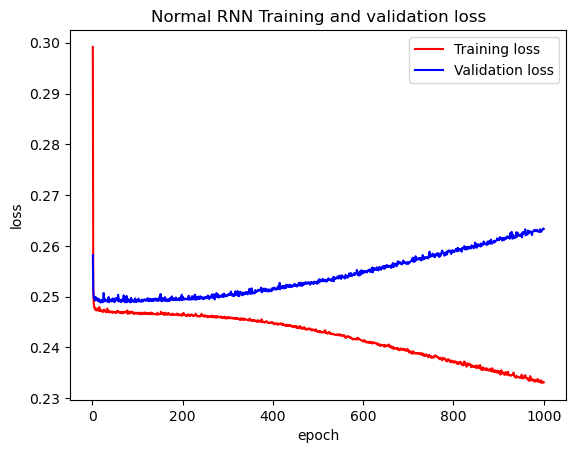

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_17596\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 0s 1ms/step
(3706, 10, 2)


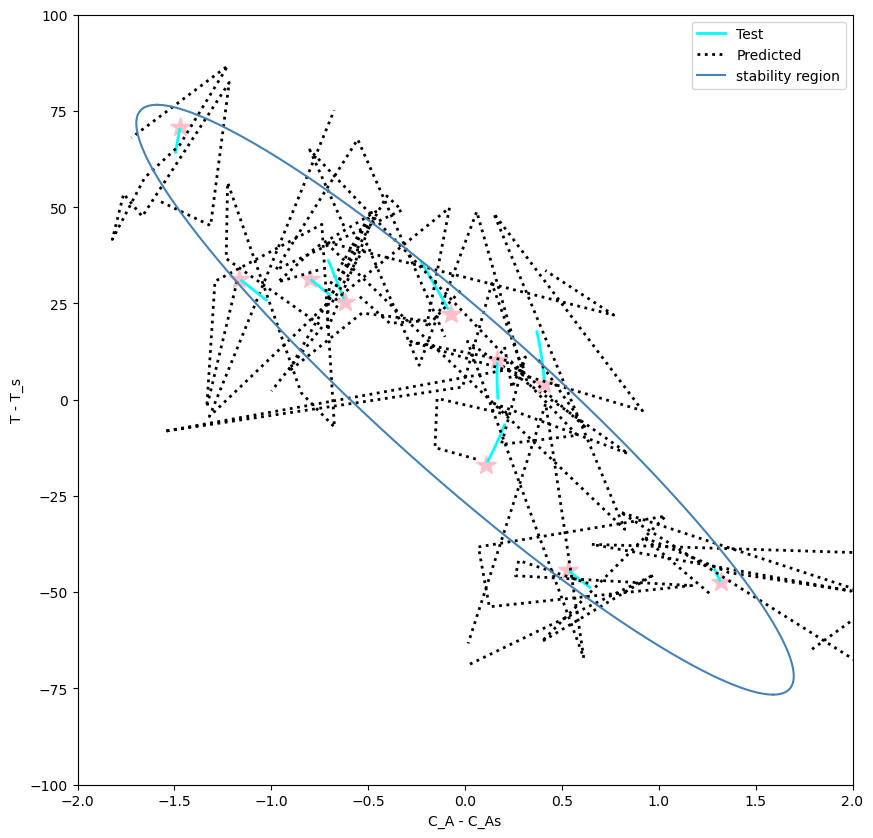

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()